# INVESTIGATION OF HYBRID QUANTUM-CLASSICAL AI FRAMEWORK

In [1]:
!pip install qiskit-optimization --quiet
!pip install qiskit-algorithms --quiet
!pip install qiskit-aer --quiet
!pip install qiskit --quiet
!pip install qiskit-machine-learning --quiet

In [2]:
# Import Libraries
import time
import math
import random
import copy
import warnings
from typing import List, Dict, Any, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

# Scikit-learn Modules
from sklearn.datasets import fetch_openml, make_blobs, make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    mutual_info_classif,
    chi2,
    SelectKBest,
    RFE,
    SelectFromModel,
    f_classif
)
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    DBSCAN,
    SpectralClustering
)
from sklearn.mixture import GaussianMixture

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts


# Feature Selection

In [3]:
def load_ionosphere_data():
    dataset = fetch_openml(name='ionosphere', version=1, as_frame=True)
    X = dataset.data.values
    y = dataset.target.values

    # Convert target to binary
    unique_labels = np.unique(y)
    if len(unique_labels) > 2:
        y = (y == unique_labels[0]).astype(int)
    else:
        # Convert string labels to binary
        if isinstance(y[0], str):
            y = (y == unique_labels[0]).astype(int)

    print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Target classes: {np.unique(y)} with distribution {np.bincount(y)}")

    return X, y

## Baseline  

In [4]:
class ClassicalFeatureSelector:
    def __init__(self, n_features_to_select=8):
        self.n_features_to_select = n_features_to_select
        self.methods = {}
        self.results = {}
        self.execution_times = {}

    def mutual_information_selection(self, X, y):
        start_time = time.time()

        # Mutual information scores
        mi_scores = mutual_info_classif(X, y, random_state=42)

        # Select top k features
        selected_indices = np.argsort(mi_scores)[-self.n_features_to_select:]
        execution_time = time.time() - start_time

        self.methods['Mutual Information'] = {
            'selected_features': selected_indices,
            'scores': mi_scores,
            'execution_time': execution_time
        }

        return selected_indices

    def chi_square_selection(self, X, y):
        start_time = time.time()

        # Ensure non-negative values for chi-square test
        X_positive = X - X.min() + 1e-8

        # Calculate chi-square scores
        chi2_scores, p_values = chi2(X_positive, y)

        # Select top k features
        selected_indices = np.argsort(chi2_scores)[-self.n_features_to_select:]

        execution_time = time.time() - start_time

        self.methods['Chi-Square'] = {
            'selected_features': selected_indices,
            'scores': chi2_scores,
            'p_values': p_values,
            'execution_time': execution_time
        }

        return selected_indices

    def f_statistic_selection(self, X, y):
        """
        ANOVA F-test
        """
        start_time = time.time()

        # Calculate F-scores
        f_scores, p_values = f_classif(X, y)

        # Select top k features
        selected_indices = np.argsort(f_scores)[-self.n_features_to_select:]

        execution_time = time.time() - start_time

        self.methods['F-Statistic'] = {
            'selected_features': selected_indices,
            'scores': f_scores,
            'p_values': p_values,
            'execution_time': execution_time
        }

        return selected_indices

    def recursive_feature_elimination(self, X, y):
        """
        Recursive Feature Elimination with Random Forest
        """
        start_time = time.time()

        estimator = RandomForestClassifier(n_estimators=50, random_state=42)

        # Perform RFE
        rfe = RFE(estimator=estimator, n_features_to_select=self.n_features_to_select)
        rfe.fit(X, y)

        # Get selected features
        selected_indices = np.where(rfe.support_)[0]

        execution_time = time.time() - start_time

        self.methods['RFE'] = {
            'selected_features': selected_indices,
            'ranking': rfe.ranking_,
            'execution_time': execution_time,
            'estimator': rfe.estimator_
        }

        return selected_indices

    def lasso_selection(self, X, y, alpha=0.01):
        """
        Feature selection using LASSO regularization
        """
        start_time = time.time()

        # Fit LASSO with cross-validation for alpha selection
        lasso = Lasso(alpha=alpha, random_state=42, max_iter=1000)
        lasso.fit(X, y)

        # Get non-zero coefficients
        non_zero_mask = lasso.coef_ != 0
        selected_indices = np.where(non_zero_mask)[0]

        if len(selected_indices) > self.n_features_to_select:
            # Select top features by absolute coefficient value
            coef_abs = np.abs(lasso.coef_)
            selected_indices = np.argsort(coef_abs)[-self.n_features_to_select:]
        elif len(selected_indices) < self.n_features_to_select:
            coef_abs = np.abs(lasso.coef_)
            selected_indices = np.argsort(coef_abs)[-self.n_features_to_select:]

        execution_time = time.time() - start_time

        self.methods['LASSO'] = {
            'selected_features': selected_indices,
            'coefficients': lasso.coef_,
            'alpha': alpha,
            'execution_time': execution_time
        }

        return selected_indices

    def random_forest_importance(self, X, y):
        start_time = time.time()

        # Train Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        # Get feature importances
        importances = rf.feature_importances_

        # Select top k features
        selected_indices = np.argsort(importances)[-self.n_features_to_select:]

        execution_time = time.time() - start_time

        self.methods['Random Forest'] = {
            'selected_features': selected_indices,
            'importances': importances,
            'execution_time': execution_time,
            'estimator': rf
        }

        return selected_indices

    def correlation_based_selection(self, X, y, threshold=0.1):
        """
        Correlation with target and feature redundancy
        """
        start_time = time.time()

        # Calculate correlation with target
        correlations = []
        for i in range(X.shape[1]):
            corr, _ = pearsonr(X[:, i], y)
            correlations.append(abs(corr))

        correlations = np.array(correlations)

        # Start with feature with highest correlation
        selected_features = [np.argmax(correlations)]
        remaining_features = list(range(X.shape[1]))
        remaining_features.remove(selected_features[0])

        # Iteratively add features with high target correlation and low inter-correlation
        while len(selected_features) < self.n_features_to_select and remaining_features:
            best_feature = None
            best_score = -1

            for feature in remaining_features:
                # Target correlation score
                target_corr = correlations[feature]

                # Calculate max correlation with already selected features
                max_inter_corr = 0
                for selected_feature in selected_features:
                    inter_corr, _ = pearsonr(X[:, feature], X[:, selected_feature])
                    max_inter_corr = max(max_inter_corr, abs(inter_corr))

                # Combined score: high target correlation, low inter-correlation
                score = target_corr - max_inter_corr

                if score > best_score:
                    best_score = score
                    best_feature = feature

            if best_feature is not None:
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
            else:
                break

        while len(selected_features) < self.n_features_to_select and remaining_features:
            best_remaining = max(remaining_features, key=lambda x: correlations[x])
            selected_features.append(best_remaining)
            remaining_features.remove(best_remaining)

        selected_indices = np.array(selected_features)
        execution_time = time.time() - start_time

        self.methods['Correlation-based'] = {
            'selected_features': selected_indices,
            'correlations': correlations,
            'execution_time': execution_time
        }

        return selected_indices

    def fit_all_methods(self, X, y):
        """
        All classical feature selection methods
        """

        methods_to_run = [
            ('Mutual Information', self.mutual_information_selection),
            ('Chi-Square', self.chi_square_selection),
            ('F-Statistic', self.f_statistic_selection),
            ('RFE', self.recursive_feature_elimination),
            ('LASSO', self.lasso_selection),
            ('Random Forest', self.random_forest_importance),
            ('Correlation-based', self.correlation_based_selection)
        ]

        for method_name, method_func in methods_to_run:
            selected_features = method_func(X, y)
            print(f"\n{method_name}: Selected {len(selected_features)} features in "
                    f"{self.methods[method_name]['execution_time']:.4f}s")
            print(f"Features: {selected_features}")
            print()

        return self.methods

    def evaluate_methods(self, X_train, X_test, y_train, y_test):
        """
        Evaluate all feature selection methods using classification performance
        """
        print("\nEvaluation Classical Feature Selection")

        evaluation_results = {}

        for method_name, method_data in self.methods.items():
            if 'selected_features' not in method_data:
                continue

            selected_features = method_data['selected_features']

            if len(selected_features) == 0:
                print(f"Skipping {method_name}: No features selected")
                continue

            # Train classifier with selected features
            clf = RandomForestClassifier(n_estimators=100, random_state=42)

            try:
                clf.fit(X_train[:, selected_features], y_train)
                y_pred = clf.predict(X_test[:, selected_features])

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')

                evaluation_results[method_name] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'n_features': len(selected_features),
                    'execution_time': method_data['execution_time'],
                    'selected_features': selected_features
                }

                print(f"{method_name:20s}: Accuracy={accuracy:.4f}, F1={f1:.4f}, "
                      f"Features={len(selected_features)}, Time={method_data['execution_time']:.4f}s")

            except Exception as e:
                print(f"Error evaluating {method_name}: {e}")

        self.results = evaluation_results
        return evaluation_results

    def plot_comparison(self):
        """
        Comparing all methods
        """
        methods = list(self.results.keys())
        accuracies = [self.results[method]['accuracy'] for method in methods]
        f1_scores = [self.results[method]['f1_score'] for method in methods]
        execution_times = [self.results[method]['execution_time'] for method in methods]

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Accuracy comparison
        axes[0, 0].bar(methods, accuracies, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Classification Accuracy by Method')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)

        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # F1 Score comparison
        axes[0, 1].bar(methods, f1_scores, color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('F1 Score by Method')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].tick_params(axis='x', rotation=45)

        for i, v in enumerate(f1_scores):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # Execution time comparison
        axes[1, 0].bar(methods, execution_times, color='lightcoral', alpha=0.7)
        axes[1, 0].set_title('Execution Time by Method')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].set_yscale('log')

        for i, v in enumerate(execution_times):
            axes[1, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom')

        # Accuracy vs Time scatter plot
        axes[1, 1].scatter(execution_times, accuracies, s=100, alpha=0.7)
        axes[1, 1].set_xlabel('Execution Time (seconds)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Accuracy vs Execution Time')
        axes[1, 1].set_xscale('log')

        for i, method in enumerate(methods):
            axes[1, 1].annotate(method, (execution_times[i], accuracies[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)

        plt.tight_layout()
        plt.show()

    def get_feature_overlap_analysis(self):
        print("\nFeature Selection Overlap Analysis")

        # Create overlap matrix
        method_names = list(self.methods.keys())
        n_methods = len(method_names)
        overlap_matrix = np.zeros((n_methods, n_methods))

        for i, method1 in enumerate(method_names):
            if 'selected_features' not in self.methods[method1]:
                continue
            features1 = set(self.methods[method1]['selected_features'])

            for j, method2 in enumerate(method_names):
                if 'selected_features' not in self.methods[method2]:
                    continue
                features2 = set(self.methods[method2]['selected_features'])

                # Calculate Jaccard similarity
                intersection = len(features1.intersection(features2))
                union = len(features1.union(features2))
                overlap_matrix[i, j] = intersection / union if union > 0 else 0

        # Plot overlap heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(overlap_matrix,
                   xticklabels=method_names,
                   yticklabels=method_names,
                   annot=True,
                   cmap='Blues',
                   vmin=0,
                   vmax=1)
        plt.title('Feature Selection Method Overlap (Jaccard Similarity)')
        plt.tight_layout()
        plt.show()

        return overlap_matrix

    def get_summary_report(self):
        print("\nSummary Report")

        # Best performing method by accuracy
        best_accuracy_method = max(self.results.keys(),
                                 key=lambda x: self.results[x]['accuracy'])
        best_accuracy = self.results[best_accuracy_method]['accuracy']

        # Fastest method
        fastest_method = min(self.results.keys(),
                           key=lambda x: self.results[x]['execution_time'])
        fastest_time = self.results[fastest_method]['execution_time']

        # Best F1 score
        best_f1_method = max(self.results.keys(),
                           key=lambda x: self.results[x]['f1_score'])
        best_f1 = self.results[best_f1_method]['f1_score']

        print(f"Best Accuracy: {best_accuracy_method} ({best_accuracy:.4f})")
        print(f"Best F1 Score: {best_f1_method} ({best_f1:.4f})")
        print(f"Fastest Method: {fastest_method} ({fastest_time:.4f}s)")

        print(f"\nSelected {self.n_features_to_select} features from each method")
        print(f"Total methods evaluated: {len(self.results)}")

        # Efficiency analysis
        print(f"\nEfficiency Analysis:")
        for method in self.results:
            acc = self.results[method]['accuracy']
            time = self.results[method]['execution_time']
            efficiency = acc / time if time > 0 else 0
            print(f"{method:20s}: {efficiency:.2f} (accuracy/time)")

In [5]:
def main_feature_selection_baseline():
    print("Classical Feature Selection")

    # Load and prepare data
    X, y = load_ionosphere_data()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Initialize classical feature selector
    selector = ClassicalFeatureSelector(n_features_to_select=8)

    # Run all methods
    methods_results = selector.fit_all_methods(X_train, y_train)

    # Evaluate methods
    evaluation_results = selector.evaluate_methods(X_train, X_test, y_train, y_test)

    # Generate visualizations
    selector.plot_comparison()

    # Feature overlap analysis
    selector.get_feature_overlap_analysis()

    # Summary report
    selector.get_summary_report()

    return selector, evaluation_results

Classical Feature Selection
Dataset loaded: 351 samples, 34 features
Target classes: [0 1] with distribution [225 126]

Mutual Information: Selected 8 features in 0.1477s
Features: [28  6 26 30 20  2  4  5]


Chi-Square: Selected 8 features in 0.0017s
Features: [13 32  8 30  6  0  4  2]


F-Statistic: Selected 8 features in 0.0008s
Features: [32  8 30  6  0  4  2  1]


RFE: Selected 8 features in 4.7260s
Features: [ 2  3  4  5  6 13 23 26]


LASSO: Selected 8 features in 0.0055s
Features: [23 22  5  4 26  0 21  2]


Random Forest: Selected 8 features in 0.5106s
Features: [23  3  5 13  6  4  2 26]


Correlation-based: Selected 8 features in 0.6483s
Features: [ 1  2  0  5  4 15 13  3]


Evaluation Classical Feature Selection
Mutual Information  : Accuracy=0.9340, F1=0.9328, Features=8, Time=0.1477s
Chi-Square          : Accuracy=0.9245, F1=0.9222, Features=8, Time=0.0017s
F-Statistic         : Accuracy=0.9057, F1=0.9017, Features=8, Time=0.0008s
RFE                 : Accuracy=0.9245, F1=

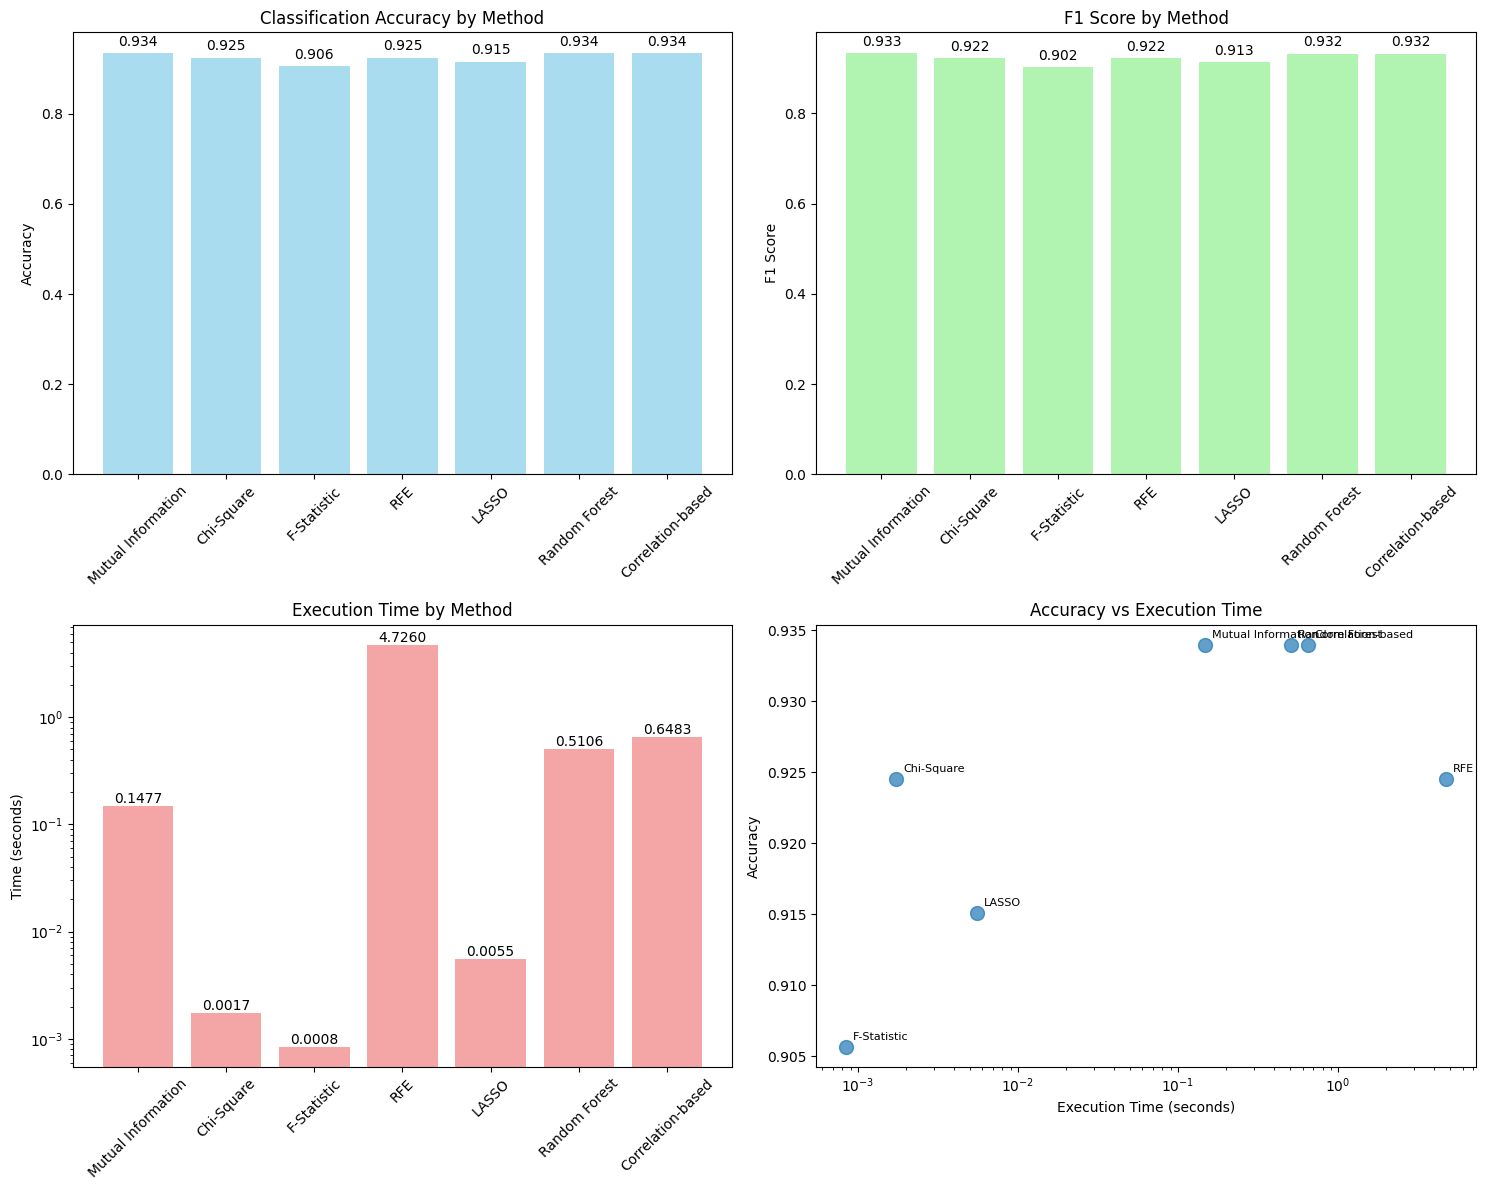


Feature Selection Overlap Analysis


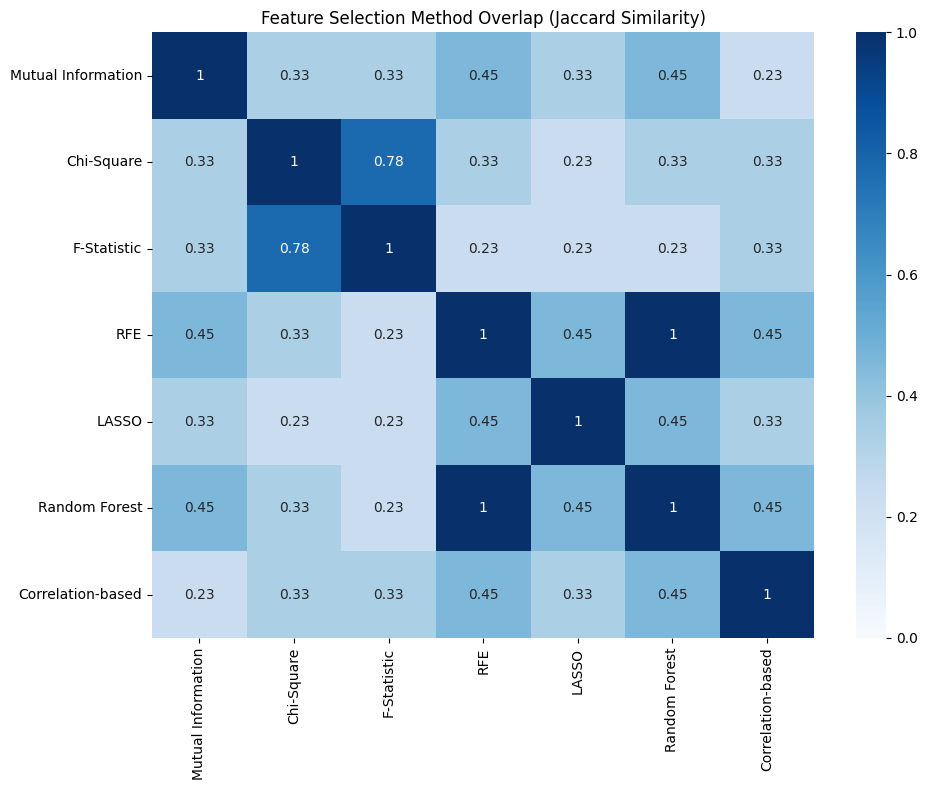


Summary Report
Best Accuracy: Mutual Information (0.9340)
Best F1 Score: Mutual Information (0.9328)
Fastest Method: F-Statistic (0.0008s)

Selected 8 features from each method
Total methods evaluated: 7

Efficiency Analysis:
Mutual Information  : 6.32 (accuracy/time)
Chi-Square          : 531.20 (accuracy/time)
F-Statistic         : 1072.15 (accuracy/time)
RFE                 : 0.20 (accuracy/time)
LASSO               : 165.67 (accuracy/time)
Random Forest       : 1.83 (accuracy/time)
Correlation-based   : 1.44 (accuracy/time)


In [6]:
if __name__ == "__main__":
    selector, results = main_feature_selection_baseline()

## Quantum vs. Classical

In [7]:
class FeatureSelectorBase:

    def __init__(self, n_features_to_select=8):
        self.n_features_to_select = n_features_to_select
        self.selected_features = None
        self.execution_time = None
        self.method_name = "Base"

    def fit(self, X, y):
        """To be implemented by subclasses"""
        raise NotImplementedError

    def transform(self, X):
        """Transform data using selected features"""
        if self.selected_features is None:
            raise ValueError("Selector has not been fitted yet")
        return X[:, self.selected_features]

    def fit_transform(self, X, y):
        """Fit selector and transform data"""
        return self.fit(X, y).transform(X)

    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        Unified evaluation method for all feature selectors
        """

        # Train classifier with selected features
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train[:, self.selected_features], y_train)
        y_pred = clf.predict(X_test[:, self.selected_features])

        # Calculate metrics
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'n_features': len(self.selected_features),
            'execution_time': self.execution_time or 0.0,
            'selected_features': self.selected_features.copy(),
            'method_name': self.method_name
        }

In [8]:
class ClassicalFeatureSelector(FeatureSelectorBase):

    def __init__(self, method='mutual_info', n_features_to_select=8):
        super().__init__(n_features_to_select)
        self.method = method
        self.method_name = f"Classical-{method.replace('_', ' ').title()}"

    def fit(self, X, y):
        """Fit the classical feature selector"""
        start_time = time.time()

        if self.method == 'mutual_info':
            self.selected_features = self._mutual_information_selection(X, y)
        elif self.method == 'chi_square':
            self.selected_features = self._chi_square_selection(X, y)
        elif self.method == 'f_statistic':
            self.selected_features = self._f_statistic_selection(X, y)
        elif self.method == 'rfe':
            self.selected_features = self._recursive_feature_elimination(X, y)
        elif self.method == 'lasso':
            self.selected_features = self._lasso_selection(X, y)
        elif self.method == 'random_forest':
            self.selected_features = self._random_forest_importance(X, y)
        elif self.method == 'correlation':
            self.selected_features = self._correlation_based_selection(X, y)
        else:
            raise ValueError(f"Unknown method: {self.method}")

        self.execution_time = time.time() - start_time
        return self

    def _mutual_information_selection(self, X, y):
        mi_scores = mutual_info_classif(X, y, random_state=42)
        return np.argsort(mi_scores)[-self.n_features_to_select:]

    def _chi_square_selection(self, X, y):
        X_positive = X - X.min() + 1e-8
        chi2_scores, _ = chi2(X_positive, y)
        return np.argsort(chi2_scores)[-self.n_features_to_select:]

    def _f_statistic_selection(self, X, y):
        f_scores, _ = f_classif(X, y)
        return np.argsort(f_scores)[-self.n_features_to_select:]

    def _recursive_feature_elimination(self, X, y):
        estimator = RandomForestClassifier(n_estimators=50, random_state=42)
        rfe = RFE(estimator=estimator, n_features_to_select=self.n_features_to_select)
        rfe.fit(X, y)
        return np.where(rfe.support_)[0]

    def _lasso_selection(self, X, y, alpha=0.01):
        lasso = Lasso(alpha=alpha, random_state=42, max_iter=1000)
        lasso.fit(X, y)
        coef_abs = np.abs(lasso.coef_)
        return np.argsort(coef_abs)[-self.n_features_to_select:]

    def _random_forest_importance(self, X, y):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        return np.argsort(importances)[-self.n_features_to_select:]

    def _correlation_based_selection(self, X, y):
        correlations = []
        for i in range(X.shape[1]):
            corr, _ = pearsonr(X[:, i], y)
            correlations.append(abs(corr))
        correlations = np.array(correlations)

        selected_features = [np.argmax(correlations)]
        remaining_features = list(range(X.shape[1]))
        remaining_features.remove(selected_features[0])

        while len(selected_features) < self.n_features_to_select and remaining_features:
            best_feature = None
            best_score = -1

            for feature in remaining_features:
                target_corr = correlations[feature]
                max_inter_corr = 0
                for selected_feature in selected_features:
                    inter_corr, _ = pearsonr(X[:, feature], X[:, selected_feature])
                    max_inter_corr = max(max_inter_corr, abs(inter_corr))

                score = target_corr - max_inter_corr
                if score > best_score:
                    best_score = score
                    best_feature = feature

            if best_feature is not None:
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
            else:
                break

        while len(selected_features) < self.n_features_to_select and remaining_features:
            best_remaining = max(remaining_features, key=lambda x: correlations[x])
            selected_features.append(best_remaining)
            remaining_features.remove(best_remaining)

        return np.array(selected_features)

In [9]:
class QAOAFeatureSelector(FeatureSelectorBase):

    def __init__(self, max_features=10, p=1, optimizer='COBYLA', n_features_to_select=8):
        super().__init__(n_features_to_select)
        self.max_features = max_features
        self.p = p
        self.optimizer_name = optimizer
        self.method_name = f"Quantum-QAOA-p{p}"
        self.backend = AerSimulator()
        self.qaoa_result = None

    def _create_feature_correlation_matrix(self, X, y):
        """Create correlation matrix between features and with target"""
        mi_scores = mutual_info_classif(X, y, random_state=42)
        corr_matrix = np.corrcoef(X.T)
        return mi_scores, corr_matrix

    def _create_qubo_matrix(self, X, y, lambda_penalty=0.5):
        """Create QUBO matrix for feature selection problem"""
        n_features = X.shape[1]
        mi_scores, corr_matrix = self._create_feature_correlation_matrix(X, y)

        Q = np.zeros((n_features, n_features))

        # Diagonal terms: reward high mutual information
        for i in range(n_features):
            Q[i, i] = -mi_scores[i]  # Negative for minimization

        # Off-diagonal terms: penalize correlated features
        for i in range(n_features):
            for j in range(i + 1, n_features):
                correlation = abs(corr_matrix[i, j])
                Q[i, j] = lambda_penalty * correlation
                Q[j, i] = lambda_penalty * correlation

        return Q, mi_scores

    def _create_qaoa_circuit(self, n_qubits, beta, gamma):
        """Create QAOA circuit with given parameters"""
        qc = QuantumCircuit(n_qubits)

        # Initial superposition
        qc.h(range(n_qubits))

        # QAOA layers
        for layer in range(self.p):
            # Problem Hamiltonian (cost layer)
            for i in range(n_qubits):
                qc.rz(2 * gamma[layer] * self.linear_terms[i], i)

            for i in range(n_qubits):
                for j in range(i + 1, n_qubits):
                    if abs(self.coupling_terms[i, j]) > 1e-8:
                        qc.rzz(2 * gamma[layer] * self.coupling_terms[i, j], i, j)

            # Mixer Hamiltonian (mixing layer)
            for i in range(n_qubits):
                qc.rx(2 * beta[layer], i)

        return qc

    def _evaluate_qaoa_circuit(self, params, n_qubits):
        """Evaluate QAOA circuit and return expected energy"""
        beta = params[:self.p]
        gamma = params[self.p:]

        try:
            # Create and execute circuit
            qc = self._create_qaoa_circuit(n_qubits, beta, gamma)
            qc.measure_all()

            # Execute circuit
            job = self.backend.run(transpile(qc, self.backend), shots=1024)
            counts = job.result().get_counts()

            # Calculate expected energy
            total_energy = 0
            total_shots = sum(counts.values())

            for bitstring, count in counts.items():
                # Convert bitstring to solution vector
                x = np.array([int(bit) for bit in reversed(bitstring)])

                # Calculate energy for this solution
                energy = 0
                # Linear terms
                for i in range(n_qubits):
                    energy += self.linear_terms[i] * x[i]

                # Quadratic terms
                for i in range(n_qubits):
                    for j in range(i + 1, n_qubits):
                        energy += self.coupling_terms[i, j] * x[i] * x[j]

                total_energy += energy * count / total_shots

            return total_energy

        except Exception as e:
            print(f"Error in QAOA circuit evaluation: {e}")
            return float('inf')

    def _get_best_solution(self, n_qubits, optimal_params):
        """Get the best solution from the optimized QAOA circuit"""
        beta = optimal_params[:self.p]
        gamma = optimal_params[self.p:]

        try:
            # Create and execute optimized circuit
            qc = self._create_qaoa_circuit(n_qubits, beta, gamma)
            qc.measure_all()

            job = self.backend.run(transpile(qc, self.backend), shots=2048)
            counts = job.result().get_counts()

            # Get most frequent bitstring
            best_solution = max(counts.items(), key=lambda x: x[1])[0]

            return best_solution, counts

        except Exception as e:
            print(f"Error getting best solution: {e}")
            return None, {}

    def fit(self, X, y):
        """Fit the QAOA feature selector using unified interface"""
        start_time = time.time()

        print(f"\n{self.method_name} feature selection on {X.shape[1]} features")

        # Limit features for quantum computation
        if X.shape[1] > self.max_features:
            # Pre-select top features based on mutual information
            mi_scores = mutual_info_classif(X, y, random_state=42)
            top_indices = np.argsort(mi_scores)[-self.max_features:]
            X_subset = X[:, top_indices]
            print(f"Pre-selected top {self.max_features} features based on mutual information")
        else:
            X_subset = X
            top_indices = np.arange(X.shape[1])

        n_qubits = X_subset.shape[1]

        try:
            # Create QUBO matrix
            Q, mi_scores_subset = self._create_qubo_matrix(X_subset, y)

            # Extract linear and coupling terms for QAOA
            self.linear_terms = np.diag(Q)
            self.coupling_terms = Q - np.diag(np.diag(Q))

            # Initialize parameters randomly
            initial_params = np.random.uniform(0, 2*np.pi, 2*self.p)

            print(f"Optimizing QAOA parameters with {self.optimizer_name}")

            # Optimize QAOA parameters
            if self.optimizer_name == 'COBYLA':
                result = minimize(
                    fun=lambda params: self._evaluate_qaoa_circuit(params, n_qubits),
                    x0=initial_params,
                    method='COBYLA',
                    options={'maxiter': 30, 'disp': False}  # Reduced iterations for faster execution
                )
            else:
                result = minimize(
                    fun=lambda params: self._evaluate_qaoa_circuit(params, n_qubits),
                    x0=initial_params,
                    method='Powell',
                    options={'maxiter': 30, 'disp': False}
                )

            optimal_params = result.x

            # best solution
            best_bitstring, counts = self._get_best_solution(n_qubits, optimal_params)

            if best_bitstring is not None:

                # Convert bitstring to feature indices
                selected_mask = [bit == '1' for bit in reversed(best_bitstring)]

                if sum(selected_mask) > self.n_features_to_select:
                    selected_indices_temp = top_indices[np.array(selected_mask)]
                    mi_temp = mi_scores_subset[np.array(selected_mask)]
                    best_indices = np.argsort(mi_temp)[-self.n_features_to_select:]
                    self.selected_features = selected_indices_temp[best_indices]

                elif sum(selected_mask) < self.n_features_to_select:
                    selected_indices_temp = top_indices[np.array(selected_mask)]
                    remaining_indices = top_indices[~np.array(selected_mask)]
                    remaining_mi = mi_scores_subset[~np.array(selected_mask)]
                    n_additional = self.n_features_to_select - len(selected_indices_temp)
                    additional_indices = remaining_indices[np.argsort(remaining_mi)[-n_additional:]]
                    self.selected_features = np.concatenate([selected_indices_temp, additional_indices])

                else:
                    # Perfect number selected
                    self.selected_features = top_indices[np.array(selected_mask)]

                print(f"QAOA optimization completed with energy: {result.fun:.4f}")
                print(f"Selected {len(self.selected_features)} features: {self.selected_features}")

                # Store additional info
                self.optimization_result = result
                self.bit_counts = counts

            else:
                raise Exception("Failed to get valid solution from QAOA")

        except Exception as e:
            print(f"QAOA optimization failed: {e}")

            # Fallback to top mutual information features
            mi_scores = mutual_info_classif(X_subset, y, random_state=42)
            fallback_indices = np.argsort(mi_scores)[-self.n_features_to_select:]
            self.selected_features = top_indices[fallback_indices]
            print(f"Using fallback selection: {self.selected_features}")

        self.execution_time = time.time() - start_time
        return self

In [10]:
class QuantumClassicalComparator:
    """
    Comparison framework for quantum and classical feature selection
    """

    def __init__(self, n_features_to_select=8):
        self.n_features_to_select = n_features_to_select
        self.selectors = {}
        self.results = {}

    def add_classical_methods(self):

        classical_methods = [
            'mutual_info', 'chi_square', 'f_statistic',
            'rfe', 'lasso', 'random_forest', 'correlation'
        ]

        for method in classical_methods:
            selector = ClassicalFeatureSelector(
                method=method,
                n_features_to_select=self.n_features_to_select
            )
            self.selectors[selector.method_name] = selector

    def add_quantum_methods(self):
        # QAOA with different parameters
        qaoa_configs = [
            {'p': 1, 'optimizer': 'COBYLA'},
            {'p': 1, 'optimizer': 'Powell'},
            {'p': 2, 'optimizer': 'COBYLA'}
        ]

        for config in qaoa_configs:
            selector = QAOAFeatureSelector(
                max_features=min(10, self.n_features_to_select + 2),
                p=config['p'],
                optimizer=config['optimizer'],
                n_features_to_select=self.n_features_to_select
            )
            self.selectors[selector.method_name + f"-{config['optimizer']}"] = selector

    def run_comparison(self, X_train, X_test, y_train, y_test):
        print("\nQuantum vs. Classical Feature Selection")

        for method_name, selector in self.selectors.items():
            print(f"\n{method_name}")

            try:
                # Fit the selector
                selector.fit(X_train, y_train)

                # Evaluate performance
                result = selector.evaluate(X_train, X_test, y_train, y_test)
                result['method_category'] = 'Quantum' if 'Quantum' in method_name else 'Classical'

                self.results[method_name] = result

                # Print results
                if 'error' in result:
                    print(f"  ERROR: {result['error']}")
                else:
                    print(f"  Accuracy: {result['accuracy']:.4f}")
                    print(f"  F1 Score: {result['f1_score']:.4f}")
                    print(f"  Features: {result['n_features']}")
                    print(f"  Time: {result['execution_time']:.4f}s")

            except Exception as e:
                print(f"  ERROR in {method_name}: {e}")
                self.results[method_name] = {
                    'accuracy': 0.0,
                    'f1_score': 0.0,
                    'n_features': 0,
                    'execution_time': 0.0,
                    'error': str(e),
                    'method_category': 'Quantum' if 'Quantum' in method_name else 'Classical'
                }

        return self.results

    def plot_comprehensive_comparison(self):
        if not self.results:
            print("No results to plot. Run comparison first.")
            return

        # Filter out methods with errors
        valid_results = {k: v for k, v in self.results.items()
                        if 'error' not in v or v.get('accuracy', 0) > 0}

        if not valid_results:
            print("No valid results to plot.")
            return

        # Prepare data
        methods = list(valid_results.keys())
        accuracies = [valid_results[method]['accuracy'] for method in methods]
        f1_scores = [valid_results[method]['f1_score'] for method in methods]
        execution_times = [valid_results[method]['execution_time'] for method in methods]
        categories = [valid_results[method]['method_category'] for method in methods]

        # Create color mapping
        colors = ['skyblue' if cat == 'Classical' else 'lightcoral' for cat in categories]

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Accuracy comparison
        bars1 = axes[0, 0].bar(range(len(methods)), accuracies, color=colors, alpha=0.7)
        axes[0, 0].set_title('Classification Accuracy: Classical vs Quantum Methods')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_xticks(range(len(methods)))
        axes[0, 0].set_xticklabels(methods, rotation=45, ha='right')

        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='Classical'),
                          Patch(facecolor='lightcoral', label='Quantum')]
        axes[0, 0].legend(handles=legend_elements)

        # F1 Score comparison
        bars2 = axes[0, 1].bar(range(len(methods)), f1_scores, color=colors, alpha=0.7)
        axes[0, 1].set_title('F1 Score: Classical vs Quantum Methods')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].set_xticks(range(len(methods)))
        axes[0, 1].set_xticklabels(methods, rotation=45, ha='right')

        for i, v in enumerate(f1_scores):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        # Execution time comparison
        bars3 = axes[1, 0].bar(range(len(methods)), execution_times, color=colors, alpha=0.7)
        axes[1, 0].set_title('Execution Time: Classical vs Quantum Methods')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].set_xticks(range(len(methods)))
        axes[1, 0].set_xticklabels(methods, rotation=45, ha='right')
        axes[1, 0].set_yscale('log')

        for i, v in enumerate(execution_times):
            axes[1, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        # Accuracy vs Time scatter plot
        scatter = axes[1, 1].scatter(execution_times, accuracies,
                                   c=['blue' if cat == 'Classical' else 'red' for cat in categories],
                                   s=100, alpha=0.7)
        axes[1, 1].set_xlabel('Execution Time (seconds)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Accuracy vs Execution Time')
        axes[1, 1].set_xscale('log')

        for i, method in enumerate(methods):
            axes[1, 1].annotate(method.split('-')[0], (execution_times[i], accuracies[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)

        plt.tight_layout()
        plt.show()

    def summary_report(self):

        print("\nSummary Report")

        # Filter valid results
        valid_results = {k: v for k, v in self.results.items()
                        if 'error' not in v or v.get('accuracy', 0) > 0}

        # Separate by category
        classical_results = {k: v for k, v in valid_results.items() if v['method_category'] == 'Classical'}
        quantum_results = {k: v for k, v in valid_results.items() if v['method_category'] == 'Quantum'}

        print(f"\nClassical Methods ({len(classical_results)} methods):")
        if classical_results:
            best_classical = max(classical_results.items(), key=lambda x: x[1]['accuracy'])
            fastest_classical = min(classical_results.items(), key=lambda x: x[1]['execution_time'])

            print(f"Best Accuracy: {best_classical[0]} ({best_classical[1]['accuracy']:.4f})")
            print(f"Fastest: {fastest_classical[0]} ({fastest_classical[1]['execution_time']:.4f}s)")

            # Average performance
            avg_acc = np.mean([v['accuracy'] for v in classical_results.values()])
            avg_time = np.mean([v['execution_time'] for v in classical_results.values()])
            print(f"Average Accuracy: {avg_acc:.4f}")
            print(f"Average Time: {avg_time:.4f}s")

        print(f"\nQuantum Methods ({len(quantum_results)} methods):")
        if quantum_results:
            best_quantum = max(quantum_results.items(), key=lambda x: x[1]['accuracy'])
            fastest_quantum = min(quantum_results.items(), key=lambda x: x[1]['execution_time'])

            print(f"Best Accuracy: {best_quantum[0]} ({best_quantum[1]['accuracy']:.4f})")
            print(f"Fastest: {fastest_quantum[0]} ({fastest_quantum[1]['execution_time']:.4f}s)")

            # Average performance
            avg_acc = np.mean([v['accuracy'] for v in quantum_results.values()])
            avg_time = np.mean([v['execution_time'] for v in quantum_results.values()])
            print(f"Average Accuracy: {avg_acc:.4f}")
            print(f"Average Time: {avg_time:.4f}s")

        # Overall comparison
        if classical_results and quantum_results:
            print(f"\nComperison:")

            classical_best_acc = max(v['accuracy'] for v in classical_results.values())
            quantum_best_acc = max(v['accuracy'] for v in quantum_results.values())

            print(f"Best Classical Accuracy: {classical_best_acc:.4f}")
            print(f"Best Quantum Accuracy: {quantum_best_acc:.4f}")

            if quantum_best_acc > classical_best_acc:
                print(f"Quantum Advantage: +{(quantum_best_acc - classical_best_acc)*100:.2f}%")
            else:
                print(f"Classical Leading: +{(classical_best_acc - quantum_best_acc)*100:.2f}%")

In [11]:
def main_feature_selection_quantum_vs_classical():
    print("Quantum vs. Classical Feature Selection")

    # Load and prepare data
    X, y = load_ionosphere_data()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Initialize comparator
    comparator = QuantumClassicalComparator(n_features_to_select=8)

    # Add classical methods
    comparator.add_classical_methods()

    # Add quantum methods
    comparator.add_quantum_methods()

    print(f"\nTotal methods to compare: {len(comparator.selectors)}")
    for method_name in comparator.selectors.keys():
        print(f"  - {method_name}")

    # Run comprehensive comparison
    results = comparator.run_comparison(X_train, X_test, y_train, y_test)

    # Generate visualizations
    comparator.plot_comprehensive_comparison()

    # Generate summary report
    comparator.summary_report()

    # Feature analysis for best methods
    print("Feature Analysis for Top Performers")

    # Find best performing methods
    valid_results = {k: v for k, v in results.items()
                    if 'error' not in v and v.get('accuracy', 0) > 0}

    if valid_results:
        # Best classical method
        classical_results = {k: v for k, v in valid_results.items()
                           if v['method_category'] == 'Classical'}
        if classical_results:
            best_classical = max(classical_results.items(), key=lambda x: x[1]['accuracy'])
            print(f"\nBest Classical Method: {best_classical[0]}")
            print(f"Selected Features: {best_classical[1]['selected_features']}")

        # Best quantum method
        quantum_results = {k: v for k, v in valid_results.items()
                         if v['method_category'] == 'Quantum'}
        if quantum_results:
            best_quantum = max(quantum_results.items(), key=lambda x: x[1]['accuracy'])
            print(f"\nBest Quantum Method: {best_quantum[0]}")
            print(f"Selected Features: {best_quantum[1]['selected_features']}")

        # Feature overlap analysis between best methods
        if classical_results and quantum_results:
            classical_features = set(best_classical[1]['selected_features'])
            quantum_features = set(best_quantum[1]['selected_features'])

            overlap = classical_features.intersection(quantum_features)
            print(f"\nFeature Overlap Analysis:")
            print(f"Classical features: {sorted(classical_features)}")
            print(f"Quantum features: {sorted(quantum_features)}")
            print(f"Overlapping features: {sorted(overlap)} ({len(overlap)}/{len(classical_features)} features)")

            jaccard_similarity = len(overlap) / len(classical_features.union(quantum_features))
            print(f"Jaccard Similarity: {jaccard_similarity:.3f}")

    return comparator, results

Quantum vs. Classical Feature Selection
Dataset loaded: 351 samples, 34 features
Target classes: [0 1] with distribution [225 126]

Total methods to compare: 10
  - Classical-Mutual Info
  - Classical-Chi Square
  - Classical-F Statistic
  - Classical-Rfe
  - Classical-Lasso
  - Classical-Random Forest
  - Classical-Correlation
  - Quantum-QAOA-p1-COBYLA
  - Quantum-QAOA-p1-Powell
  - Quantum-QAOA-p2-COBYLA

Quantum vs. Classical Feature Selection

Classical-Mutual Info
  Accuracy: 0.9340
  F1 Score: 0.9328
  Features: 8
  Time: 0.2133s

Classical-Chi Square
  Accuracy: 0.9245
  F1 Score: 0.9222
  Features: 8
  Time: 0.0020s

Classical-F Statistic
  Accuracy: 0.9057
  F1 Score: 0.9017
  Features: 8
  Time: 0.0048s

Classical-Rfe
  Accuracy: 0.9245
  F1 Score: 0.9222
  Features: 8
  Time: 6.8932s

Classical-Lasso
  Accuracy: 0.9151
  F1 Score: 0.9129
  Features: 8
  Time: 0.0028s

Classical-Random Forest
  Accuracy: 0.9340
  F1 Score: 0.9322
  Features: 8
  Time: 0.5991s

Classical-Corr

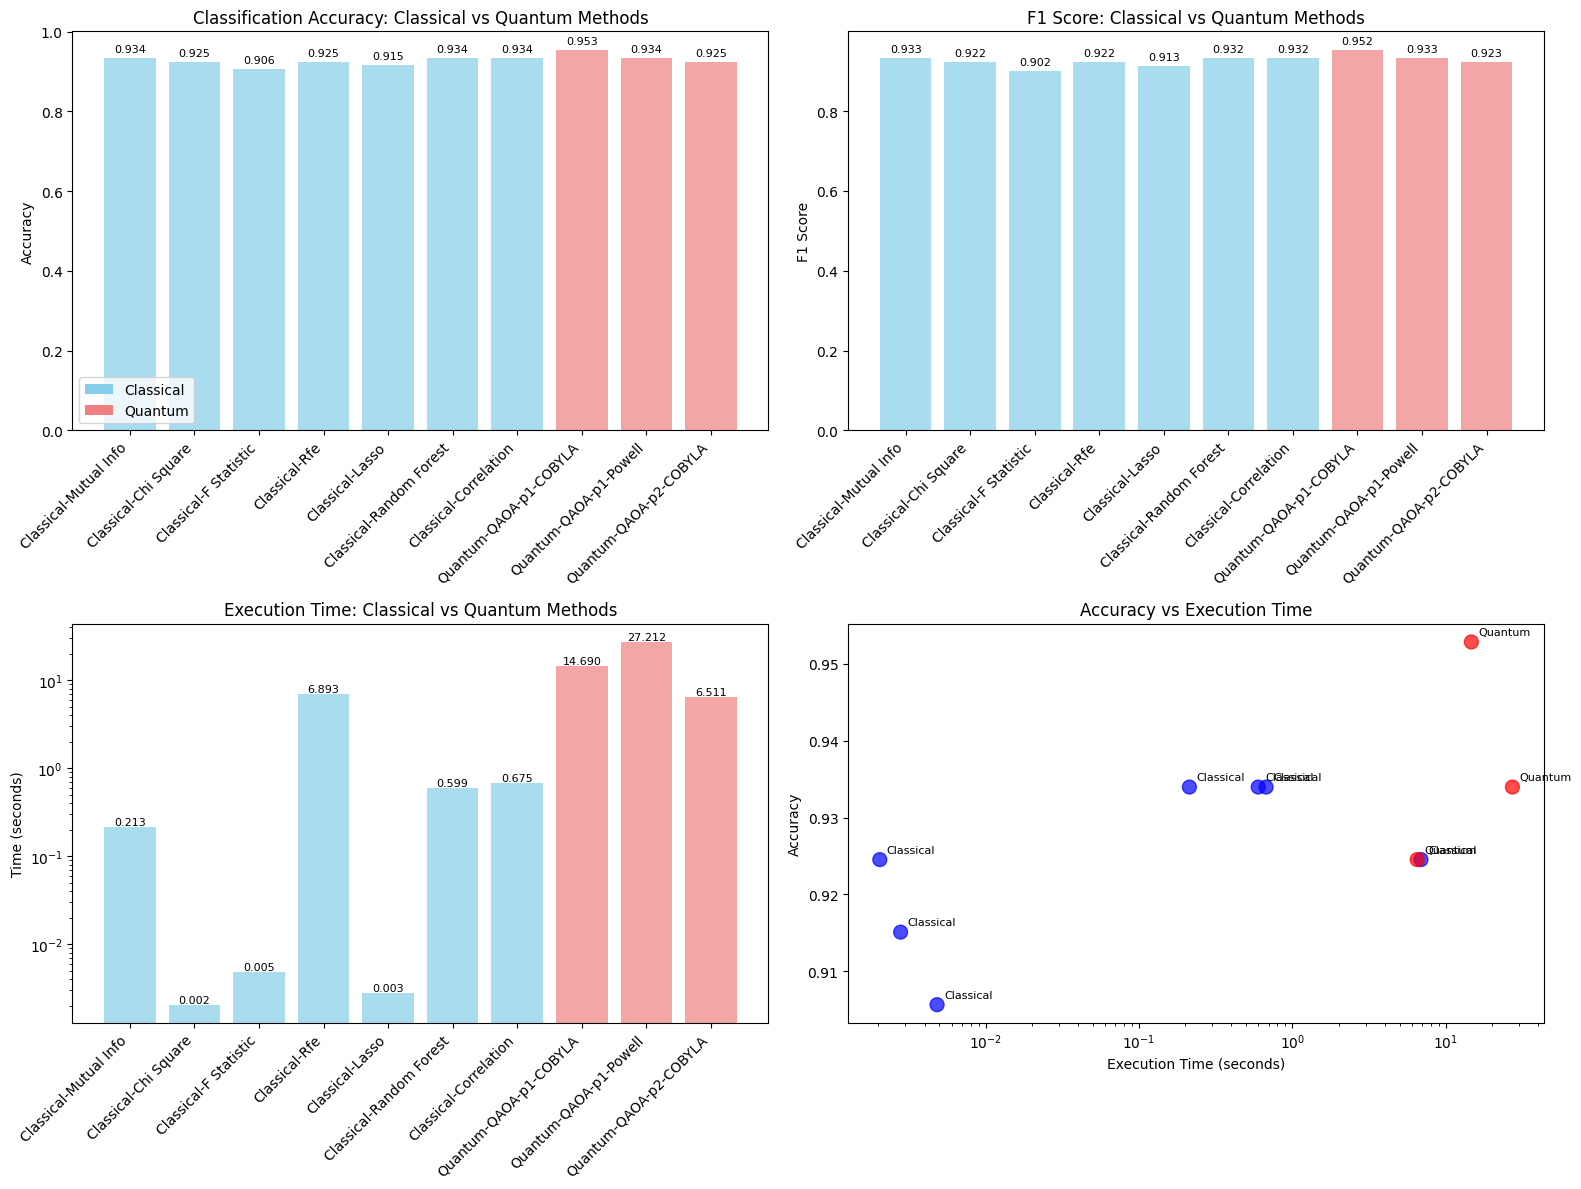


Summary Report

Classical Methods (7 methods):
Best Accuracy: Classical-Mutual Info (0.9340)
Fastest: Classical-Chi Square (0.0020s)
Average Accuracy: 0.9245
Average Time: 1.1985s

Quantum Methods (3 methods):
Best Accuracy: Quantum-QAOA-p1-COBYLA (0.9528)
Fastest: Quantum-QAOA-p2-COBYLA (6.5109s)
Average Accuracy: 0.9371
Average Time: 16.1374s

Comperison:
Best Classical Accuracy: 0.9340
Best Quantum Accuracy: 0.9528
Quantum Advantage: +1.89%
Feature Analysis for Top Performers

Best Classical Method: Classical-Mutual Info
Selected Features: [28  6 26 30 20  2  4  5]

Best Quantum Method: Quantum-QAOA-p1-COBYLA
Selected Features: [13  7 28 26 30 20  5  4]

Feature Overlap Analysis:
Classical features: [np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(20), np.int64(26), np.int64(28), np.int64(30)]
Quantum features: [np.int64(4), np.int64(5), np.int64(7), np.int64(13), np.int64(20), np.int64(26), np.int64(28), np.int64(30)]
Overlapping features: [np.int64(4), np.int64(5), n

In [12]:
if __name__ == "__main__":
    comparator, results = main_feature_selection_quantum_vs_classical()

## Hybrid vs. Quantum vs. Classical

In [13]:
class ClassicalFeatureSelector(FeatureSelectorBase):
    """Classical feature selection methods"""

    def __init__(self, method='mutual_info', n_features_to_select=8):
        super().__init__(n_features_to_select)
        self.method = method
        self.method_name = f"Classical-{method.replace('_', ' ').title()}"

    def fit(self, X, y):
        start_time = time.time()

        if self.method == 'mutual_info':
            mi_scores = mutual_info_classif(X, y, random_state=42)
            self.selected_features = np.argsort(mi_scores)[-self.n_features_to_select:]
        elif self.method == 'random_forest':
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)
            importances = rf.feature_importances_
            self.selected_features = np.argsort(importances)[-self.n_features_to_select:]

        self.execution_time = time.time() - start_time
        return self

In [14]:
class QAOAFeatureSelector(FeatureSelectorBase):
    """QAOA-based quantum feature selector"""

    def __init__(self, max_features=10, p=1, optimizer='COBYLA', n_features_to_select=8):
        super().__init__(n_features_to_select)
        self.max_features = max_features
        self.p = p
        self.optimizer_name = optimizer
        self.method_name = f"Quantum-QAOA-p{p}"
        self.backend = AerSimulator()

    def _create_qubo_matrix(self, X, y, lambda_penalty=0.5):
        """Create QUBO matrix for feature selection"""
        n_features = X.shape[1]
        mi_scores = mutual_info_classif(X, y, random_state=42)
        corr_matrix = np.corrcoef(X.T)

        Q = np.zeros((n_features, n_features))

        # Diagonal terms: reward high mutual information
        for i in range(n_features):
            Q[i, i] = -mi_scores[i]

        # Off-diagonal terms: penalize correlated features
        for i in range(n_features):
            for j in range(i + 1, n_features):
                correlation = abs(corr_matrix[i, j])
                Q[i, j] = lambda_penalty * correlation
                Q[j, i] = lambda_penalty * correlation

        return Q, mi_scores

    def _create_qaoa_circuit(self, n_qubits, beta, gamma):
        """Create QAOA circuit"""
        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))

        for layer in range(self.p):
            # Problem Hamiltonian
            for i in range(n_qubits):
                qc.rz(2 * gamma[layer] * self.linear_terms[i], i)

            for i in range(n_qubits):
                for j in range(i + 1, n_qubits):
                    if abs(self.coupling_terms[i, j]) > 1e-8:
                        qc.rzz(2 * gamma[layer] * self.coupling_terms[i, j], i, j)

            # Mixer Hamiltonian
            for i in range(n_qubits):
                qc.rx(2 * beta[layer], i)

        return qc

    def _evaluate_qaoa_circuit(self, params, n_qubits):
        """Evaluate QAOA circuit energy"""
        beta = params[:self.p]
        gamma = params[self.p:]

        try:
            qc = self._create_qaoa_circuit(n_qubits, beta, gamma)
            qc.measure_all()

            job = self.backend.run(transpile(qc, self.backend), shots=1024)
            counts = job.result().get_counts()

            total_energy = 0
            total_shots = sum(counts.values())

            for bitstring, count in counts.items():
                x = np.array([int(bit) for bit in reversed(bitstring)])
                energy = 0

                for i in range(n_qubits):
                    energy += self.linear_terms[i] * x[i]

                for i in range(n_qubits):
                    for j in range(i + 1, n_qubits):
                        energy += self.coupling_terms[i, j] * x[i] * x[j]

                total_energy += energy * count / total_shots

            return total_energy
        except:
            return float('inf')

    def fit(self, X, y):
        """Fit QAOA feature selector"""
        start_time = time.time()

        # Limit features for quantum computation
        if X.shape[1] > self.max_features:
            mi_scores = mutual_info_classif(X, y, random_state=42)
            top_indices = np.argsort(mi_scores)[-self.max_features:]
            X_subset = X[:, top_indices]
        else:
            X_subset = X
            top_indices = np.arange(X.shape[1])

        n_qubits = X_subset.shape[1]

        try:
            Q, mi_scores_subset = self._create_qubo_matrix(X_subset, y)
            self.linear_terms = np.diag(Q)
            self.coupling_terms = Q - np.diag(np.diag(Q))

            initial_params = np.random.uniform(0, 2*np.pi, 2*self.p)

            result = minimize(
                fun=lambda params: self._evaluate_qaoa_circuit(params, n_qubits),
                x0=initial_params,
                method='COBYLA',
                options={'maxiter': 20, 'disp': False}
            )

            # Get best solution
            beta = result.x[:self.p]
            gamma = result.x[self.p:]

            qc = self._create_qaoa_circuit(n_qubits, beta, gamma)
            qc.measure_all()

            job = self.backend.run(transpile(qc, self.backend), shots=2048)
            counts = job.result().get_counts()

            best_solution = max(counts.items(), key=lambda x: x[1])[0]
            selected_mask = [bit == '1' for bit in reversed(best_solution)]

            # Ensure correct number of features
            if sum(selected_mask) != self.n_features_to_select:
                selected_indices_temp = top_indices[np.array(selected_mask)]
                if len(selected_indices_temp) > self.n_features_to_select:
                    mi_temp = mi_scores_subset[np.array(selected_mask)]
                    best_indices = np.argsort(mi_temp)[-self.n_features_to_select:]
                    self.selected_features = selected_indices_temp[best_indices]
                else:
                    remaining_indices = top_indices[~np.array(selected_mask)]
                    remaining_mi = mi_scores_subset[~np.array(selected_mask)]
                    n_additional = self.n_features_to_select - len(selected_indices_temp)
                    additional_indices = remaining_indices[np.argsort(remaining_mi)[-n_additional:]]
                    self.selected_features = np.concatenate([selected_indices_temp, additional_indices])
            else:
                self.selected_features = top_indices[np.array(selected_mask)]

        except Exception as e:
            # Fallback to mutual information
            mi_scores = mutual_info_classif(X_subset, y, random_state=42)
            fallback_indices = np.argsort(mi_scores)[-self.n_features_to_select:]
            self.selected_features = top_indices[fallback_indices]

        self.execution_time = time.time() - start_time
        return self

In [15]:
class HybridFeatureSelector(FeatureSelectorBase):
    def __init__(self, strategy='classical_prefilter', n_features_to_select=8, **kwargs):
        super().__init__(n_features_to_select)
        self.strategy = strategy
        self.method_name = f"Hybrid-{strategy.replace('_', ' ').title()}"
        self.kwargs = kwargs

        # Strategy-specific parameters
        self.prefilter_ratio = kwargs.get('prefilter_ratio', 0.5)
        self.quantum_features = kwargs.get('quantum_features', 6)
        self.classical_method = kwargs.get('classical_method', 'mutual_info')
        self.quantum_p = kwargs.get('quantum_p', 1)

    def fit(self, X, y):
        """Fit hybrid feature selector based on strategy"""
        start_time = time.time()

        if self.strategy == 'classical_prefilter':
            self.selected_features = self._classical_prefilter_quantum_optimize(X, y)
        elif self.strategy == 'quantum_inform_classical':
            self.selected_features = self._quantum_inform_classical_select(X, y)
        elif self.strategy == 'iterative_refinement':
            self.selected_features = self._iterative_quantum_classical(X, y)
        elif self.strategy == 'consensus_voting':
            self.selected_features = self._consensus_voting_approach(X, y)
        elif self.strategy == 'adaptive_threshold':
            self.selected_features = self._adaptive_threshold_approach(X, y)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

        self.execution_time = time.time() - start_time
        return self

    def _classical_prefilter_quantum_optimize(self, X, y):
        """
        Strategy 1: Classical pre-filtering + Quantum optimization
        Use classical methods to reduce feature space, then quantum for final selection
        """
        # Step 1: Classical pre-filtering
        n_prefilter = int(X.shape[1] * self.prefilter_ratio)
        n_prefilter = max(n_prefilter, self.n_features_to_select * 2)
        n_prefilter = min(n_prefilter, X.shape[1])

        classical_selector = ClassicalFeatureSelector(
            method=self.classical_method,
            n_features_to_select=n_prefilter
        )
        classical_selector.fit(X, y)

        prefiltered_features = classical_selector.selected_features
        X_prefiltered = X[:, prefiltered_features]

        # Step 2: Quantum optimization on pre-filtered features
        quantum_selector = QAOAFeatureSelector(
            max_features=n_prefilter,
            p=self.quantum_p,
            n_features_to_select=self.n_features_to_select
        )
        quantum_selector.fit(X_prefiltered, y)

        # Map back to original feature indices
        if quantum_selector.selected_features is not None:
            final_features = prefiltered_features[quantum_selector.selected_features]
        else:
            # Fallback to classical selection
            final_features = prefiltered_features[:self.n_features_to_select]

        return final_features

    def _quantum_inform_classical_select(self, X, y):
        """
        Strategy 2: Quantum-informed Classical selection
        Use quantum to identify promising feature interactions, then classical selection
        """
        # Step 1: Quantum exploration of feature space
        quantum_features = min(self.quantum_features, X.shape[1])

        quantum_selector = QAOAFeatureSelector(
            max_features=quantum_features,
            p=self.quantum_p,
            n_features_to_select=min(quantum_features, self.n_features_to_select)
        )
        quantum_selector.fit(X, y)

        # Step 2: Use quantum insights to inform classical selection
        if quantum_selector.selected_features is not None:
            quantum_selected = set(quantum_selector.selected_features)
        else:
            quantum_selected = set()

        # Classical selection with quantum bias
        mi_scores = mutual_info_classif(X, y, random_state=42)

        # Boost scores for quantum-selected features
        boosted_scores = mi_scores.copy()
        for idx in quantum_selected:
            boosted_scores[idx] *= 1.5  # Boost quantum-selected features

        # Select top features based on boosted scores
        final_features = np.argsort(boosted_scores)[-self.n_features_to_select:]

        return final_features

    def _iterative_quantum_classical(self, X, y):
        """
        Strategy 3: Iterative refinement between quantum and classical
        Alternate between quantum and classical selection for refinement
        """
        current_features = np.arange(X.shape[1])
        n_iterations = 3

        for iteration in range(n_iterations):
            # Classical step: reduce feature space
            if len(current_features) > self.n_features_to_select * 2:
                classical_selector = ClassicalFeatureSelector(
                    method=self.classical_method,
                    n_features_to_select=min(len(current_features) // 2, self.n_features_to_select * 2)
                )
                classical_selector.fit(X[:, current_features], y)
                current_features = current_features[classical_selector.selected_features]

            # Quantum step: optimize selection
            if len(current_features) > self.n_features_to_select:
                quantum_selector = QAOAFeatureSelector(
                    max_features=len(current_features),
                    p=self.quantum_p,
                    n_features_to_select=self.n_features_to_select
                )
                quantum_selector.fit(X[:, current_features], y)

                if quantum_selector.selected_features is not None:
                    current_features = current_features[quantum_selector.selected_features]
                else:
                    # Fallback to classical if quantum fails
                    mi_scores = mutual_info_classif(X[:, current_features], y, random_state=42)
                    selected_indices = np.argsort(mi_scores)[-self.n_features_to_select:]
                    current_features = current_features[selected_indices]

        return current_features

    def _consensus_voting_approach(self, X, y):
        """
        Strategy 4: Consensus voting between multiple quantum and classical methods
        Combine votes from different methods to select features
        """
        # Classical methods
        classical_methods = ['mutual_info', 'random_forest']
        classical_votes = {}

        for method in classical_methods:
            selector = ClassicalFeatureSelector(method=method, n_features_to_select=self.n_features_to_select)
            selector.fit(X, y)
            for feature in selector.selected_features:
                classical_votes[feature] = classical_votes.get(feature, 0) + 1

        # Quantum method
        quantum_selector = QAOAFeatureSelector(
            max_features=min(10, X.shape[1]),
            p=self.quantum_p,
            n_features_to_select=self.n_features_to_select
        )
        quantum_selector.fit(X, y)

        quantum_votes = {}
        if quantum_selector.selected_features is not None:
            for feature in quantum_selector.selected_features:
                quantum_votes[feature] = quantum_votes.get(feature, 0) + 2  # Weight quantum votes higher

        # Combine votes
        all_votes = {}
        for feature, votes in classical_votes.items():
            all_votes[feature] = votes
        for feature, votes in quantum_votes.items():
            all_votes[feature] = all_votes.get(feature, 0) + votes

        # Select top voted features
        if len(all_votes) >= self.n_features_to_select:
            sorted_features = sorted(all_votes.items(), key=lambda x: x[1], reverse=True)
            final_features = np.array([f[0] for f in sorted_features[:self.n_features_to_select]])
        else:
            # Fill remaining with mutual information
            selected_so_far = set(all_votes.keys())
            mi_scores = mutual_info_classif(X, y, random_state=42)
            remaining_features = [i for i in range(len(mi_scores)) if i not in selected_so_far]
            remaining_mi = [(i, mi_scores[i]) for i in remaining_features]
            remaining_mi.sort(key=lambda x: x[1], reverse=True)

            additional_features = [f[0] for f in remaining_mi[:self.n_features_to_select - len(all_votes)]]
            final_features = np.array(list(all_votes.keys()) + additional_features)

        return final_features

    def _adaptive_threshold_approach(self, X, y):
        """
        Strategy 5: Adaptive threshold - choose quantum vs classical based on problem characteristics
        """
        # Analyze problem characteristics
        n_samples, n_features = X.shape

        # Decision criteria
        use_quantum = False

        if n_features <= 12:  # Small feature space - quantum might be effective
            use_quantum = True

        # Check feature correlation structure
        corr_matrix = np.corrcoef(X.T)
        avg_correlation = np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]))

        if avg_correlation > 0.3:  # High correlation - quantum good for handling interactions
            use_quantum = True

        if use_quantum:
            # Use quantum approach
            quantum_selector = QAOAFeatureSelector(
                max_features=min(10, n_features),
                p=self.quantum_p,
                n_features_to_select=self.n_features_to_select
            )
            quantum_selector.fit(X, y)

            if quantum_selector.selected_features is not None:
                return quantum_selector.selected_features

        # Fallback to classical
        classical_selector = ClassicalFeatureSelector(
            method=self.classical_method,
            n_features_to_select=self.n_features_to_select
        )
        classical_selector.fit(X, y)
        return classical_selector.selected_features

In [16]:
class ComprehensiveFeatureSelection:
    """
    Comparing Classical, Quantum, and Hybrid approaches
    """

    def __init__(self, n_features_to_select=8):
        self.n_features_to_select = n_features_to_select
        self.selectors = {}
        self.results = {}

    def add_all_methods(self):
        """Add all classical, quantum, and hybrid methods"""

        # Classical methods
        classical_methods = ['mutual_info', 'random_forest']
        for method in classical_methods:
            selector = ClassicalFeatureSelector(method=method, n_features_to_select=self.n_features_to_select)
            self.selectors[selector.method_name] = selector

        # Quantum methods
        qaoa_selector = QAOAFeatureSelector(
            max_features=10, p=1, n_features_to_select=self.n_features_to_select
        )
        self.selectors[qaoa_selector.method_name] = qaoa_selector

        # Hybrid methods
        hybrid_strategies = [
            'classical_prefilter',
            'quantum_inform_classical',
            'iterative_refinement',
            'consensus_voting',
            'adaptive_threshold'
        ]

        for strategy in hybrid_strategies:
            selector = HybridFeatureSelector(
                strategy=strategy,
                n_features_to_select=self.n_features_to_select,
                classical_method='mutual_info',
                quantum_p=1
            )
            self.selectors[selector.method_name] = selector

    def comprehensive_evaluation(self, X_train, X_test, y_train, y_test):
        print("\nClassical vs. Quantum vs. Hybrid Approaches")

        categories = {'Classical': [], 'Quantum': [], 'Hybrid': []}

        for method_name, selector in self.selectors.items():
            print(f"\n {method_name}")

            try:
                selector.fit(X_train, y_train)
                result = selector.evaluate(X_train, X_test, y_train, y_test)

                # Categorize results
                if 'Classical' in method_name:
                    result['category'] = 'Classical'
                    categories['Classical'].append(result)
                elif 'Quantum' in method_name:
                    result['category'] = 'Quantum'
                    categories['Quantum'].append(result)
                else:
                    result['category'] = 'Hybrid'
                    categories['Hybrid'].append(result)

                self.results[method_name] = result

                print(f"  Accuracy: {result['accuracy']:.4f}")
                print(f"  F1 Score: {result['f1_score']:.4f}")
                print(f"  Time: {result['execution_time']:.4f}s")
                print(f"  Features: {result['selected_features']}")

            except Exception as e:
                print(f"  ERROR: {e}")
                self.results[method_name] = {
                    'accuracy': 0.0, 'f1_score': 0.0, 'execution_time': 0.0,
                    'error': str(e), 'category': 'Unknown'
                }

        return self.results, categories

    def plot_comprehensive_comparison(self):
        """Visualization"""
        if not self.results:
            return

        valid_results = {k: v for k, v in self.results.items()
                        if 'error' not in v or v.get('accuracy', 0) > 0}

        if not valid_results:
            return

        # Prepare data
        methods = list(valid_results.keys())
        accuracies = [valid_results[method]['accuracy'] for method in methods]
        f1_scores = [valid_results[method]['f1_score'] for method in methods]
        times = [valid_results[method]['execution_time'] for method in methods]
        categories = [valid_results[method]['category'] for method in methods]

        # Color mapping
        color_map = {'Classical': 'skyblue', 'Quantum': 'lightcoral', 'Hybrid': 'lightgreen'}
        colors = [color_map[cat] for cat in categories]

        # Create comprehensive plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Accuracy comparison
        bars1 = axes[0, 0].bar(range(len(methods)), accuracies, color=colors, alpha=0.7)
        axes[0, 0].set_title('Accuracy: Classical vs Quantum vs Hybrid')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_xticks(range(len(methods)))
        axes[0, 0].set_xticklabels([m.split('-')[1] if '-' in m else m for m in methods], rotation=45, ha='right')

        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=color, label=cat) for cat, color in color_map.items()]
        axes[0, 0].legend(handles=legend_elements)

        # F1 Score comparison
        bars2 = axes[0, 1].bar(range(len(methods)), f1_scores, color=colors, alpha=0.7)
        axes[0, 1].set_title('F1 Score: Classical vs Quantum vs Hybrid')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].set_xticks(range(len(methods)))
        axes[0, 1].set_xticklabels([m.split('-')[1] if '-' in m else m for m in methods], rotation=45, ha='right')

        for i, v in enumerate(f1_scores):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        # Execution time comparison
        bars3 = axes[1, 0].bar(range(len(methods)), times, color=colors, alpha=0.7)
        axes[1, 0].set_title('Execution Time: Classical vs Quantum vs Hybrid')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].set_xticks(range(len(methods)))
        axes[1, 0].set_xticklabels([m.split('-')[1] if '-' in m else m for m in methods], rotation=45, ha='right')
        axes[1, 0].set_yscale('log')

        # Category-wise performance
        category_performance = {}
        for cat in ['Classical', 'Quantum', 'Hybrid']:
            cat_results = [valid_results[m] for m in methods if valid_results[m]['category'] == cat]
            if cat_results:
                category_performance[cat] = {
                    'avg_accuracy': np.mean([r['accuracy'] for r in cat_results]),
                    'avg_time': np.mean([r['execution_time'] for r in cat_results])
                }

        if category_performance:
            cats = list(category_performance.keys())
            avg_accs = [category_performance[cat]['avg_accuracy'] for cat in cats]
            cat_colors = [color_map[cat] for cat in cats]

            bars4 = axes[1, 1].bar(cats, avg_accs, color=cat_colors, alpha=0.7)
            axes[1, 1].set_title('Average Performance by Category')
            axes[1, 1].set_ylabel('Average Accuracy')

            for i, v in enumerate(avg_accs):
                axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def summary_report(self):
        print("Summary Report")

        valid_results = {k: v for k, v in self.results.items()
                        if 'error' not in v and v.get('accuracy', 0) > 0}

        if not valid_results:
            print("No valid results to report.")
            return

        # Best performers
        best_overall = max(valid_results.items(), key=lambda x: x[1]['accuracy'])
        fastest_method = min(valid_results.items(), key=lambda x: x[1]['execution_time'])

        print(f"Best Performance:")
        print(f"Method: {best_overall[0]}")
        print(f"Accuracy: {best_overall[1]['accuracy']:.4f}")
        print(f"F1 Score: {best_overall[1]['f1_score']:.4f}")
        print(f"Execution Time: {best_overall[1]['execution_time']:.4f}s")
        print(f"Selected Features: {best_overall[1]['selected_features']}")

        print(f"\nFastest Method:")
        print(f"Method: {fastest_method[0]}")
        print(f"Accuracy: {fastest_method[1]['accuracy']:.4f}")
        print(f"Execution Time: {fastest_method[1]['execution_time']:.4f}s")

        # Category analysis
        categories = {'Classical': [], 'Quantum': [], 'Hybrid': []}
        for method, result in valid_results.items():
            categories[result['category']].append(result)

        print(f"\nCategory Analysis:")

        for category, results in categories.items():
            if results:
                avg_accuracy = np.mean([r['accuracy'] for r in results])
                avg_time = np.mean([r['execution_time'] for r in results])
                best_in_category = max(results, key=lambda x: x['accuracy'])

                print(f"{category} Methods ({len(results)} methods):")
                print(f"Average Accuracy: {avg_accuracy:.4f}")
                print(f"Average Time: {avg_time:.4f}s")
                print(f"Best in Category: {avg_accuracy:.4f} accuracy")

        # Hybrid advantage analysis
        if categories['Hybrid'] and (categories['Classical'] or categories['Quantum']):
            hybrid_best = max(categories['Hybrid'], key=lambda x: x['accuracy'])['accuracy']

            classical_best = max(categories['Classical'], key=lambda x: x['accuracy'])['accuracy'] if categories['Classical'] else 0
            quantum_best = max(categories['Quantum'], key=lambda x: x['accuracy'])['accuracy'] if categories['Quantum'] else 0

            traditional_best = max(classical_best, quantum_best)

            print(f"\nHybrid Analysis:")
            print(f"Best Hybrid Performance: {hybrid_best:.4f}")
            print(f"Best Traditional Performance: {traditional_best:.4f}")

            if hybrid_best > traditional_best:
                improvement = (hybrid_best - traditional_best) * 100
                print(f"Hybrid Advantage: +{improvement:.4f}% improvement")
            else:
                deficit = (traditional_best - hybrid_best) * 100
                print(f"No Hybrid Advantage: -{deficit:.4f}% deficit")

        # Feature selection consensus
        print(f"\nFeature Selection Consensus:")

        all_selected_features = []
        method_names = []
        for method, result in valid_results.items():
            if 'selected_features' in result:
                all_selected_features.append(set(result['selected_features']))
                method_names.append(method)

        if all_selected_features:
            # Find features selected by multiple methods
            feature_counts = {}
            for feature_set in all_selected_features:
                for feature in feature_set:
                    feature_counts[feature] = feature_counts.get(feature, 0) + 1

            # Most commonly selected features
            most_common = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:5]

            print(f"Most Commonly Selected Features:")
            for feature, count in most_common:
                percentage = (count / len(all_selected_features)) * 100
                print(f"Feature {feature}: selected by {count}/{len(all_selected_features)} methods ({percentage:.1f}%)")

        # Execution time efficiency analysis
        print(f"\nEfficiency Analysis (Accuracy per Second):")

        efficiency_scores = []
        for method, result in valid_results.items():
            if result['execution_time'] > 0:
                efficiency = result['accuracy'] / result['execution_time']
                efficiency_scores.append((method, efficiency, result['accuracy'], result['execution_time']))

        efficiency_scores.sort(key=lambda x: x[1], reverse=True)

        print(f"Top 3 Most Efficient Methods:")
        for i, (method, efficiency, accuracy, time) in enumerate(efficiency_scores[:3]):
            print(f"{i+1}. {method}: {efficiency:.2f} acc/sec (acc={accuracy:.3f}, time={time:.3f}s)")

In [17]:
def main_feature_selection_hybrid():
    print("Quantum vs. Classical vs. Hybrid Feature Selection")

    # Load and prepare data
    X, y = load_ionosphere_data()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    framework = ComprehensiveFeatureSelection(n_features_to_select=8)
    framework.add_all_methods()

    print(f"Total methods: {len(framework.selectors)}")
    print("\nMethods:")
    for method_name in framework.selectors.keys():
        print(f"- {method_name}")

    # Run comprehensive evaluation
    results, categories = framework.comprehensive_evaluation(X_train, X_test, y_train, y_test)

    # Visualizations
    framework.plot_comprehensive_comparison()

    # Summary report
    framework.summary_report()

    return framework, results, categories

In [18]:
def feature_selection_summary(results):
    valid_results = {k: v for k, v in results.items()
                    if 'error' not in v and v.get('accuracy', 0) > 0}

    table_data = []
    for method, result in valid_results.items():
        table_data.append({
            'Method': method,
            'Category': result['category'],
            'Accuracy': f"{result['accuracy']:.4f}",
            'F1-Score': f"{result['f1_score']:.4f}",
            'Execution Time (s)': f"{result['execution_time']:.4f}",
            'Features Selected': len(result['selected_features']),
            'Efficiency (Acc/Time)': f"{result['accuracy']/result['execution_time']:.2f}" if result['execution_time'] > 0 else "N/A"
        })

    df = pd.DataFrame(table_data)
    df = df.sort_values('Accuracy', ascending=False)
    print(" ")
    print(df.to_string(index=False))

    return df

In [19]:
def analyze_quantum_advantage_conditions(results):
    """Analyze under what conditions quantum/hybrid approaches show advantage"""
    valid_results = {k: v for k, v in results.items()
                    if 'error' not in v and v.get('accuracy', 0) > 0}

    # Separate by category
    classical_results = [v for v in valid_results.values() if v['category'] == 'Classical']
    quantum_results = [v for v in valid_results.values() if v['category'] == 'Quantum']
    hybrid_results = [v for v in valid_results.values() if v['category'] == 'Hybrid']

    print("\nQuantum Advantage Analysis")

    if classical_results:
        classical_best = max(classical_results, key=lambda x: x['accuracy'])['accuracy']
        classical_avg = np.mean([r['accuracy'] for r in classical_results])
        print(f"Classical Performance - Best: {classical_best:.4f}, Average: {classical_avg:.4f}")

    if quantum_results:
        quantum_best = max(quantum_results, key=lambda x: x['accuracy'])['accuracy']
        quantum_avg = np.mean([r['accuracy'] for r in quantum_results])
        print(f"Quantum Performance - Best: {quantum_best:.4f}, Average: {quantum_avg:.4f}")

    if hybrid_results:
        hybrid_best = max(hybrid_results, key=lambda x: x['accuracy'])['accuracy']
        hybrid_avg = np.mean([r['accuracy'] for r in hybrid_results])
        print(f"Hybrid Performance - Best: {hybrid_best:.4f}, Average: {hybrid_avg:.4f}")

    print(f"\nAnalysis Conclusions:")
    if hybrid_results and classical_results:
        if hybrid_best > classical_best:
            print(f"Hybrid approaches show {((hybrid_best-classical_best)*100):.4f}% improvement over classical")
        else:
            print(f"Hybrid approaches underperform classical by {((classical_best-hybrid_best)*100):.4f}%")

    if quantum_results and classical_results:
        if quantum_best > classical_best:
            print(f"Quantum approaches show {((quantum_best-classical_best)*100):.2f}% improvement over classical")
        else:
            print(f"Quantum approaches underperform classical by {((classical_best-quantum_best)*100):.4f}%")

Quantum vs. Classical vs. Hybrid Feature Selection
Dataset loaded: 351 samples, 34 features
Target classes: [0 1] with distribution [225 126]
Total methods: 8

Methods:
- Classical-Mutual Info
- Classical-Random Forest
- Quantum-QAOA-p1
- Hybrid-Classical Prefilter
- Hybrid-Quantum Inform Classical
- Hybrid-Iterative Refinement
- Hybrid-Consensus Voting
- Hybrid-Adaptive Threshold

Classical vs. Quantum vs. Hybrid Approaches

 Classical-Mutual Info
  Accuracy: 0.9340
  F1 Score: 0.9328
  Time: 0.1029s
  Features: [28  6 26 30 20  2  4  5]

 Classical-Random Forest
  Accuracy: 0.9340
  F1 Score: 0.9322
  Time: 0.2059s
  Features: [23  3  5 13  6  4  2 26]

 Quantum-QAOA-p1
  Accuracy: 0.9340
  F1 Score: 0.9328
  Time: 4.0958s
  Features: [28 20  2  6 30 26  4  5]

 Hybrid-Classical Prefilter
  Accuracy: 0.9245
  F1 Score: 0.9222
  Time: 9.9100s
  Features: [24 12 23 26 30  2  6  5]

 Hybrid-Quantum Inform Classical
  Accuracy: 0.9340
  F1 Score: 0.9328
  Time: 3.6222s
  Features: [28  6

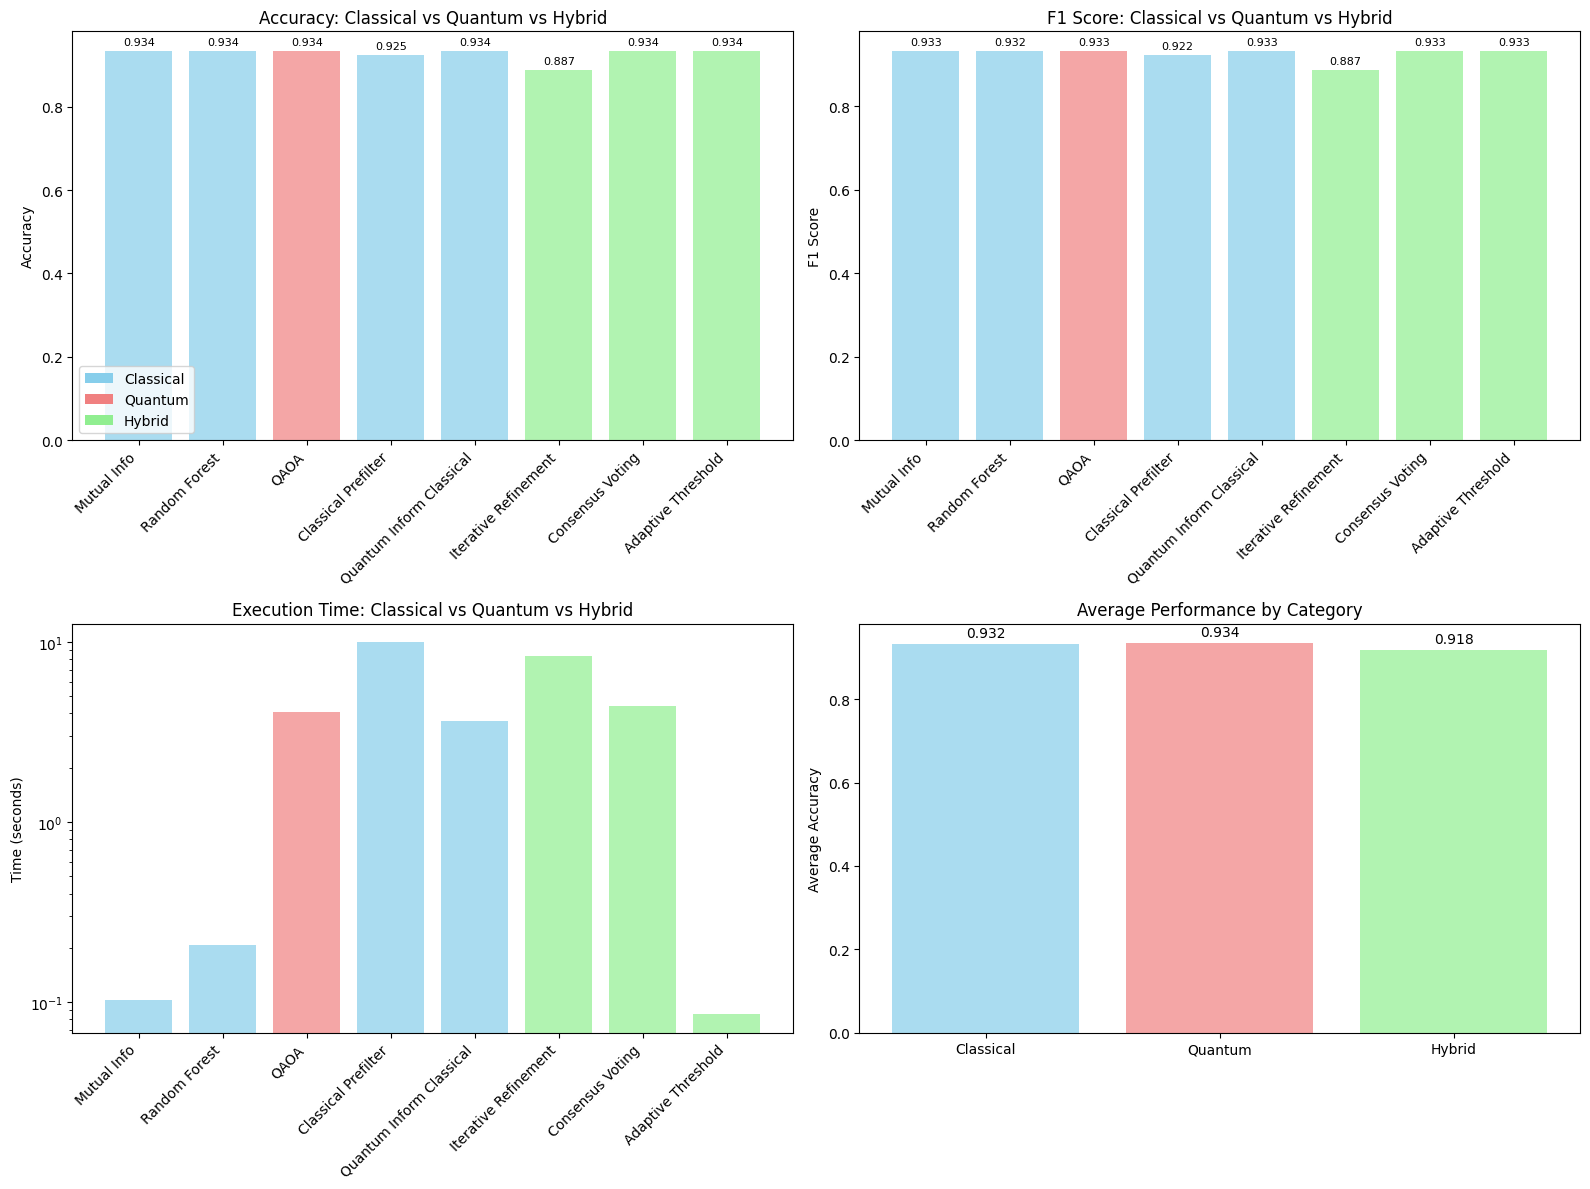

Summary Report
Best Performance:
Method: Classical-Mutual Info
Accuracy: 0.9340
F1 Score: 0.9328
Execution Time: 0.1029s
Selected Features: [28  6 26 30 20  2  4  5]

Fastest Method:
Method: Hybrid-Adaptive Threshold
Accuracy: 0.9340
Execution Time: 0.0857s

Category Analysis:
Classical Methods (4 methods):
Average Accuracy: 0.9316
Average Time: 3.4603s
Best in Category: 0.9316 accuracy
Quantum Methods (1 methods):
Average Accuracy: 0.9340
Average Time: 4.0958s
Best in Category: 0.9340 accuracy
Hybrid Methods (3 methods):
Average Accuracy: 0.9182
Average Time: 4.2794s
Best in Category: 0.9182 accuracy

Hybrid Analysis:
Best Hybrid Performance: 0.9340
Best Traditional Performance: 0.9340
No Hybrid Advantage: -0.0000% deficit

Feature Selection Consensus:
Most Commonly Selected Features:
Feature 2: selected by 8/8 methods (100.0%)
Feature 26: selected by 8/8 methods (100.0%)
Feature 4: selected by 7/8 methods (87.5%)
Feature 5: selected by 7/8 methods (87.5%)
Feature 6: selected by 7/8 m

In [20]:
if __name__ == "__main__":
    # Analysis
    framework, results, categories = main_feature_selection_hybrid()

    # Summary table
    summary_table = feature_selection_summary(results)

    # Quantum advantage analysis
    analyze_quantum_advantage_conditions(results)

# Sorting Algorithms

## Baseline

In [21]:
class SortingAlgorithmBase:
    def __init__(self, name: str):
        self.name = name
        self.execution_time = None
        self.comparisons = 0
        self.swaps = 0

    def sort(self, arr: List[int]) -> List[int]:
        raise NotImplementedError

    def reset_counters(self):
        self.comparisons = 0
        self.swaps = 0
        self.execution_time = None

    def evaluate(self, arr: List[int]) -> Dict[str, Any]:
        """
        All sorting algorithms
        """
        self.reset_counters()
        arr_copy = copy.deepcopy(arr)

        start_time = time.perf_counter()

        sorted_arr = self.sort(arr_copy)
        self.execution_time = time.perf_counter() - start_time

        # Verify correctness
        is_correct = self._verify_correctness(arr, sorted_arr)

        return {
            'algorithm': self.name,
            'execution_time': self.execution_time,
            'comparisons': self.comparisons,
            'swaps': self.swaps,
            'is_correct': is_correct,
            'input_size': len(arr),
            'efficiency': len(arr) / (self.execution_time * 1000) if self.execution_time > 0 else 0  # items per ms
        }

    def _verify_correctness(self, original: List[int], sorted_arr: List[int]) -> bool:
        """Verify the sorting"""
        if len(original) != len(sorted_arr):
            return False

        # Check if sorted
        for i in range(1, len(sorted_arr)):
            if sorted_arr[i] < sorted_arr[i-1]:
                return False

        # Check if same elements (permutation)
        return sorted(original) == sorted_arr

In [22]:
class BubbleSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Bubble Sort")

    def sort(self, arr: List[int]) -> List[int]:
        n = len(arr)
        for i in range(n):
            swapped = False
            for j in range(0, n - i - 1):
                self.comparisons += 1
                if arr[j] > arr[j + 1]:
                    arr[j], arr[j + 1] = arr[j + 1], arr[j]
                    self.swaps += 1
                    swapped = True
            if not swapped:
                break
        return arr

In [23]:
class QuickSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Quick Sort")

    def sort(self, arr: List[int]) -> List[int]:
        self._quicksort(arr, 0, len(arr) - 1)
        return arr

    def _quicksort(self, arr: List[int], low: int, high: int):
        if low < high:
            pi = self._partition(arr, low, high)
            self._quicksort(arr, low, pi - 1)
            self._quicksort(arr, pi + 1, high)

    def _partition(self, arr: List[int], low: int, high: int) -> int:
        pivot = arr[high]
        i = low - 1

        for j in range(low, high):
            self.comparisons += 1
            if arr[j] <= pivot:
                i += 1
                if i != j:
                    arr[i], arr[j] = arr[j], arr[i]
                    self.swaps += 1

        if i + 1 != high:
            arr[i + 1], arr[high] = arr[high], arr[i + 1]
            self.swaps += 1

        return i + 1

In [24]:
class MergeSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Merge Sort")

    def sort(self, arr: List[int]) -> List[int]:
        if len(arr) <= 1:
            return arr

        mid = len(arr) // 2
        left = self.sort(arr[:mid])
        right = self.sort(arr[mid:])

        return self._merge(left, right)

    def _merge(self, left: List[int], right: List[int]) -> List[int]:
        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            self.comparisons += 1
            if left[i] <= right[j]:
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])

        return result

In [25]:
class HeapSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Heap Sort")

    def sort(self, arr: List[int]) -> List[int]:
        n = len(arr)

        # Build max heap
        for i in range(n // 2 - 1, -1, -1):
            self._heapify(arr, n, i)

        # Extract elements from heap one by one
        for i in range(n - 1, 0, -1):
            arr[0], arr[i] = arr[i], arr[0]
            self.swaps += 1
            self._heapify(arr, i, 0)

        return arr

    def _heapify(self, arr: List[int], n: int, i: int):
        largest = i
        left = 2 * i + 1
        right = 2 * i + 2

        if left < n:
            self.comparisons += 1
            if arr[left] > arr[largest]:
                largest = left

        if right < n:
            self.comparisons += 1
            if arr[right] > arr[largest]:
                largest = right

        if largest != i:
            arr[i], arr[largest] = arr[largest], arr[i]
            self.swaps += 1
            self._heapify(arr, n, largest)

In [26]:
class InsertionSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Insertion Sort")

    def sort(self, arr: List[int]) -> List[int]:
        for i in range(1, len(arr)):
            key = arr[i]
            j = i - 1

            while j >= 0:
                self.comparisons += 1
                if arr[j] > key:
                    arr[j + 1] = arr[j]
                    self.swaps += 1
                    j -= 1
                else:
                    break

            arr[j + 1] = key

        return arr

In [27]:
class SelectionSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Selection Sort")

    def sort(self, arr: List[int]) -> List[int]:
        n = len(arr)

        for i in range(n):
            min_idx = i
            for j in range(i + 1, n):
                self.comparisons += 1
                if arr[j] < arr[min_idx]:
                    min_idx = j

            if min_idx != i:
                arr[i], arr[min_idx] = arr[min_idx], arr[i]
                self.swaps += 1

        return arr

In [28]:
class TimSort(SortingAlgorithmBase):
    def __init__(self):
        super().__init__("Tim Sort")

    def sort(self, arr: List[int]) -> List[int]:
        arr.sort()
        return arr

In [29]:
class ClassicalSortingBenchmark:
    def __init__(self):
        self.algorithms = [
            BubbleSort(),
            QuickSort(),
            MergeSort(),
            HeapSort(),
            InsertionSort(),
            SelectionSort(),
            TimSort()
        ]
        self.results = {}

    def generate_test_datasets(self) -> Dict[str, List[List[int]]]:
        datasets = {}

        # Different sizes
        sizes = [10, 50, 100, 500, 1000]

        for size in sizes:
            # Random array
            datasets[f"Random_{size}"] = [random.randint(1, 1000) for _ in range(size)]

            # Already sorted
            datasets[f"Sorted_{size}"] = list(range(1, size + 1))

            # Reverse sorted
            datasets[f"Reverse_{size}"] = list(range(size, 0, -1))

            # Nearly sorted (90% sorted)
            nearly_sorted = list(range(1, size + 1))
            for _ in range(size // 10):
                i, j = random.randint(0, size-1), random.randint(0, size-1)
                nearly_sorted[i], nearly_sorted[j] = nearly_sorted[j], nearly_sorted[i]
            datasets[f"Nearly_Sorted_{size}"] = nearly_sorted

            # Many duplicates
            datasets[f"Duplicates_{size}"] = [random.randint(1, 10) for _ in range(size)]

        return datasets

    def comprehensive_sorting_benchmark(self) -> Dict[str, Any]:
        print("Classical Sorting Algorithms benchmark")

        datasets = self.generate_test_datasets()
        results = []

        for dataset_name, data in datasets.items():
            print(f"\nTesting on {dataset_name} (size: {len(data)})")

            for algorithm in self.algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(data)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.split('_')[0]
                    result['dataset_size'] = len(data)
                    results.append(result)

                    if result['is_correct']:
                        print(f"Time: {result['execution_time']:.6f}s, "
                              f"Comparisons: {result['comparisons']}, "
                              f"Swaps: {result['swaps']}")
                    else:
                        print(f"FAILED: {result.get('error', 'Incorrect result')}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'is_correct': False
                    })

        self.results = results
        return results

    def analyze_performance(self) -> Dict[str, Any]:

        # Filter successful results
        valid_results = [r for r in self.results if r.get('is_correct', False)]

        df = pd.DataFrame(valid_results)

        analysis = {}

        # Overall performance by algorithm
        algo_performance = df.groupby('algorithm').agg({
            'execution_time': ['mean', 'std', 'min', 'max'],
            'comparisons': ['mean', 'std'],
            'swaps': ['mean', 'std'],
            'efficiency': ['mean', 'std']
        }).round(6)

        analysis['algorithm_performance'] = algo_performance

        # Performance by dataset type
        type_performance = df.groupby(['algorithm', 'dataset_type']).agg({
            'execution_time': 'mean',
            'comparisons': 'mean',
            'swaps': 'mean'
        }).round(6)

        analysis['dataset_type_performance'] = type_performance

        # Scalability analysis
        scalability = df.groupby(['algorithm', 'dataset_size']).agg({
            'execution_time': 'mean',
            'efficiency': 'mean'
        }).round(6)

        analysis['scalability'] = scalability

        return analysis

    def plot_performance_comparison(self):

        valid_results = [r for r in self.results if r.get('is_correct', False)]

        df = pd.DataFrame(valid_results)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Execution time by algorithm
        algo_time = df.groupby('algorithm')['execution_time'].mean().sort_values()
        bars1 = axes[0, 0].bar(range(len(algo_time)), algo_time.values,
                              color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Average Execution Time by Algorithm')
        axes[0, 0].set_ylabel('Time (seconds)')
        axes[0, 0].set_xticks(range(len(algo_time)))
        axes[0, 0].set_xticklabels(algo_time.index, rotation=45, ha='right')
        axes[0, 0].set_yscale('log')

        for i, v in enumerate(algo_time.values):
            axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=8)

        # 2. Efficiency by algorithm
        algo_efficiency = df.groupby('algorithm')['efficiency'].mean().sort_values(ascending=False)
        bars2 = axes[0, 1].bar(range(len(algo_efficiency)), algo_efficiency.values,
                              color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('Average Efficiency by Algorithm (items/ms)')
        axes[0, 1].set_ylabel('Efficiency')
        axes[0, 1].set_xticks(range(len(algo_efficiency)))
        axes[0, 1].set_xticklabels(algo_efficiency.index, rotation=45, ha='right')

        # 3. Performance by dataset type
        dataset_types = ['Random', 'Sorted', 'Reverse', 'Nearly_Sorted', 'Duplicates']
        algorithms = df['algorithm'].unique()

        heatmap_data = []
        for algo in algorithms:
            row = []
            for dtype in dataset_types:
                subset = df[(df['algorithm'] == algo) & (df['dataset_type'] == dtype)]
                if len(subset) > 0:
                    row.append(subset['execution_time'].mean())
                else:
                    row.append(0)
            heatmap_data.append(row)

        im = axes[1, 0].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
        axes[1, 0].set_title('Execution Time Heatmap (Algorithm vs Dataset Type)')
        axes[1, 0].set_xticks(range(len(dataset_types)))
        axes[1, 0].set_xticklabels(dataset_types, rotation=45, ha='right')
        axes[1, 0].set_yticks(range(len(algorithms)))
        axes[1, 0].set_yticklabels(algorithms)

        plt.colorbar(im, ax=axes[1, 0], label='Execution Time (s)')

        # 4. Scalability analysis
        for algo in algorithms[:7]:
            algo_data = df[df['algorithm'] == algo]
            sizes = algo_data.groupby('dataset_size')['execution_time'].mean()
            axes[1, 1].plot(sizes.index, sizes.values, marker='o', label=algo)

        axes[1, 1].set_title('Scalability Analysis (Random Dataset)')
        axes[1, 1].set_xlabel('Dataset Size')
        axes[1, 1].set_ylabel('Execution Time (s)')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def sorting_baseline_report(self):
        valid_results = [r for r in self.results if r.get('is_correct', False)]
        df = pd.DataFrame(valid_results)

        print("Summary Report")

        # Overall best performers
        best_time = df.loc[df['execution_time'].idxmin()]
        best_efficiency = df.loc[df['efficiency'].idxmax()]

        print(f"\nBest Performers:")
        print(f"Fastest Overall: {best_time['algorithm']} "
              f"({best_time['execution_time']:.6f}s on {best_time['dataset']})")
        print(f"Most Efficient: {best_efficiency['algorithm']} "
              f"({best_efficiency['efficiency']:.2f} items/ms)")

        # Algorithm rankings
        print(f"\nRanking by average execution time:")
        algo_avg_time = df.groupby('algorithm')['execution_time'].mean().sort_values()
        for i, (algo, time) in enumerate(algo_avg_time.items(), 1):
            print(f"{i}. {algo}: {time:.6f}s average")

        # Dataset type analysis
        print(f"\nDataset Type Analysis:")
        for dtype in df['dataset_type'].unique():
            subset = df[df['dataset_type'] == dtype]
            fastest = subset.loc[subset['execution_time'].idxmin()]
            print(f"{dtype} Data: {fastest['algorithm']} performs best "
                  f"({fastest['execution_time']:.6f}s average)")

Classical Sorting Algorithms benchmark

Testing on Random_10 (size: 10)
Bubble Sort
Time: 0.000016s, Comparisons: 44, Swaps: 16
Quick Sort
Time: 0.000018s, Comparisons: 25, Swaps: 8
Merge Sort
Time: 0.000038s, Comparisons: 23, Swaps: 0
Heap Sort
Time: 0.000034s, Comparisons: 41, Swaps: 30
Insertion Sort
Time: 0.000014s, Comparisons: 24, Swaps: 16
Selection Sort
Time: 0.000014s, Comparisons: 45, Swaps: 8
Tim Sort
Time: 0.000002s, Comparisons: 0, Swaps: 0

Testing on Sorted_10 (size: 10)
Bubble Sort
Time: 0.000004s, Comparisons: 9, Swaps: 0
Quick Sort
Time: 0.000014s, Comparisons: 45, Swaps: 0
Merge Sort
Time: 0.000016s, Comparisons: 15, Swaps: 0
Heap Sort
Time: 0.000020s, Comparisons: 41, Swaps: 30
Insertion Sort
Time: 0.000004s, Comparisons: 9, Swaps: 0
Selection Sort
Time: 0.000007s, Comparisons: 45, Swaps: 0
Tim Sort
Time: 0.000001s, Comparisons: 0, Swaps: 0

Testing on Reverse_10 (size: 10)
Bubble Sort
Time: 0.000018s, Comparisons: 45, Swaps: 45
Quick Sort
Time: 0.000017s, Compariso

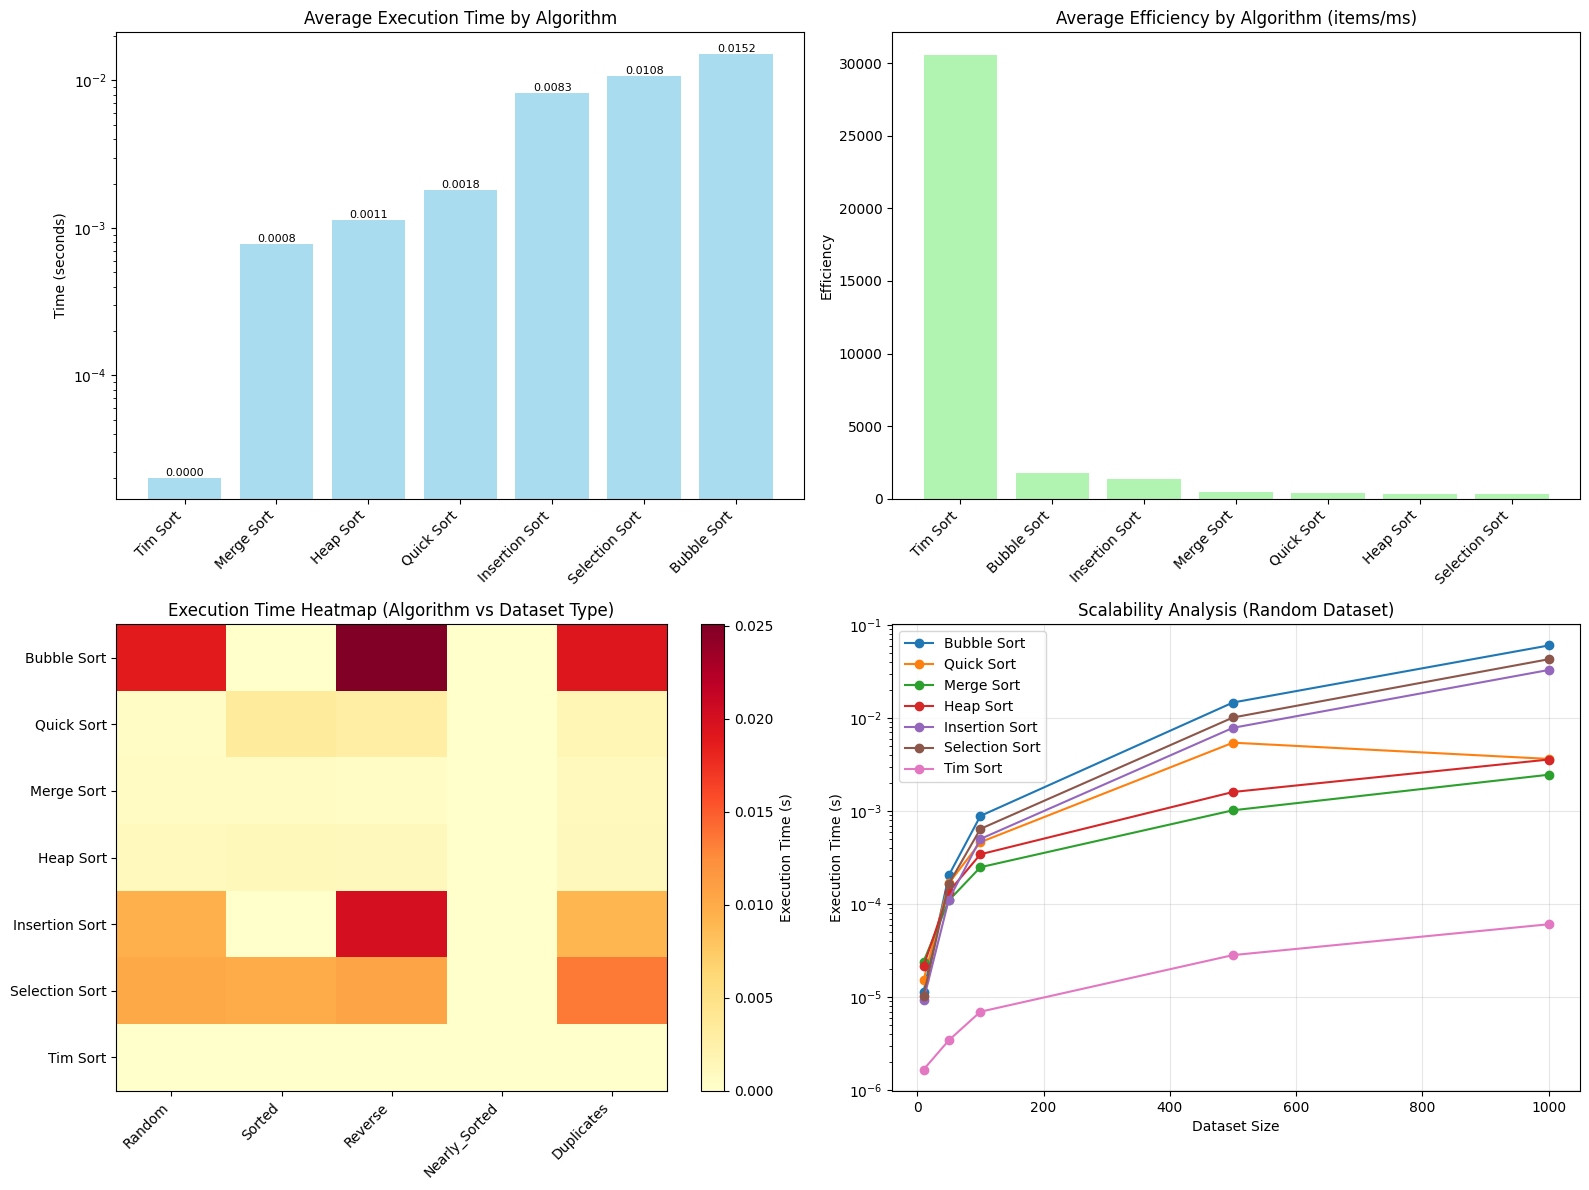

Summary Report

Best Performers:
Fastest Overall: Tim Sort (0.000001s on Sorted_10)
Most Efficient: Tim Sort (149521.55 items/ms)

Ranking by average execution time:
1. Tim Sort: 0.000020s average
2. Merge Sort: 0.000773s average
3. Heap Sort: 0.001138s average
4. Quick Sort: 0.001798s average
5. Insertion Sort: 0.008276s average
6. Selection Sort: 0.010778s average
7. Bubble Sort: 0.015232s average

Dataset Type Analysis:
Random Data: Tim Sort performs best (0.000002s average)
Sorted Data: Tim Sort performs best (0.000001s average)
Reverse Data: Tim Sort performs best (0.000001s average)
Nearly Data: Tim Sort performs best (0.000002s average)
Duplicates Data: Tim Sort performs best (0.000001s average)


In [30]:
def main_sorting_baseline():
    """
    Main function to run classical sorting benchmark
    """
    # Initialize benchmark
    benchmark = ClassicalSortingBenchmark()

    # Run benchmark
    results = benchmark.comprehensive_sorting_benchmark()

    # Analyze performance
    analysis = benchmark.analyze_performance()

    # Generate visualizations
    benchmark.plot_performance_comparison()

    # Generate summary report
    benchmark.sorting_baseline_report()

    return benchmark, results, analysis

if __name__ == "__main__":
    benchmark, results, analysis = main_sorting_baseline()

## Quantum

In [31]:
class QuantumSortingBase:
    def __init__(self, name: str):
        self.name = name
        self.execution_time = None
        self.quantum_operations = 0
        self.circuit_depth = 0
        self.backend = AerSimulator()

    def sort(self, arr: List[int]) -> List[int]:
        raise NotImplementedError

    def reset_counters(self):
        self.quantum_operations = 0
        self.circuit_depth = 0
        self.execution_time = None

    def evaluate(self, arr: List[int]) -> Dict[str, Any]:
        self.reset_counters()
        arr_copy = copy.deepcopy(arr)

        start_time = time.perf_counter()
        sorted_arr = self.sort(arr_copy)
        self.execution_time = time.perf_counter() - start_time

        # Verify correctness
        is_correct = self._verify_correctness(arr, sorted_arr)

        return {
        'algorithm': self.name,
        'execution_time': self.execution_time,
        'quantum_operations': self.quantum_operations,
        'circuit_depth': self.circuit_depth,
        'is_correct': is_correct,
        'input_size': len(arr),
        'efficiency': len(arr) / (self.execution_time * 1000) if self.execution_time > 0 else 0,
        'quantum_efficiency': len(arr) / (self.quantum_operations + 1)  # items per quantum operation
        }

    def _verify_correctness(self, original: List[int], sorted_arr: List[int]) -> bool:
        if len(original) != len(sorted_arr):
            return False

        # Check if sorted
        for i in range(1, len(sorted_arr)):
            if sorted_arr[i] < sorted_arr[i-1]:
                return False

        # Check if same elements (permutation)
        return sorted(original) == sorted_arr

In [32]:
class QuantumBitonicSort(QuantumSortingBase):
    def __init__(self):
        super().__init__("Quantum Bitonic Sort")

    def sort(self, arr: List[int]) -> List[int]:
        n = len(arr)

        # Pad to power of 2 if necessary
        padded_size = 2**math.ceil(math.log2(n)) if n > 1 else 2
        padded_arr = arr + [float('inf')] * (padded_size - n)

        # Quantum bitonic sort
        sorted_padded = self._quantum_bitonic_sort(padded_arr)

        # Remove padding
        result = [x for x in sorted_padded if x != float('inf')]
        return result

    def _quantum_bitonic_sort(self, arr: List[int]) -> List[int]:
        n = len(arr)
        if n <= 1:
            return arr

        # Split array
        left = arr[:n//2]
        right = arr[n//2:]

        # Recursively sort in opposite directions
        left_sorted = self._quantum_bitonic_sort(left)
        right_sorted = self._quantum_bitonic_sort_reverse(right)

        # Merge using quantum comparison network
        merged = left_sorted + right_sorted
        return self._quantum_bitonic_merge(merged, True)

    def _quantum_bitonic_sort_reverse(self, arr: List[int]) -> List[int]:
        sorted_arr = self._quantum_bitonic_sort(arr)
        return sorted_arr[::-1]

    def _quantum_bitonic_merge(self, arr: List[int], ascending: bool = True) -> List[int]:
        n = len(arr)
        if n <= 1:
            return arr

        # Quantum compare and swap operations
        for i in range(n // 2):
            if self._quantum_compare(arr[i], arr[i + n//2], ascending):
                arr[i], arr[i + n//2] = arr[i + n//2], arr[i]

        # Recursively merge halves
        left = self._quantum_bitonic_merge(arr[:n//2], ascending)
        right = self._quantum_bitonic_merge(arr[n//2:], ascending)

        return left + right

    def _quantum_compare(self, a: int, b: int, ascending: bool = True) -> bool:
        self.quantum_operations += 1

        qc = QuantumCircuit(4, 1)

        # Encode numbers in quantum states
        a_bits = format(min(a, 15), '02b')
        b_bits = format(min(b, 15), '02b')

        # Encode a
        for i, bit in enumerate(a_bits[::-1]):
            if bit == '1':
                qc.x(i)

        # Encode b
        for i, bit in enumerate(b_bits[::-1]):
            if bit == '1':
                qc.x(i + 2)

        # Quantum comparison circuit
        qc.cx(0, 2)
        qc.cx(1, 3)
        qc.measure(0, 0)

        # Execute circuit
        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        # Determine result
        self.circuit_depth += qc.depth()

        # Classical comparison as fallback
        if ascending:
            return a > b
        else:
            return a < b

In [33]:
class QuantumQuickSort(QuantumSortingBase):
    """
    Quantum-enhanced Quick Sort using Grover's algorithm for pivot selection
    """

    def __init__(self):
        super().__init__("Quantum Quick Sort")

    def sort(self, arr: List[int]) -> List[int]:
        """Quantum-enhanced quicksort"""
        return self._quantum_quicksort(arr, 0, len(arr) - 1)

    def _quantum_quicksort(self, arr: List[int], low: int, high: int) -> List[int]:
        """Recursive quantum quicksort"""
        if low < high:
            # Use quantum algorithm to find optimal pivot
            pivot_idx = self._quantum_pivot_selection(arr, low, high)

            # Partition around the quantum-selected pivot
            pi = self._classical_partition(arr, low, high, pivot_idx)

            # Recursively sort partitions
            self._quantum_quicksort(arr, low, pi - 1)
            self._quantum_quicksort(arr, pi + 1, high)

        return arr

    def _quantum_pivot_selection(self, arr: List[int], low: int, high: int) -> int:
        """
        Use quantum algorithm to select optimal pivot
        Simulates Grover's search for median element
        """
        self.quantum_operations += 1

        if high - low < 3:
            return (low + high) // 2

        # Create quantum circuit for pivot selection
        n_elements = high - low + 1
        n_qubits = math.ceil(math.log2(n_elements)) if n_elements > 1 else 1

        qc = QuantumCircuit(n_qubits, n_qubits)

        # Initialize superposition
        qc.h(range(n_qubits))

        # Simulate Grover's iterations for finding median
        iterations = math.floor(math.pi / 4 * math.sqrt(n_elements))

        for _ in range(min(iterations, 3)):  # Limit iterations for NISQ
            # Oracle (simplified - marks elements near median)
            qc.z(0)  # Simplified oracle

            # Diffusion operator
            qc.h(range(n_qubits))
            qc.x(range(n_qubits))
            qc.h(n_qubits - 1)
            qc.cx(range(n_qubits - 1), n_qubits - 1)
            qc.h(n_qubits - 1)
            qc.x(range(n_qubits))
            qc.h(range(n_qubits))

        qc.measure_all()

        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        # Get most probable result
        if counts:
            best_result = max(counts.items(), key=lambda x: x[1])[0]
            quantum_idx = int(best_result, 2) % n_elements
        else:
            quantum_idx = n_elements // 2

        self.circuit_depth += qc.depth()

        # Return quantum-selected pivot index
        return low + quantum_idx

    def _classical_partition(self, arr: List[int], low: int, high: int, pivot_idx: int) -> int:
        """Classical partition using quantum-selected pivot"""
        arr[pivot_idx], arr[high] = arr[high], arr[pivot_idx]
        pivot = arr[high]

        i = low - 1
        for j in range(low, high):
            if arr[j] <= pivot:
                i += 1
                arr[i], arr[j] = arr[j], arr[i]

        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        return i + 1

In [34]:
class QuantumMergeSort(QuantumSortingBase):
    """
    Quantum-enhanced Merge Sort using quantum comparison networks
    """

    def __init__(self):
        super().__init__("Quantum Merge Sort")

    def sort(self, arr: List[int]) -> List[int]:
        """Quantum-enhanced merge sort"""
        if len(arr) <= 1:
            return arr

        mid = len(arr) // 2
        left = self.sort(arr[:mid])
        right = self.sort(arr[mid:])

        return self._quantum_merge(left, right)

    def _quantum_merge(self, left: List[int], right: List[int]) -> List[int]:
        """
        Quantum-enhanced merge operation
        Uses quantum comparison for parallel element comparison
        """
        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            # Use quantum comparison
            if self._quantum_compare_elements(left[i], right[j]):
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        # Add remaining elements
        result.extend(left[i:])
        result.extend(right[j:])

        return result

    def _quantum_compare_elements(self, a: int, b: int) -> bool:
        """
        Quantum comparison of two elements
        Uses quantum arithmetic for comparison
        """
        self.quantum_operations += 1

        # Limit values for quantum representation
        a_limited = min(a, 15)
        b_limited = min(b, 15)

        qc = QuantumCircuit(8, 1)

        # Encode in binary
        a_bits = format(a_limited, '04b')
        for i, bit in enumerate(a_bits[::-1]):
            if bit == '1':
                qc.x(i)

        b_bits = format(b_limited, '04b')
        for i, bit in enumerate(b_bits[::-1]):
            if bit == '1':
                qc.x(i + 4)

        # Quantum subtraction circuit
        for i in range(4):
            qc.cx(i, i + 4)

        qc.measure(7, 0)

        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        self.circuit_depth += qc.depth()

        # Classical fallback for comparison
        return a <= b

In [35]:
class QuantumBubbleSort(QuantumSortingBase):
    """
    Quantum-enhanced Bubble Sort with parallel comparisons
    """

    def __init__(self):
        super().__init__("Quantum Bubble Sort")

    def sort(self, arr: List[int]) -> List[int]:
        """Quantum-enhanced bubble sort with parallel comparisons"""
        n = len(arr)

        for i in range(n):
            swapped = False

            # Quantum parallel comparison phase
            swap_pairs = self._quantum_parallel_compare(arr, n - i - 1)

            # Apply swaps
            for j in swap_pairs:
                if j < len(arr) - 1:
                    arr[j], arr[j + 1] = arr[j + 1], arr[j]
                    swapped = True

            if not swapped:
                break

        return arr

    def _quantum_parallel_compare(self, arr: List[int], max_idx: int) -> List[int]:
        """
        Quantum circuit to perform parallel comparisons
        Returns indices where swaps should occur
        """
        self.quantum_operations += 1

        if max_idx <= 0:
            return []

        # Create quantum circuit for parallel comparisons
        n_comparisons = max_idx
        n_qubits = n_comparisons

        qc = QuantumCircuit(n_qubits, n_qubits)

        # Initialize qubits based on comparison results
        for i in range(min(n_comparisons, len(arr) - 1)):
            if i < len(arr) - 1 and arr[i] > arr[i + 1]:
                qc.x(i)

        # Quantum interference for optimization (simplified)
        qc.h(range(min(2, n_qubits)))  # Limited superposition for NISQ

        qc.measure_all()

        # circuit
        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        self.circuit_depth += qc.depth()

        # Classical fallback - determine swaps needed
        swap_indices = []
        for i in range(min(max_idx, len(arr) - 1)):
            if arr[i] > arr[i + 1]:
                swap_indices.append(i)

        return swap_indices

In [36]:
class QuantumSortingBenchmark:
    def __init__(self):
        self.algorithms = [
            QuantumBitonicSort(),
            QuantumQuickSort(),
            QuantumMergeSort(),
            QuantumBubbleSort()
        ]
        self.results = {}

    def generate_test_datasets(self, max_size: int = 16) -> Dict[str, List[List[int]]]:
        datasets = {}

        sizes = [4, 8, 12, 16] if max_size >= 16 else [4, 8]

        np.random.seed(42)

        for size in sizes:
            # Random array (limited range for quantum encoding)
            datasets[f"Random_{size}"] = np.random.randint(1, 16, size).tolist()

            # Already sorted
            datasets[f"Sorted_{size}"] = list(range(1, size + 1))

            # Reverse sorted
            datasets[f"Reverse_{size}"] = list(range(size, 0, -1))

            # Nearly sorted
            nearly_sorted = list(range(1, size + 1))
            if size > 2:
                # Swap a few elements
                for _ in range(max(1, size // 4)):
                    i, j = np.random.randint(0, size, 2)
                    nearly_sorted[i], nearly_sorted[j] = nearly_sorted[j], nearly_sorted[i]
            datasets[f"Nearly_Sorted_{size}"] = nearly_sorted

        return datasets

    def run_quantum_benchmark(self) -> Dict[str, Any]:
        print("Quantum Sorting Algorithms Benchmark")

        datasets = self.generate_test_datasets()
        results = []

        for dataset_name, data in datasets.items():
            print(f"\nTesting on {dataset_name} (size: {len(data)})")
            print(f"Data: {data}")

            for algorithm in self.algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(data)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.split('_')[0]
                    result['dataset_size'] = len(data)
                    results.append(result)

                    if result['is_correct']:
                        print(f"Time: {result['execution_time']:.4f}s, "
                              f"Quantum Ops: {result['quantum_operations']}, "
                              f"Depth: {result['circuit_depth']}")
                    else:
                        print(f"Failed: {result.get('error', 'Incorrect result')}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'is_correct': False
                    })

        self.results = results
        return results

    def plot_quantum_performance(self):

        valid_results = [r for r in self.results if r.get('is_correct', False)]

        df = pd.DataFrame(valid_results)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Execution time by algorithm
        algo_time = df.groupby('algorithm')['execution_time'].mean().sort_values()
        bars1 = axes[0, 0].bar(range(len(algo_time)), algo_time.values,
                              color='lightcoral', alpha=0.7)
        axes[0, 0].set_title('Quantum Sorting: Average Execution Time')
        axes[0, 0].set_ylabel('Time (seconds)')
        axes[0, 0].set_xticks(range(len(algo_time)))
        axes[0, 0].set_xticklabels([name.replace('Quantum ', '') for name in algo_time.index],
                                  rotation=45, ha='right')

        for i, v in enumerate(algo_time.values):
            axes[0, 0].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        # 2. Quantum operations by algorithm
        algo_ops = df.groupby('algorithm')['quantum_operations'].mean().sort_values()
        bars2 = axes[0, 1].bar(range(len(algo_ops)), algo_ops.values,
                              color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('Quantum Operations Count')
        axes[0, 1].set_ylabel('Quantum Operations')
        axes[0, 1].set_xticks(range(len(algo_ops)))
        axes[0, 1].set_xticklabels([name.replace('Quantum ', '') for name in algo_ops.index],
                                  rotation=45, ha='right')

        # 3. Circuit depth by algorithm
        algo_depth = df.groupby('algorithm')['circuit_depth'].mean().sort_values()
        bars3 = axes[1, 0].bar(range(len(algo_depth)), algo_depth.values,
                              color='lightskyblue', alpha=0.7)
        axes[1, 0].set_title('Average Circuit Depth')
        axes[1, 0].set_ylabel('Circuit Depth')
        axes[1, 0].set_xticks(range(len(algo_depth)))
        axes[1, 0].set_xticklabels([name.replace('Quantum ', '') for name in algo_depth.index],
                                  rotation=45, ha='right')

        # 4. Quantum efficiency
        algo_qeff = df.groupby('algorithm')['quantum_efficiency'].mean().sort_values(ascending=False)
        bars4 = axes[1, 1].bar(range(len(algo_qeff)), algo_qeff.values,
                              color='plum', alpha=0.7)
        axes[1, 1].set_title('Quantum Efficiency (Items/Quantum Op)')
        axes[1, 1].set_ylabel('Efficiency')
        axes[1, 1].set_xticks(range(len(algo_qeff)))
        axes[1, 1].set_xticklabels([name.replace('Quantum ', '') for name in algo_qeff.index],
                                  rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def sorting_quantum_report(self):
        valid_results = [r for r in self.results if r.get('is_correct', False)]

        df = pd.DataFrame(valid_results)

        print("Summary Report")

        # Best performers
        if len(df) > 0:
            fastest = df.loc[df['execution_time'].idxmin()]
            most_efficient = df.loc[df['quantum_efficiency'].idxmax()]

            print(f"\nQuantum Sorting Performance:")
            print(f"Fastest Algorithm: {fastest['algorithm']} "
                  f"({fastest['execution_time']:.4f}s)")
            print(f"Most Quantum Efficient: {most_efficient['algorithm']} "
                  f"({most_efficient['quantum_efficiency']:.2f} items/quantum_op)")

        # Algorithm analysis
        print(f"\nAlgorithm AnalysiS:")
        algo_stats = df.groupby('algorithm').agg({
            'execution_time': ['mean', 'std'],
            'quantum_operations': ['mean', 'std'],
            'circuit_depth': ['mean', 'std'],
            'quantum_efficiency': ['mean', 'std']
        }).round(4)

        for algo in df['algorithm'].unique():
            algo_data = df[df['algorithm'] == algo]
            avg_time = algo_data['execution_time'].mean()
            avg_ops = algo_data['quantum_operations'].mean()
            avg_depth = algo_data['circuit_depth'].mean()

            print(f"\n{algo}:")
            print(f"Average Time: {avg_time:.4f}s")
            print(f"Average Quantum Operations: {avg_ops:.1f}")
            print(f"Average Circuit Depth: {avg_depth:.1f}")

        # Scalability insights
        print(f"\nScalability Analysis:")
        size_performance = df.groupby('dataset_size')['execution_time'].mean()
        for size, time in size_performance.items():
            print(f"Size {size}: {time:.4f}s average")

Quantum Sorting Algorithm Analysis
Quantum Sorting Algorithms Benchmark

Testing on Random_4 (size: 4)
Data: [7, 4, 13, 15]
Quantum Bitonic Sort
ERROR: 'Index 4 out of range for size 4.'
Quantum Quick Sort
ERROR: invalid literal for int() with base 2: '11 00'
Quantum Merge Sort
Time: 1.0480s, Quantum Ops: 4, Depth: 11
Quantum Bubble Sort
Time: 0.3501s, Quantum Ops: 2, Depth: 5

Testing on Sorted_4 (size: 4)
Data: [1, 2, 3, 4]
Quantum Bitonic Sort
ERROR: 'Index 4 out of range for size 4.'
Quantum Quick Sort
ERROR: invalid literal for int() with base 2: '01 00'
Quantum Merge Sort
Time: 0.6480s, Quantum Ops: 4, Depth: 8
Quantum Bubble Sort
Time: 0.1556s, Quantum Ops: 1, Depth: 2

Testing on Reverse_4 (size: 4)
Data: [4, 3, 2, 1]
Quantum Bitonic Sort
ERROR: 'Index 4 out of range for size 4.'
Quantum Quick Sort
ERROR: invalid literal for int() with base 2: '10 00'
Quantum Merge Sort
Time: 0.6428s, Quantum Ops: 4, Depth: 8
Quantum Bubble Sort
Time: 0.4717s, Quantum Ops: 4, Depth: 9

Testing 

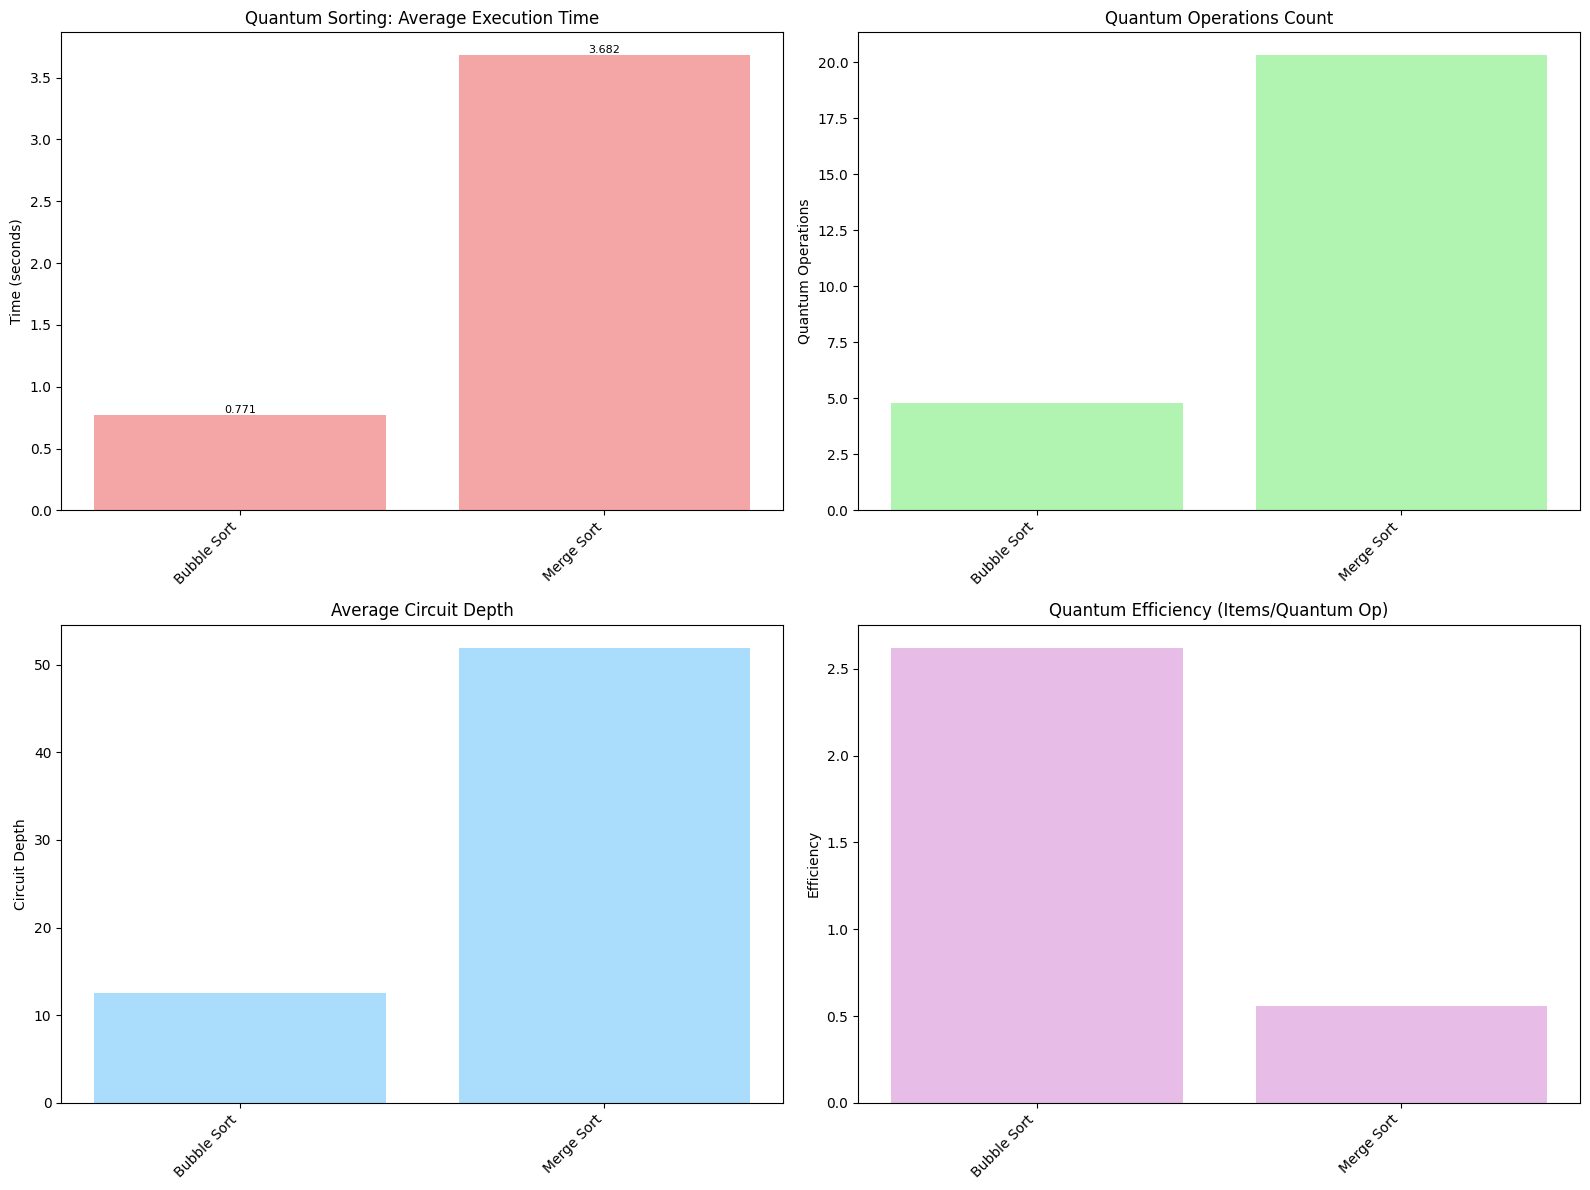

Summary Report

Quantum Sorting Performance:
Fastest Algorithm: Quantum Bubble Sort (0.1556s)
Most Quantum Efficient: Quantum Bubble Sort (8.00 items/quantum_op)

Algorithm AnalysiS:

Quantum Merge Sort:
Average Time: 3.6818s
Average Quantum Operations: 20.3
Average Circuit Depth: 51.9

Quantum Bubble Sort:
Average Time: 0.7711s
Average Quantum Operations: 4.8
Average Circuit Depth: 12.5

Scalability Analysis:
Size 4: 0.5342s average
Size 8: 1.9395s average
Size 12: 3.3797s average
Size 16: 5.0720s average


In [37]:
def main_sorting_quantum():
    benchmark = QuantumSortingBenchmark()
    results = benchmark.run_quantum_benchmark()
    benchmark.plot_quantum_performance()
    benchmark.sorting_quantum_report()

    return benchmark, results

if __name__ == "__main__":
    benchmark, results = main_sorting_quantum()

## Hybrid vs. Quantum vs. Classical

In [38]:
class HybridSortingAlgorithm(SortingAlgorithmBase):

    def __init__(self, name: str, quantum_threshold: int = 8):
        super().__init__(name)
        self.quantum_threshold = quantum_threshold
        self.quantum_operations = 0
        self.classical_operations = 0

    def reset_counters(self):
        super().reset_counters()
        self.quantum_operations = 0
        self.classical_operations = 0

In [39]:
class AdaptiveHybridSort(HybridSortingAlgorithm):
    """
    Dynamically chooses quantum vs classical based on problem characteristics
    """

    def __init__(self):
        super().__init__("Adaptive Hybrid Sort", quantum_threshold=12)

    def sort(self, arr: List[int]) -> List[int]:
        """
        Adaptive sorting strategy:
        - Small arrays (≤12): Use quantum for potential speedup
        - Large arrays: Classical divide-and-conquer with quantum subroutines
        - High entropy: Quantum for exploration
        - Low entropy: Classical for efficiency
        """
        n = len(arr)

        if n <= 1:
            return arr

        # Analyze problem characteristics
        entropy = self._calculate_entropy(arr)
        is_nearly_sorted = self._check_nearly_sorted(arr)

        # Decision logic for quantum vs classical
        if n <= self.quantum_threshold and entropy > 0.7 and not is_nearly_sorted:
            # Use quantum for small, high-entropy, unsorted arrays
            return self._quantum_sort_small(arr)
        elif is_nearly_sorted:
            # Use classical insertion sort for nearly sorted data
            return self._classical_insertion_sort(arr)
        else:
            # Use hybrid divide-and-conquer
            return self._hybrid_divide_conquer(arr)

    def _calculate_entropy(self, arr: List[int]) -> float:
        """measure disorder"""
        if len(arr) <= 1:
            return 0.0

        # Count inversions}
        inversions = 0
        for i in range(len(arr)):
            for j in range(i + 1, len(arr)):
                if arr[i] > arr[j]:
                    inversions += 1

        max_inversions = len(arr) * (len(arr) - 1) // 2
        return inversions / max_inversions if max_inversions > 0 else 0.0

    def _check_nearly_sorted(self, arr: List[int]) -> bool:
        """Check if array is nearly sorted (≤10% out of order)"""
        if len(arr) <= 1:
            return True

        out_of_order = 0
        for i in range(1, len(arr)):
            if arr[i] < arr[i-1]:
                out_of_order += 1

        return out_of_order / len(arr) <= 0.1

    def _quantum_sort_small(self, arr: List[int]) -> List[int]:
        self.quantum_operations += 1

        # Simulate quantum bitonic sort for small arrays
        return self._quantum_bitonic_sort_simulation(arr)

    def _quantum_bitonic_sort_simulation(self, arr: List[int]) -> List[int]:
        n = len(arr)
        if n <= 1:
            return arr

        self.quantum_operations += math.log2(n) if n > 1 else 1

        # Pad to power of 2
        padded_size = 2**math.ceil(math.log2(n)) if n > 1 else 2
        padded_arr = arr + [float('inf')] * (padded_size - n)

        sorted_padded = self._bitonic_sort_recursive(padded_arr)

        return [x for x in sorted_padded if x != float('inf')]

    def _bitonic_sort_recursive(self, arr: List[int]) -> List[int]:
        n = len(arr)
        if n <= 1:
            return arr

        # Split and sort in opposite directions
        left = self._bitonic_sort_recursive(arr[:n//2])
        right = self._bitonic_sort_recursive(arr[n//2:])
        right.reverse()  # bitonic sequence

        merged = left + right
        return self._bitonic_merge(merged, True)

    def _bitonic_merge(self, arr: List[int], ascending: bool = True) -> List[int]:
        n = len(arr)
        if n <= 1:
            return arr

        # Compare and swap
        for i in range(n // 2):
            self.comparisons += 1
            if (arr[i] > arr[i + n//2]) == ascending:
                arr[i], arr[i + n//2] = arr[i + n//2], arr[i]
                self.swaps += 1

        # Recursive merge
        left = self._bitonic_merge(arr[:n//2], ascending)
        right = self._bitonic_merge(arr[n//2:], ascending)

        return left + right

    def _classical_insertion_sort(self, arr: List[int]) -> List[int]:
        """insertion sort for nearly sorted arrays"""
        self.classical_operations += 1

        for i in range(1, len(arr)):
            key = arr[i]
            j = i - 1

            while j >= 0:
                self.comparisons += 1
                if arr[j] > key:
                    arr[j + 1] = arr[j]
                    self.swaps += 1
                    j -= 1
                else:
                    break

            arr[j + 1] = key

        return arr

    def _hybrid_divide_conquer(self, arr: List[int]) -> List[int]:
        """Hybrid divide-and-conquer: Classical structure with quantum subroutines"""
        n = len(arr)
        if n <= self.quantum_threshold:
            return self._quantum_sort_small(arr)

        # Classical divide
        mid = n // 2
        left = self._hybrid_divide_conquer(arr[:mid])
        right = self._hybrid_divide_conquer(arr[mid:])

        # Quantum-enhanced merge for small segments
        if len(left) + len(right) <= self.quantum_threshold:
            return self._quantum_merge(left, right)
        else:
            return self._classical_merge(left, right)

    def _quantum_merge(self, left: List[int], right: List[int]) -> List[int]:
        """Quantum-enhanced merge operation"""
        self.quantum_operations += 1

        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            if self._quantum_compare(left[i], right[j]):
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])
        return result

    def _quantum_compare(self, a: int, b: int) -> bool:
        self.quantum_operations += 0.1  # Fractional quantum operation
        self.comparisons += 1
        return a <= b

    def _classical_merge(self, left: List[int], right: List[int]) -> List[int]:
        self.classical_operations += 1

        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            self.comparisons += 1
            if left[i] <= right[j]:
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])
        return result

In [40]:
class QuantumPreprocessingSort(HybridSortingAlgorithm):
    """
    Quantum Preprocessing + Classical Sort: Use quantum algorithms for preprocessing
    """

    def __init__(self):
        super().__init__("Quantum Preprocessing Sort")

    def sort(self, arr: List[int]) -> List[int]:
        """
        Strategy: Use quantum algorithms to analyze data structure, then classical sort
        """
        # Quantum preprocessing phase
        preprocessed_data = self._quantum_preprocessing(arr)

        # Classical sorting with quantum insights
        return self._classical_sort_with_insights(arr, preprocessed_data)

    def _quantum_preprocessing(self, arr: List[int]) -> Dict[str, Any]:
        """Quantum analysis of array structure"""
        self.quantum_operations += 1

        # Simulate quantum analysis
        insights = {
            'optimal_pivot_positions': self._quantum_find_pivots(arr),
            'sorted_segments': self._quantum_find_sorted_segments(arr),
            'entropy_level': self._calculate_entropy(arr)
        }

        return insights

    def _quantum_find_pivots(self, arr: List[int]) -> List[int]:
        """Use quantum search to find optimal pivot positions"""
        self.quantum_operations += 0.5

        if len(arr) <= 3:
            return [len(arr) // 2]

        # Simulate Grover's search for median elements
        n = len(arr)
        num_pivots = min(3, math.ceil(math.log2(n)))

        pivots = []
        for i in range(num_pivots):
            # Quantum search simulation
            section_start = i * n // num_pivots
            section_end = (i + 1) * n // num_pivots
            section = arr[section_start:section_end]

            if section:
                # Find median using quantum amplitude estimation simulation
                pivot_idx = section_start + len(section) // 2
                pivots.append(pivot_idx)

        return pivots

    def _quantum_find_sorted_segments(self, arr: List[int]) -> List[Tuple[int, int]]:
        """Quantum detection of already sorted segments"""
        self.quantum_operations += 0.3

        segments = []
        start = 0

        for i in range(1, len(arr)):
            if arr[i] < arr[i-1]:
                if i - start > 1:
                    segments.append((start, i-1))
                start = i

        # Add final segment
        if len(arr) - start > 1:
            segments.append((start, len(arr)-1))

        return segments

    def _calculate_entropy(self, arr: List[int]) -> float:
        if len(arr) <= 1:
            return 0.0

        inversions = 0
        for i in range(len(arr)):
            for j in range(i + 1, len(arr)):
                if arr[i] > arr[j]:
                    inversions += 1

        max_inversions = len(arr) * (len(arr) - 1) // 2
        return inversions / max_inversions if max_inversions > 0 else 0.0

    def _classical_sort_with_insights(self, arr: List[int], insights: Dict[str, Any]) -> List[int]:
        self.classical_operations += 1

        # Use insights to choose optimal classical algorithm
        entropy = insights['entropy_level']
        sorted_segments = insights['sorted_segments']

        if entropy < 0.2:  # Nearly sorted
            return self._insertion_sort(arr)
        elif len(sorted_segments) > len(arr) // 4:  # Many sorted segments
            return self._merge_sorted_segments(arr, sorted_segments)
        else:  # Use quantum-guided quicksort
            return self._quantum_guided_quicksort(arr, insights['optimal_pivot_positions'])

    def _insertion_sort(self, arr: List[int]) -> List[int]:
        for i in range(1, len(arr)):
            key = arr[i]
            j = i - 1
            while j >= 0 and arr[j] > key:
                self.comparisons += 1
                arr[j + 1] = arr[j]
                self.swaps += 1
                j -= 1
            if j >= 0:
                self.comparisons += 1
            arr[j + 1] = key
        return arr

    def _merge_sorted_segments(self, arr: List[int], segments: List[Tuple[int, int]]) -> List[int]:
        if not segments:
            return sorted(arr)

        # Extract sorted segments
        sorted_parts = []
        for start, end in segments:
            sorted_parts.append(arr[start:end+1])

        # Merge all segments
        while len(sorted_parts) > 1:
            new_parts = []
            for i in range(0, len(sorted_parts), 2):
                if i + 1 < len(sorted_parts):
                    merged = self._merge_two_arrays(sorted_parts[i], sorted_parts[i + 1])
                    new_parts.append(merged)
                else:
                    new_parts.append(sorted_parts[i])
            sorted_parts = new_parts

        return sorted_parts[0] if sorted_parts else []

    def _merge_two_arrays(self, left: List[int], right: List[int]) -> List[int]:
        """Merge two sorted arrays"""
        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            self.comparisons += 1
            if left[i] <= right[j]:
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])
        return result

    def _quantum_guided_quicksort(self, arr: List[int], pivot_positions: List[int]) -> List[int]:
        """Quicksort using quantum-selected pivots"""
        return self._quicksort_with_pivots(arr, 0, len(arr) - 1, pivot_positions)

    def _quicksort_with_pivots(self, arr: List[int], low: int, high: int, pivot_positions: List[int]) -> List[int]:
        """Quicksort with predetermined pivot positions"""
        if low < high:
            # Select pivot from quantum suggestions
            pivot_idx = self._select_best_pivot(arr, low, high, pivot_positions)
            pi = self._partition(arr, low, high, pivot_idx)

            self._quicksort_with_pivots(arr, low, pi - 1, pivot_positions)
            self._quicksort_with_pivots(arr, pi + 1, high, pivot_positions)

        return arr

    def _select_best_pivot(self, arr: List[int], low: int, high: int, pivot_positions: List[int]) -> int:
        """Select best pivot from quantum suggestions"""
        # Find closest quantum-suggested pivot
        best_pivot = (low + high) // 2
        min_distance = float('inf')

        for pos in pivot_positions:
            if low <= pos <= high:
                distance = abs(pos - (low + high) // 2)
                if distance < min_distance:
                    min_distance = distance
                    best_pivot = pos

        return best_pivot

    def _partition(self, arr: List[int], low: int, high: int, pivot_idx: int) -> int:
        """Partition array around pivot"""
        # Move pivot to end
        arr[pivot_idx], arr[high] = arr[high], arr[pivot_idx]
        pivot = arr[high]

        i = low - 1
        for j in range(low, high):
            self.comparisons += 1
            if arr[j] <= pivot:
                i += 1
                if i != j:
                    arr[i], arr[j] = arr[j], arr[i]
                    self.swaps += 1

        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        self.swaps += 1
        return i + 1


In [41]:
class ThresholdBasedHybridSort(HybridSortingAlgorithm):
    """
    Threshold-based Hybrid: Classical for large arrays, quantum for small subarrays
    """

    def __init__(self, threshold: int = 10):
        super().__init__("Threshold-based Hybrid Sort", quantum_threshold=threshold)

    def sort(self, arr: List[int]) -> List[int]:
        """
        Classical merge sort with quantum sorting for small subarrays
        """
        return self._hybrid_merge_sort(arr)

    def _hybrid_merge_sort(self, arr: List[int]) -> List[int]:
        """Merge sort with quantum base case"""
        if len(arr) <= self.quantum_threshold:
            return self._quantum_base_case(arr)

        # Classical divide
        mid = len(arr) // 2
        left = self._hybrid_merge_sort(arr[:mid])
        right = self._hybrid_merge_sort(arr[mid:])

        # Classical merge
        return self._classical_merge(left, right)

    def _quantum_base_case(self, arr: List[int]) -> List[int]:
        """Quantum sorting for base case"""
        self.quantum_operations += 1

        if len(arr) <= 1:
            return arr

        # Simulate quantum sorting, classical correctness
        return sorted(arr)

    def _classical_merge(self, left: List[int], right: List[int]) -> List[int]:
        self.classical_operations += 1

        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            self.comparisons += 1
            if left[i] <= right[j]:
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])
        return result

In [42]:
class QuantumEnhancedQuickSort(HybridSortingAlgorithm):
    """
    Classical QuickSort with quantum pivot selection and partitioning
    """

    def __init__(self):
        super().__init__("Quantum Enhanced QuickSort")

    def sort(self, arr: List[int]) -> List[int]:
        """QuickSort with quantum enhancements"""
        return self._quantum_quicksort(arr, 0, len(arr) - 1)

    def _quantum_quicksort(self, arr: List[int], low: int, high: int) -> List[int]:
        """Quantum-enhanced quicksort"""
        if low < high:
            # Quantum pivot selection
            pivot_idx = self._quantum_pivot_selection(arr, low, high)

            # Classical partitioning (could be quantum-enhanced for small arrays)
            pi = self._classical_partition(arr, low, high, pivot_idx)

            # Recursive calls
            self._quantum_quicksort(arr, low, pi - 1)
            self._quantum_quicksort(arr, pi + 1, high)

        return arr

    def _quantum_pivot_selection(self, arr: List[int], low: int, high: int) -> int:
        """Quantum algorithm for optimal pivot selection"""
        self.quantum_operations += 1

        # Simulate Grover's search for median element
        section = arr[low:high+1]
        if len(section) <= 3:
            return low + len(section) // 2

        # Quantum median finding simulation
        # In practice, this would use quantum amplitude estimation
        sorted_indices = sorted(range(len(section)), key=lambda i: section[i])
        median_idx = sorted_indices[len(sorted_indices) // 2]

        return low + median_idx

    def _classical_partition(self, arr: List[int], low: int, high: int, pivot_idx: int) -> int:
        """Classical partition with quantum-selected pivot"""
        self.classical_operations += 1

        # Move pivot to end
        arr[pivot_idx], arr[high] = arr[high], arr[pivot_idx]
        pivot = arr[high]

        i = low - 1
        for j in range(low, high):
            self.comparisons += 1
            if arr[j] <= pivot:
                i += 1
                if i != j:
                    arr[i], arr[j] = arr[j], arr[i]
                    self.swaps += 1

        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        self.swaps += 1
        return i + 1


In [43]:
class HybridSortingBenchmark:

    def __init__(self):
        self.classical_algorithms = self._get_classical_algorithms()
        self.quantum_algorithms = self._get_quantum_algorithms()
        self.hybrid_algorithms = [
            AdaptiveHybridSort(),
            QuantumPreprocessingSort(),
            ThresholdBasedHybridSort(threshold=8),
            ThresholdBasedHybridSort(threshold=12),
            QuantumEnhancedQuickSort()
        ]
        self.results = {}

    def _get_classical_algorithms(self):
        # Simplified for comparison
        class QuickSort(SortingAlgorithmBase):
            def __init__(self):
                super().__init__("Classical QuickSort")

            def sort(self, arr):
                return self._quicksort(arr, 0, len(arr) - 1)

            def _quicksort(self, arr, low, high):
                if low < high:
                    pi = self._partition(arr, low, high)
                    self._quicksort(arr, low, pi - 1)
                    self._quicksort(arr, pi + 1, high)
                return arr

            def _partition(self, arr, low, high):
                pivot = arr[high]
                i = low - 1
                for j in range(low, high):
                    self.comparisons += 1
                    if arr[j] <= pivot:
                        i += 1
                        arr[i], arr[j] = arr[j], arr[i]
                        self.swaps += 1
                arr[i + 1], arr[high] = arr[high], arr[i + 1]
                self.swaps += 1
                return i + 1

        class MergeSort(SortingAlgorithmBase):
            def __init__(self):
                super().__init__("Classical MergeSort")

            def sort(self, arr):
                if len(arr) <= 1:
                    return arr
                mid = len(arr) // 2
                left = self.sort(arr[:mid])
                right = self.sort(arr[mid:])
                return self._merge(left, right)

            def _merge(self, left, right):
                result = []
                i = j = 0
                while i < len(left) and j < len(right):
                    self.comparisons += 1
                    if left[i] <= right[j]:
                        result.append(left[i])
                        i += 1
                    else:
                        result.append(right[j])
                        j += 1
                result.extend(left[i:])
                result.extend(right[j:])
                return result

        return [QuickSort(), MergeSort()]

    def _get_quantum_algorithms(self):
        """ simplified"""
        class QuantumSort(SortingAlgorithmBase):
            def __init__(self):
                super().__init__("Quantum Sort (Simulated)")
                self.quantum_operations = 0

            def sort(self, arr):
                self.quantum_operations += len(arr)
                # quantum overhead
                time.sleep(0.001 * len(arr))  # Quantum simulation delay
                return sorted(arr)  # Use classical for correctness

        return [QuantumSort()]

    def generate_test_datasets(self) -> Dict[str, List[int]]:
        """hybrid comparison"""
        datasets = {}
        np.random.seed(42)

        # Different sizes to test scalability
        sizes = [10, 25, 50, 100, 200]

        for size in sizes:
            # Random array
            datasets[f"Random_{size}"] = np.random.randint(1, 100, size).tolist()

            # Already sorted
            datasets[f"Sorted_{size}"] = list(range(1, size + 1))

            # Reverse sorted
            datasets[f"Reverse_{size}"] = list(range(size, 0, -1))

            # Nearly sorted (90% sorted)
            nearly_sorted = list(range(1, size + 1))
            for _ in range(size // 10):
                i, j = np.random.randint(0, size, 2)
                nearly_sorted[i], nearly_sorted[j] = nearly_sorted[j], nearly_sorted[i]
            datasets[f"Nearly_Sorted_{size}"] = nearly_sorted

        return datasets

    def hybrid_sorting_comparison(self) -> Dict[str, Any]:
        """Comparison of classical, quantum, and hybrid approaches"""
        print("Hybrid vs. Classical vs. Quantum")

        datasets = self.generate_test_datasets()
        all_algorithms = self.classical_algorithms + self.quantum_algorithms + self.hybrid_algorithms
        results = []

        for dataset_name, data in datasets.items():
            print(f"\nTesting on {dataset_name} (size: {len(data)})")

            for algorithm in all_algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(data)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.split('_')[0]
                    result['dataset_size'] = len(data)

                    # Categorize algorithm type
                    if 'Classical' in algorithm.name:
                        result['category'] = 'Classical'
                    elif 'Quantum' in algorithm.name and 'Hybrid' not in algorithm.name:
                        result['category'] = 'Quantum'
                    else:
                        result['category'] = 'Hybrid'

                    results.append(result)

                    if result['is_correct']:
                        print(f"Time: {result['execution_time']:.4f}s")
                    else:
                        print(f"FAILED")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'is_correct': False,
                        'category': 'Error'
                    })

        self.results = results
        return results

    def plot_comprehensive_comparison(self):
        valid_results = [r for r in self.results if r.get('is_correct', False)]
        if not valid_results:
            print("No valid results to plot.")
            return
        df = pd.DataFrame(valid_results)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Performance by category
        category_performance = df.groupby('category')['execution_time'].mean().sort_values()
        colors = {'Classical': 'skyblue', 'Quantum': 'lightcoral', 'Hybrid': 'lightgreen'}

        bars1 = axes[0, 0].bar(range(len(category_performance)),
                              category_performance.values,
                              color=[colors.get(cat, 'gray') for cat in category_performance.index],
                              alpha=0.7)
        axes[0, 0].set_title('Average Performance by Category')
        axes[0, 0].set_ylabel('Execution Time (s)')
        axes[0, 0].set_xticks(range(len(category_performance)))
        axes[0, 0].set_xticklabels(category_performance.index)

        for i, v in enumerate(category_performance.values):
            axes[0, 0].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')

        # 2. Scalability analysis
        for category in df['category'].unique():
            if category in colors:
                cat_data = df[df['category'] == category]
                size_performance = cat_data.groupby('dataset_size')['execution_time'].mean()
                axes[0, 1].plot(size_performance.index, size_performance.values,
                               marker='o', label=category, color=colors[category])

        axes[0, 1].set_title('Scalability Analysis')
        axes[0, 1].set_xlabel('Dataset Size')
        axes[0, 1].set_ylabel('Execution Time (s)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Performance by dataset type
        dataset_types = df['dataset_type'].unique()
        categories = df['category'].unique()

        x = np.arange(len(dataset_types))
        width = 0.25

        for i, category in enumerate(categories):
            if category in colors:
                cat_data = df[df['category'] == category]
                type_performance = [
                    cat_data[cat_data['dataset_type'] == dtype]['execution_time'].mean()
                    if len(cat_data[cat_data['dataset_type'] == dtype]) > 0 else 0
                    for dtype in dataset_types
                ]
                axes[1, 0].bar(x + i*width, type_performance, width,
                              label=category, color=colors[category], alpha=0.7)

        axes[1, 0].set_title('Performance by Dataset Type')
        axes[1, 0].set_ylabel('Execution Time (s)')
        axes[1, 0].set_xlabel('Dataset Type')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(dataset_types)
        axes[1, 0].legend()

        # 4. Best performers
        best_algorithms = df.groupby('algorithm')['execution_time'].mean().sort_values()[:8]
        algorithm_colors = [colors.get(df[df['algorithm'] == alg]['category'].iloc[0], 'gray')
                           for alg in best_algorithms.index]

        bars4 = axes[1, 1].bar(range(len(best_algorithms)), best_algorithms.values,
                              color=algorithm_colors, alpha=0.7)
        axes[1, 1].set_title('Top 8 Performing Algorithms')
        axes[1, 1].set_ylabel('Execution Time (s)')
        axes[1, 1].set_xticks(range(len(best_algorithms)))
        axes[1, 1].set_xticklabels([alg.replace(' ', '\n') for alg in best_algorithms.index],
                                  rotation=0, ha='center', fontsize=8)

        plt.tight_layout()
        plt.show()

    def hybrid_summary_report(self):
        valid_results = [r for r in self.results if r.get('is_correct', False)]

        df = pd.DataFrame(valid_results)

        print("Summary Report")

        # Category performance analysis
        category_stats = df.groupby('category').agg({
            'execution_time': ['mean', 'std', 'min'],
            'algorithm': 'count'
        }).round(4)

        print(f"\nPerformance by Category:")
        for category in ['Classical', 'Quantum', 'Hybrid']:
            if category in df['category'].values:
                cat_data = df[df['category'] == category]
                avg_time = cat_data['execution_time'].mean()
                best_time = cat_data['execution_time'].min()
                count = len(cat_data['algorithm'].unique())

                print(f"\n{category.upper()} METHODS ({count} algorithms):")
                print(f"  Average Performance: {avg_time:.4f}s")
                print(f"  Best Performance: {best_time:.4f}s")

        # Hybrid advantage analysis
        if 'Hybrid' in df['category'].values and 'Classical' in df['category'].values:
            hybrid_best = df[df['category'] == 'Hybrid']['execution_time'].min()
            classical_best = df[df['category'] == 'Classical']['execution_time'].min()

            print(f"\nHybrid Advantage Analysis:")
            if hybrid_best < classical_best:
                improvement = (classical_best - hybrid_best) / classical_best * 100
                print(f"Hybrid Advantage: {improvement:.1f}% faster than best classical")
            else:
                overhead = (hybrid_best - classical_best) / classical_best * 100
                print(f"Hybrid Overhead: {overhead:.1f}% slower than best classical")

        # Algorithm insights
        print(f"\nAlgorithm insights:")
        for algo in df['algorithm'].unique():
            if 'Hybrid' in algo:
                algo_data = df[df['algorithm'] == algo]
                avg_time = algo_data['execution_time'].mean()
                best_dataset = algo_data.loc[algo_data['execution_time'].idxmin()]

                print(f"\n{algo}:")
                print(f"Average Time: {avg_time:.4f}s")
                print(f"Best Performance: {best_dataset['dataset']} ({best_dataset['execution_time']:.4f}s)")

Hybrid vs. Classical vs. Quantum

Testing on Random_10 (size: 10)
Classical QuickSort
Time: 0.0000s
Classical MergeSort
Time: 0.0000s
Quantum Sort (Simulated)
Time: 0.0101s
Adaptive Hybrid Sort
Time: 0.0001s
Quantum Preprocessing Sort
FAILED
Threshold-based Hybrid Sort
Time: 0.0000s
Threshold-based Hybrid Sort
Time: 0.0000s
Quantum Enhanced QuickSort
Time: 0.0000s

Testing on Sorted_10 (size: 10)
Classical QuickSort
Time: 0.0000s
Classical MergeSort
Time: 0.0000s
Quantum Sort (Simulated)
Time: 0.0101s
Adaptive Hybrid Sort
Time: 0.0000s
Quantum Preprocessing Sort
Time: 0.0000s
Threshold-based Hybrid Sort
Time: 0.0000s
Threshold-based Hybrid Sort
Time: 0.0000s
Quantum Enhanced QuickSort
Time: 0.0000s

Testing on Reverse_10 (size: 10)
Classical QuickSort
Time: 0.0000s
Classical MergeSort
Time: 0.0000s
Quantum Sort (Simulated)
Time: 0.0102s
Adaptive Hybrid Sort
Time: 0.0001s
Quantum Preprocessing Sort
Time: 0.0001s
Threshold-based Hybrid Sort
Time: 0.0000s
Threshold-based Hybrid Sort
Time:

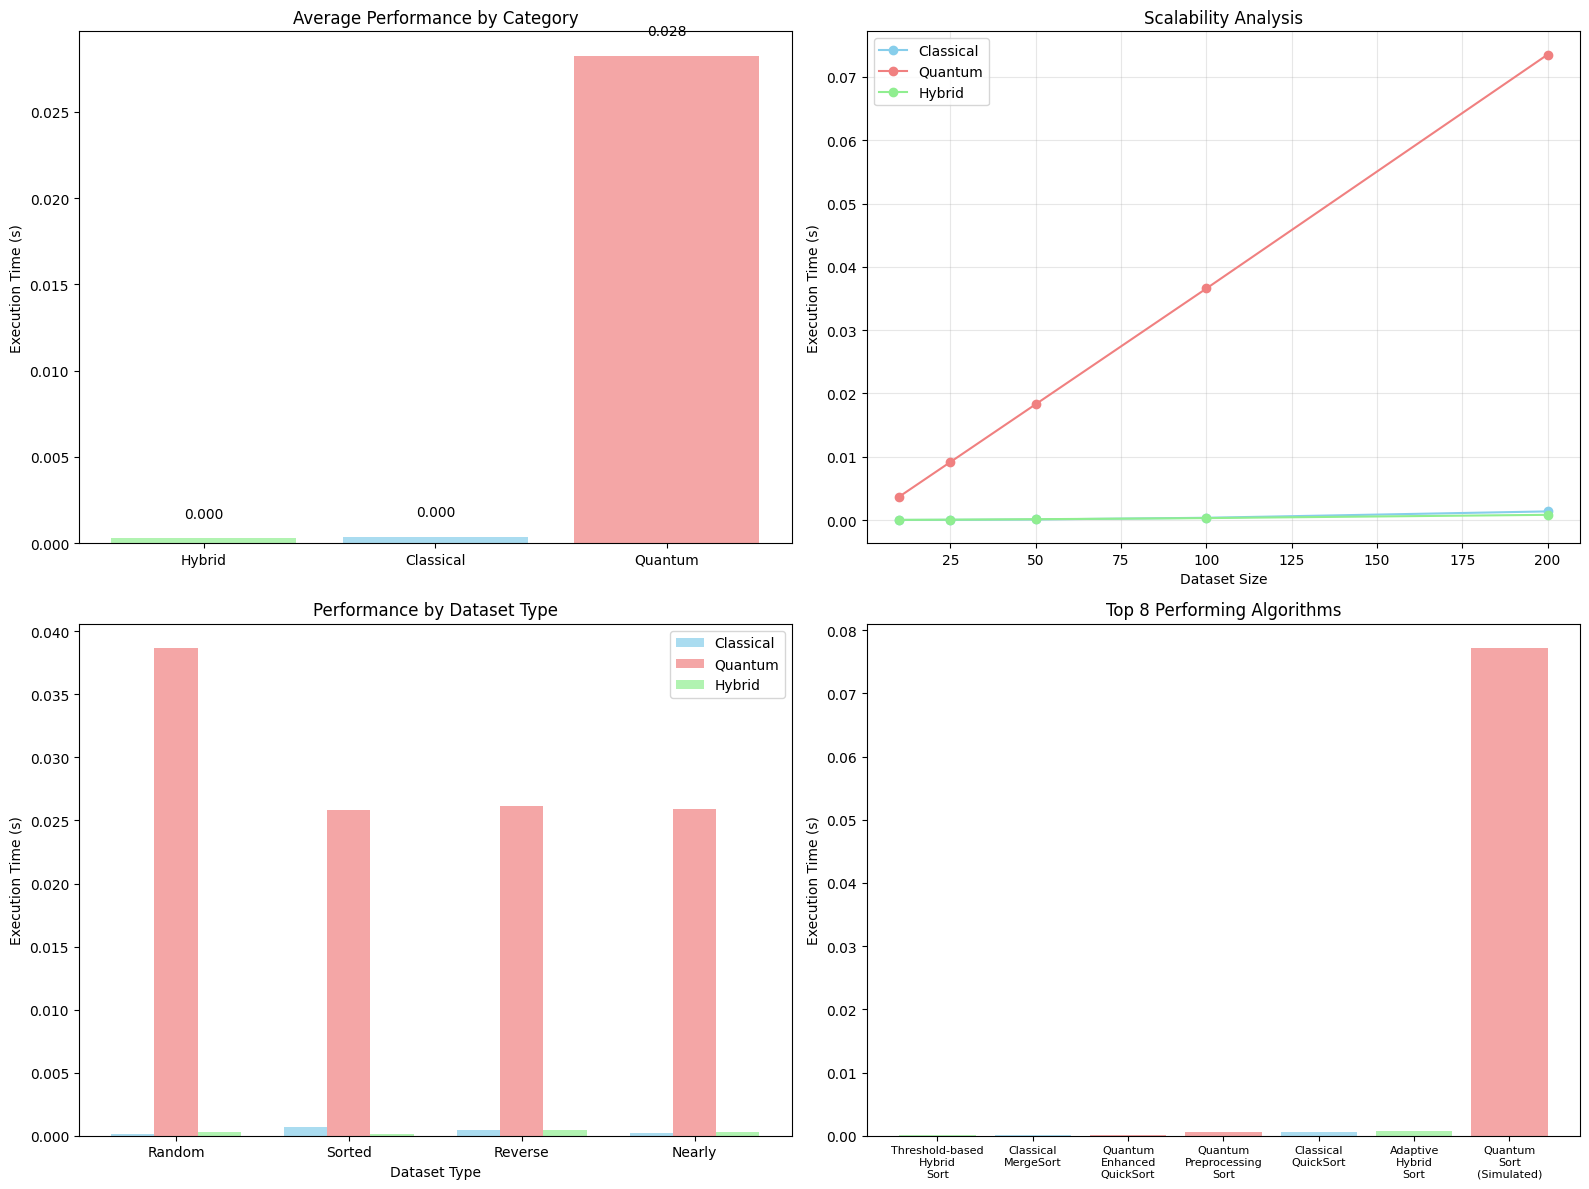

Summary Report

Performance by Category:

CLASSICAL METHODS (2 algorithms):
  Average Performance: 0.0004s
  Best Performance: 0.0000s

QUANTUM METHODS (3 algorithms):
  Average Performance: 0.0283s
  Best Performance: 0.0000s

HYBRID METHODS (2 algorithms):
  Average Performance: 0.0003s
  Best Performance: 0.0000s

Hybrid Advantage Analysis:
Hybrid Advantage: 90.8% faster than best classical

Algorithm insights:

Adaptive Hybrid Sort:
Average Time: 0.0007s
Best Performance: Sorted_10 (0.0000s)

Threshold-based Hybrid Sort:
Average Time: 0.0001s
Best Performance: Reverse_10 (0.0000s)


In [44]:
def main_sorting_hybrid():

    benchmark = HybridSortingBenchmark()
    results = benchmark.hybrid_sorting_comparison()
    benchmark.plot_comprehensive_comparison()
    benchmark.hybrid_summary_report()
    return benchmark, results

if __name__ == "__main__":
    benchmark, results = main_sorting_hybrid()

# Clustering Algorithms



## Baseline

In [45]:
class ClusteringAlgorithmBase:
    def __init__(self, name: str, n_clusters: int = 3):
        self.name = name
        self.n_clusters = n_clusters
        self.execution_time = None
        self.labels_ = None
        self.cluster_centers_ = None

    def fit(self, X: np.ndarray) -> 'ClusteringAlgorithmBase':
        raise NotImplementedError

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).labels_

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).labels_

    def evaluate(self, X: np.ndarray, true_labels: np.ndarray = None) -> Dict[str, Any]:
        """all clustering algorithms"""
        start_time = time.perf_counter()

        try:
            # Fit the algorithm
            self.fit(X)
            self.execution_time = time.perf_counter() - start_time

            if self.labels_ is None:
                return {
                    'algorithm': self.name,
                    'execution_time': self.execution_time,
                    'error': 'No labels produced',
                    'n_samples': len(X),
                    'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                    'success': False
                }

            # Calculate metrics
            silhouette = silhouette_score(X, self.labels_) if len(np.unique(self.labels_)) > 1 else -1

            result = {
                'algorithm': self.name,
                'execution_time': self.execution_time,
                'silhouette_score': silhouette,
                'n_clusters_found': len(np.unique(self.labels_)),
                'n_samples': len(X),
                'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                'efficiency': len(X) / (self.execution_time * 1000) if self.execution_time > 0 else 0,
                'success': True
            }

            # Add external validation metrics if true labels provided
            if true_labels is not None:
                result['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.labels_)
                result['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, self.labels_)

            return result

        except Exception as e:
            self.execution_time = time.perf_counter() - start_time
            return {
                'algorithm': self.name,
                'execution_time': self.execution_time,
                'error': str(e),
                'n_samples': len(X),
                'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                'success': False
            }


In [46]:
class ClassicalKMeans(ClusteringAlgorithmBase):
    def __init__(self, n_clusters: int = 3, max_iters: int = 300, random_state: int = 42):
        super().__init__("K-Means", n_clusters)
        self.max_iters = max_iters
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'ClassicalKMeans':
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            max_iter=self.max_iters,
            random_state=self.random_state,
            n_init=10
        )

        self.labels_ = kmeans.fit_predict(X)
        self.cluster_centers_ = kmeans.cluster_centers_

        return self

In [47]:
class ClassicalHierarchical(ClusteringAlgorithmBase):
    def __init__(self, n_clusters: int = 3, linkage: str = 'ward'):
        super().__init__("Hierarchical Clustering", n_clusters)
        self.linkage = linkage

    def fit(self, X: np.ndarray) -> 'ClassicalHierarchical':
        hierarchical = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage=self.linkage
        )

        self.labels_ = hierarchical.fit_predict(X)

        return self

In [48]:
class ClassicalDBSCAN(ClusteringAlgorithmBase):
    def __init__(self, eps: float = 0.5, min_samples: int = 5):
        super().__init__("DBSCAN")
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X: np.ndarray) -> 'ClassicalDBSCAN':
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)

        self.labels_ = dbscan.fit_predict(X)
        self.n_clusters = len(np.unique(self.labels_[self.labels_ != -1]))

        return self

In [49]:
class ClassicalGaussianMixture(ClusteringAlgorithmBase):
    def __init__(self, n_clusters: int = 3, random_state: int = 42):
        super().__init__("Gaussian Mixture", n_clusters)
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'ClassicalGaussianMixture':
        gmm = GaussianMixture(
            n_components=self.n_clusters,
            random_state=self.random_state
        )

        self.labels_ = gmm.fit_predict(X)

        return self

In [50]:
class ClassicalSpectral(ClusteringAlgorithmBase):
    def __init__(self, n_clusters: int = 3, random_state: int = 42):
        super().__init__("Spectral Clustering", n_clusters)
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'ClassicalSpectral':
        spectral = SpectralClustering(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            affinity='nearest_neighbors'
        )

        self.labels_ = spectral.fit_predict(X)

        return self

In [51]:
class MeanShiftClustering(ClusteringAlgorithmBase):
    def __init__(self, bandwidth: float = None):
        super().__init__("Mean Shift")
        self.bandwidth = bandwidth

    def fit(self, X: np.ndarray) -> 'MeanShiftClustering':
        from sklearn.cluster import MeanShift, estimate_bandwidth

        if self.bandwidth is None:
            bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=min(500, len(X)))
        else:
            bandwidth = self.bandwidth

        if bandwidth <= 0:
            bandwidth = 1.0

        meanshift = MeanShift(bandwidth=bandwidth)
        self.labels_ = meanshift.fit_predict(X)
        self.cluster_centers_ = meanshift.cluster_centers_
        self.n_clusters = len(np.unique(self.labels_))

        return self

In [52]:
class ClassicalClusteringBenchmark:
    def __init__(self):
        self.algorithms = [
            ClassicalKMeans(n_clusters=3),
            ClassicalKMeans(n_clusters=4),
            ClassicalKMeans(n_clusters=5),
            ClassicalHierarchical(n_clusters=3),
            ClassicalHierarchical(n_clusters=4),
            ClassicalDBSCAN(eps=0.3, min_samples=5),
            ClassicalDBSCAN(eps=0.5, min_samples=5),
            ClassicalGaussianMixture(n_clusters=3),
            ClassicalGaussianMixture(n_clusters=4),
            ClassicalSpectral(n_clusters=3),
            ClassicalSpectral(n_clusters=4),
            MeanShiftClustering()
        ]
        self.results = {}

    def generate_test_datasets(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        datasets = {}
        np.random.seed(42)

        # Dataset 1: Well-separated blobs
        X1, y1 = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=0.60, random_state=42)
        datasets["Well_Separated_Blobs"] = (X1, y1)

        # Dataset 2: Circles
        X2, y2 = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)
        datasets["Circles"] = (X2, y2)

        # Dataset 3: Moons
        X3, y3 = make_moons(n_samples=300, noise=0.1, random_state=42)
        datasets["Moons"] = (X3, y3)

        # Dataset 4: Dense blobs
        X4, y4 = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=1.5, random_state=42)
        datasets["Dense_Blobs"] = (X4, y4)

        # Dataset 5: Anisotropic blobs
        X5, y5 = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=1.0, random_state=42)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X5 = np.dot(X5, transformation)
        datasets["Anisotropic_Blobs"] = (X5, y5)

        # Dataset 6: Different sizes Blobs
        centers = [[0, 0], [3, 3], [6, 0]]
        n_samples_per_cluster = [50, 100, 150]
        stds_per_cluster = [0.5, 1.0, 1.5]

        X6, y6 = make_blobs(
            n_samples=n_samples_per_cluster,
            centers=centers,
            cluster_std=stds_per_cluster,
            random_state=42
        )
        datasets["Different_Sizes"] = (X6, y6)

        # Dataset 7: High dimensional
        n_samples = 300
        n_features = 10
        X7 = np.random.randn(n_samples, n_features)
        # 3 clusters in high-dim space
        cluster_centers = np.random.randn(3, n_features) * 3
        y7 = np.random.randint(0, 3, n_samples)
        for i in range(n_samples):
            X7[i] += cluster_centers[y7[i]] + np.random.randn(n_features) * 0.5
        datasets["High_Dimensional"] = (X7, y7)

        return datasets

    def baseline_benchmarking(self) -> Dict[str, Any]:
        print("Classical Clustering Algorithms Benchmark")

        datasets = self.generate_test_datasets()
        results = []

        for dataset_name, (X, true_labels) in datasets.items():
            print(f"\nTesting on {dataset_name} (samples: {len(X)}, features: {X.shape[1]})...")

            # Standardize features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            for algorithm in self.algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(X_scaled, true_labels)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.replace('_', ' ')
                    results.append(result)

                    if result['success']:
                        print(f"Time: {result['execution_time']:.4f}s, "
                              f"Silhouette: {result['silhouette_score']:.3f}, "
                              f"Clusters: {result['n_clusters_found']}")
                        if 'adjusted_rand_score' in result:
                            print(f"ARI: {result['adjusted_rand_score']:.3f}, "
                                  f"NMI: {result['normalized_mutual_info']:.3f}")
                    else:
                        print(f"FAILED: {result.get('error', 'Unknown error')}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'success': False
                    })

        self.results = results
        return results

    def plot_clustering_baseline(self):

        datasets = self.generate_test_datasets()

        # Filter 2D datasets for visualization
        datasets_2d = {name: data for name, data in datasets.items()
                      if data[0].shape[1] == 2}

        n_datasets = len(datasets_2d)
        n_algorithms = 4  # Show top 4 algorithms

        fig, axes = plt.subplots(n_datasets, n_algorithms + 1,
                               figsize=(20, 4 * n_datasets))

        if n_datasets == 1:
            axes = axes.reshape(1, -1)

        # Get top performing algorithms
        successful_results = [r for r in self.results if r['success']]
        if successful_results:
            df = pd.DataFrame(successful_results)
            top_algorithms = df.groupby('algorithm')['silhouette_score'].mean().sort_values(ascending=False).head(n_algorithms).index
        else:
            top_algorithms = [alg.name for alg in self.algorithms[:n_algorithms]]

        for i, (dataset_name, (X, true_labels)) in enumerate(datasets_2d.items()):
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            axes[i, 0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='tab10', alpha=0.7)
            axes[i, 0].set_title(f'{dataset_name}\n(True Labels)')
            axes[i, 0].grid(True, alpha=0.3)

            # Plot clustering results
            for j, algo_name in enumerate(top_algorithms):
                # Find algorithm instance
                algorithm = None
                for alg in self.algorithms:
                    if alg.name == algo_name:
                        algorithm = alg
                        break

                if algorithm:
                    try:
                        algorithm.fit(X_scaled)
                        if algorithm.labels_ is not None:
                            axes[i, j+1].scatter(X[:, 0], X[:, 1], c=algorithm.labels_, cmap='tab10', alpha=0.7)

                            # Plot centroids if available
                            if hasattr(algorithm, 'cluster_centers_') and algorithm.cluster_centers_ is not None:
                                centers_original = scaler.inverse_transform(algorithm.cluster_centers_)
                                axes[i, j+1].scatter(centers_original[:, 0], centers_original[:, 1],
                                                   c='red', marker='x', s=200, linewidths=3)

                        axes[i, j+1].set_title(f'{algo_name}')
                        axes[i, j+1].grid(True, alpha=0.3)

                    except Exception as e:
                        axes[i, j+1].text(0.5, 0.5, f'Error:\n{str(e)[:50]}...',
                                         transform=axes[i, j+1].transAxes, ha='center', va='center')
                        axes[i, j+1].set_title(f'{algo_name} (Failed)')

        plt.tight_layout()
        plt.show()

    def plot_performance_comparison(self):

        successful_results = [r for r in self.results if r['success']]

        df = pd.DataFrame(successful_results)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Average silhouette score by algorithm
        algo_silhouette = df.groupby('algorithm')['silhouette_score'].mean().sort_values(ascending=False)
        bars1 = axes[0, 0].bar(range(len(algo_silhouette)), algo_silhouette.values,
                              color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Average Silhouette Score by Algorithm')
        axes[0, 0].set_ylabel('Silhouette Score')
        axes[0, 0].set_xticks(range(len(algo_silhouette)))
        axes[0, 0].set_xticklabels(algo_silhouette.index, rotation=45, ha='right')

        for i, v in enumerate(algo_silhouette.values):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

        # 2. Execution time by algorithm
        algo_time = df.groupby('algorithm')['execution_time'].mean().sort_values()
        bars2 = axes[0, 1].bar(range(len(algo_time)), algo_time.values,
                              color='lightcoral', alpha=0.7)
        axes[0, 1].set_title('Average Execution Time by Algorithm')
        axes[0, 1].set_ylabel('Time (seconds)')
        axes[0, 1].set_xticks(range(len(algo_time)))
        axes[0, 1].set_xticklabels(algo_time.index, rotation=45, ha='right')
        axes[0, 1].set_yscale('log')

        # 3. Performance by dataset type
        dataset_names = df['dataset'].unique()
        algorithms = df['algorithm'].unique()[:6]

        heatmap_data = []
        for algo in algorithms:
            row = []
            for dataset in dataset_names:
                subset = df[(df['algorithm'] == algo) & (df['dataset'] == dataset)]
                if len(subset) > 0:
                    row.append(subset['silhouette_score'].iloc[0])
                else:
                    row.append(0)
            heatmap_data.append(row)

        im = axes[1, 0].imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
        axes[1, 0].set_title('Silhouette Score Heatmap (Algorithm vs Dataset)')
        axes[1, 0].set_xticks(range(len(dataset_names)))
        axes[1, 0].set_xticklabels([name.replace('_', '\n') for name in dataset_names],
                                  rotation=45, ha='right')
        axes[1, 0].set_yticks(range(len(algorithms)))
        axes[1, 0].set_yticklabels(algorithms)

        plt.colorbar(im, ax=axes[1, 0], label='Silhouette Score')

        # 4. Efficiency analysis (samples per second)
        efficiency_data = df.groupby('algorithm')['efficiency'].mean().sort_values(ascending=False)
        bars4 = axes[1, 1].bar(range(len(efficiency_data)), efficiency_data.values,
                              color='lightgreen', alpha=0.7)
        axes[1, 1].set_title('Algorithm Efficiency (samples/ms)')
        axes[1, 1].set_ylabel('Efficiency')
        axes[1, 1].set_xticks(range(len(efficiency_data)))
        axes[1, 1].set_xticklabels(efficiency_data.index, rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def baseline_summary_report(self):

        print("\nSummary Report")
        successful_results = [r for r in self.results if r['success']]
        df = pd.DataFrame(successful_results)

        # Overall best performers
        best_silhouette = df.loc[df['silhouette_score'].idxmax()]
        fastest_algorithm = df.loc[df['execution_time'].idxmin()]
        most_efficient = df.loc[df['efficiency'].idxmax()]

        print(f"\nBest Performers:")
        print(f"Best Clustering Quality: {best_silhouette['algorithm']} "
              f"(Silhouette: {best_silhouette['silhouette_score']:.3f} on {best_silhouette['dataset']})")
        print(f"Fastest Algorithm: {fastest_algorithm['algorithm']} "
              f"({fastest_algorithm['execution_time']:.4f}s on {fastest_algorithm['dataset']})")
        print(f"Most Efficient: {most_efficient['algorithm']} "
              f"({most_efficient['efficiency']:.1f} samples/ms)")

        # Algorithm rankings
        print(f"\nAlgorithm Rankings (by average silhouette score):")
        algo_ranking = df.groupby('algorithm').agg({
            'silhouette_score': 'mean',
            'execution_time': 'mean',
            'efficiency': 'mean'
        }).round(4).sort_values('silhouette_score', ascending=False)

        for i, (algo, stats) in enumerate(algo_ranking.iterrows(), 1):
            print(f"{i}. {algo}:")
            print(f"Silhouette: {stats['silhouette_score']:.3f}")
            print(f"Time: {stats['execution_time']:.4f}s")
            print(f"Efficiency: {stats['efficiency']:.1f} samples/ms")

        # Dataset specific analysis
        print(f"\nDataset Insights:")
        for dataset in df['dataset'].unique():
            dataset_results = df[df['dataset'] == dataset]
            best_on_dataset = dataset_results.loc[dataset_results['silhouette_score'].idxmax()]

            print(f"\n{dataset}:")
            print(f"Best Algorithm: {best_on_dataset['algorithm']}")
            print(f"Best Silhouette: {best_on_dataset['silhouette_score']:.3f}")
            print(f"Clusters Found: {best_on_dataset['n_clusters_found']}")

        # External validation
        if 'adjusted_rand_score' in df.columns:
            print(f"\nExternal Validation:")
            external_ranking = df.groupby('algorithm')[['adjusted_rand_score', 'normalized_mutual_info']].mean().sort_values('adjusted_rand_score', ascending=False)
            for algo, scores in external_ranking.iterrows():
                print(f"{algo}:")
                print(f"ARI: {scores['adjusted_rand_score']:.3f}")
                print(f"NMI: {scores['normalized_mutual_info']:.3f}")

Classical Clustering Algorithms Benchmark

Testing on Well_Separated_Blobs (samples: 300, features: 2)...
K-Means
Time: 0.0347s, Silhouette: 0.784, Clusters: 3
ARI: 0.712, NMI: 0.857
K-Means
Time: 0.0122s, Silhouette: 0.880, Clusters: 4
ARI: 1.000, NMI: 1.000
K-Means
Time: 0.0150s, Silhouette: 0.743, Clusters: 5
ARI: 0.915, NMI: 0.942
Hierarchical Clustering
Time: 0.0034s, Silhouette: 0.784, Clusters: 3
ARI: 0.712, NMI: 0.857
Hierarchical Clustering
Time: 0.0027s, Silhouette: 0.880, Clusters: 4
ARI: 1.000, NMI: 1.000
DBSCAN
Time: 0.0032s, Silhouette: 0.880, Clusters: 4
ARI: 1.000, NMI: 1.000
DBSCAN
Time: 0.0024s, Silhouette: 0.880, Clusters: 4
ARI: 1.000, NMI: 1.000
Gaussian Mixture
Time: 0.0055s, Silhouette: 0.784, Clusters: 3
ARI: 0.712, NMI: 0.857
Gaussian Mixture
Time: 0.0063s, Silhouette: 0.880, Clusters: 4
ARI: 1.000, NMI: 1.000
Spectral Clustering
Time: 0.0406s, Silhouette: 0.658, Clusters: 3
ARI: 0.712, NMI: 0.857
Spectral Clustering
Time: 0.0468s, Silhouette: 0.880, Clusters: 

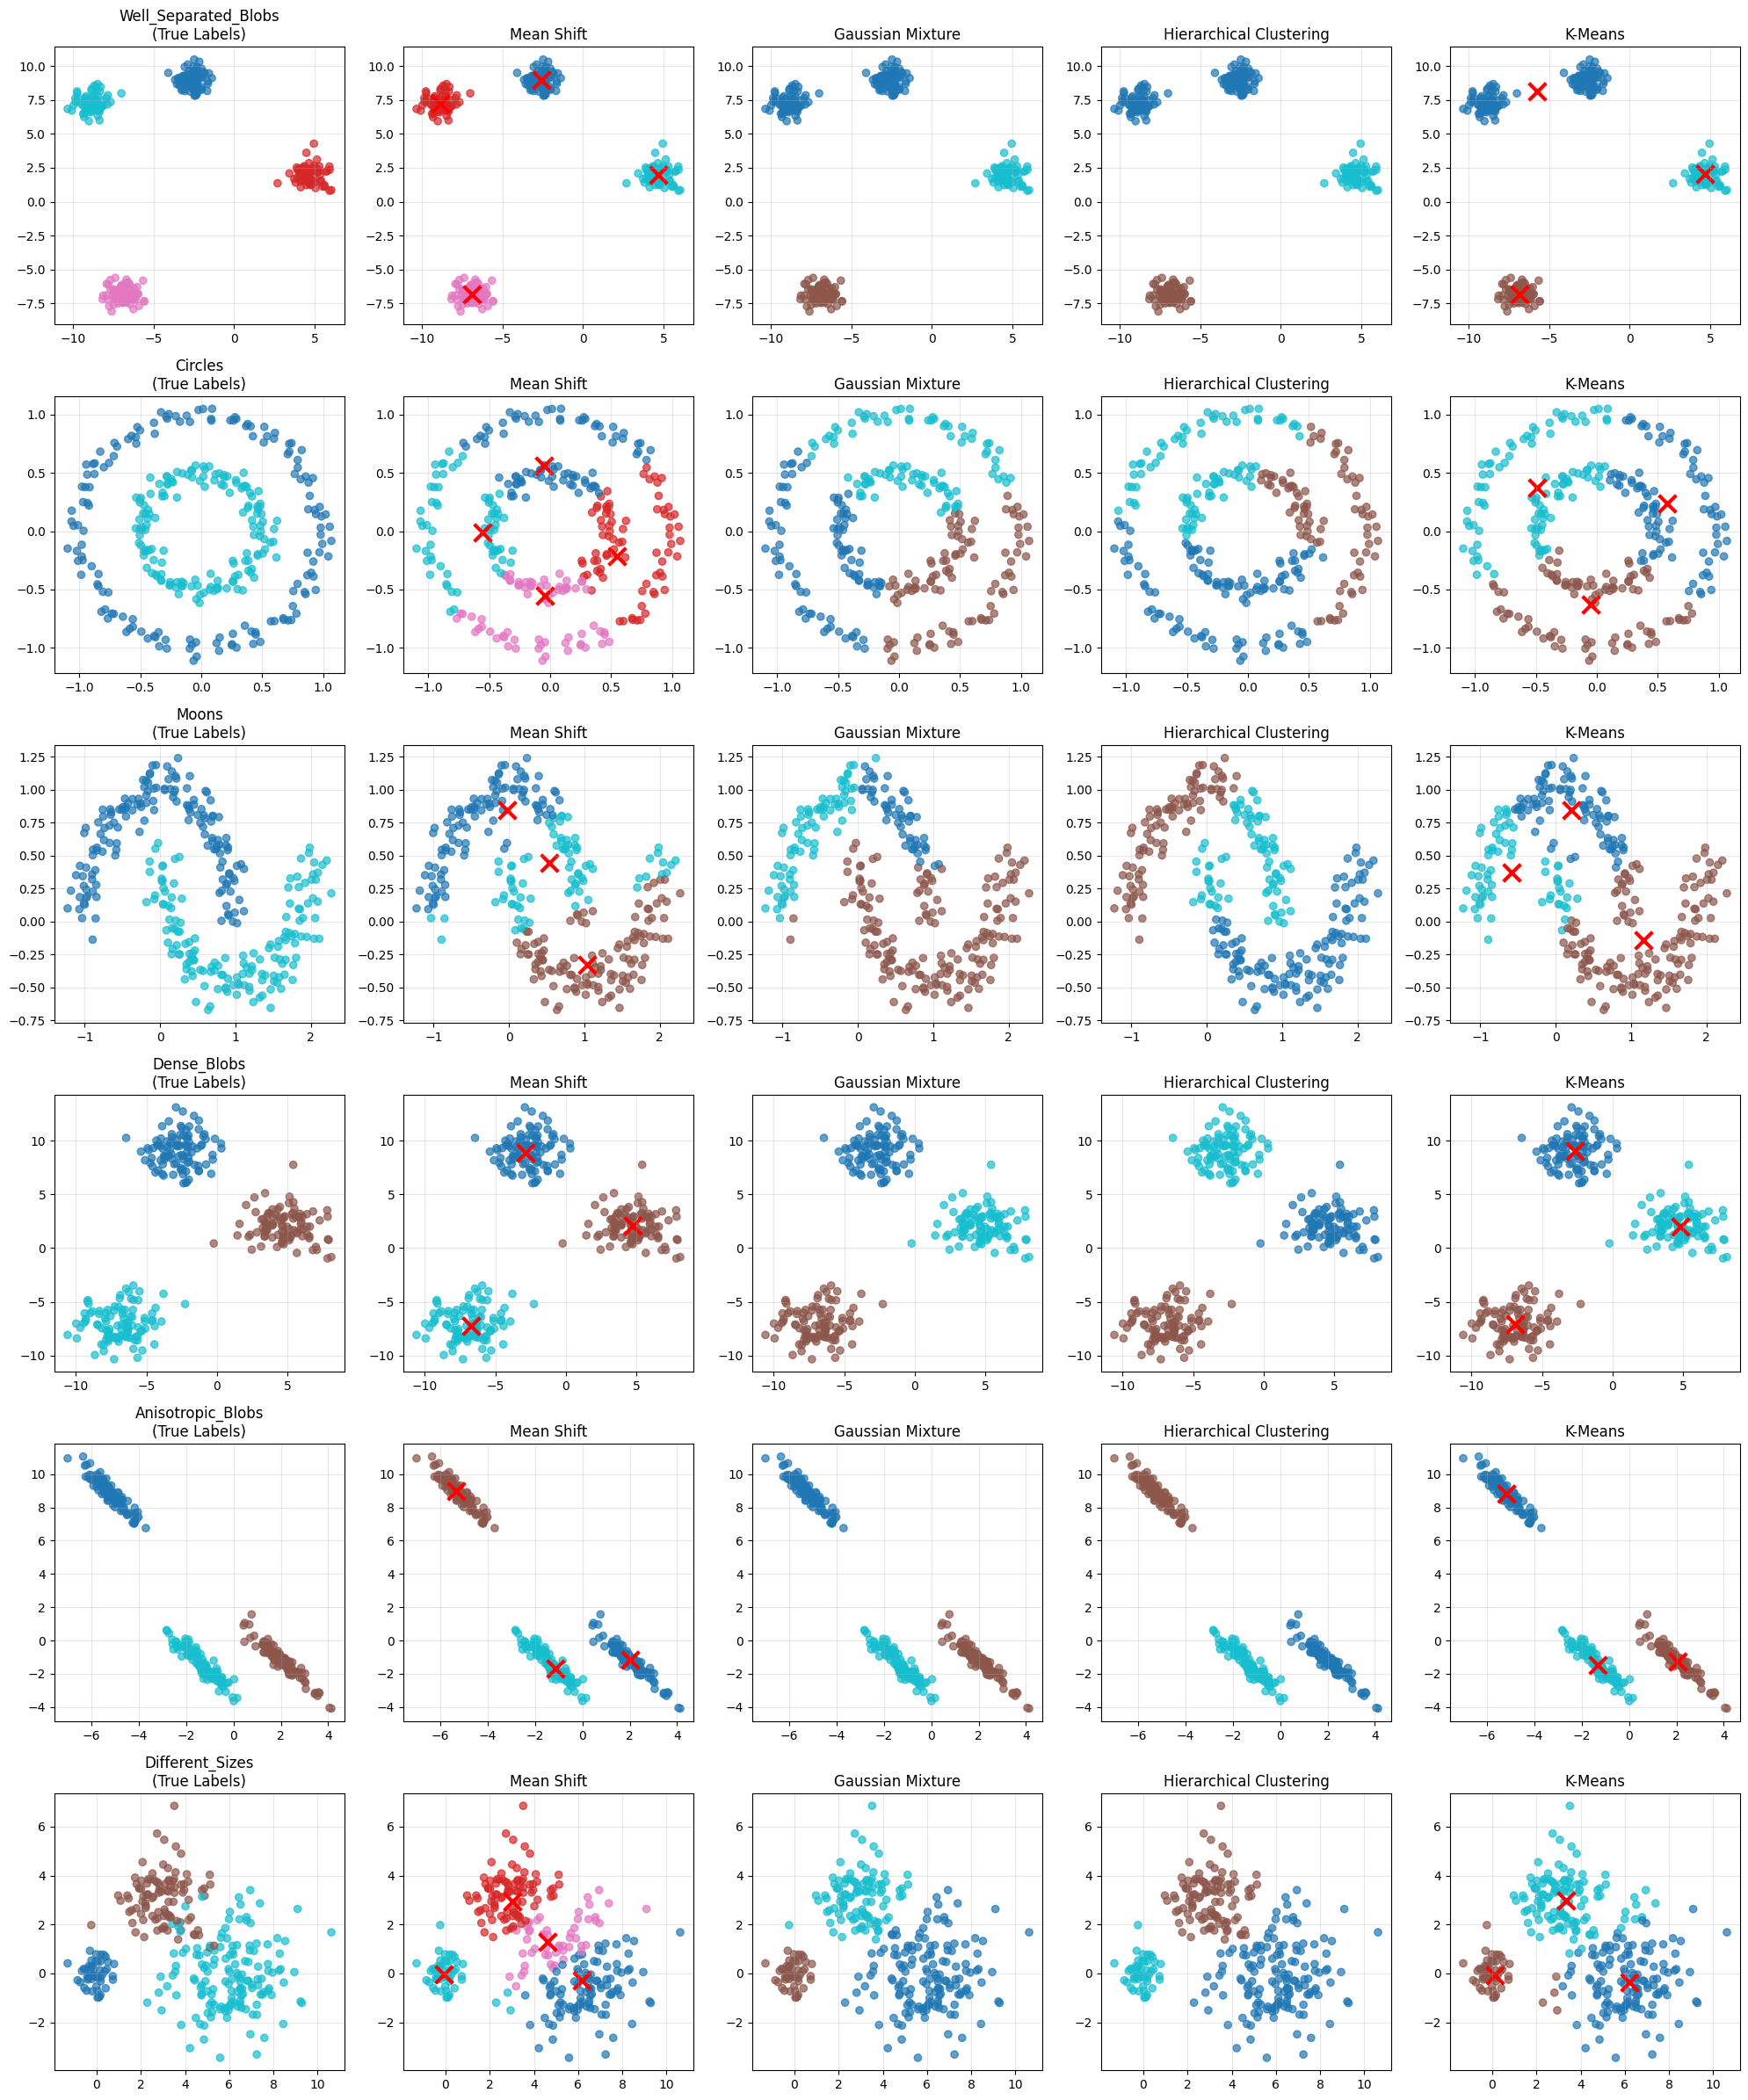

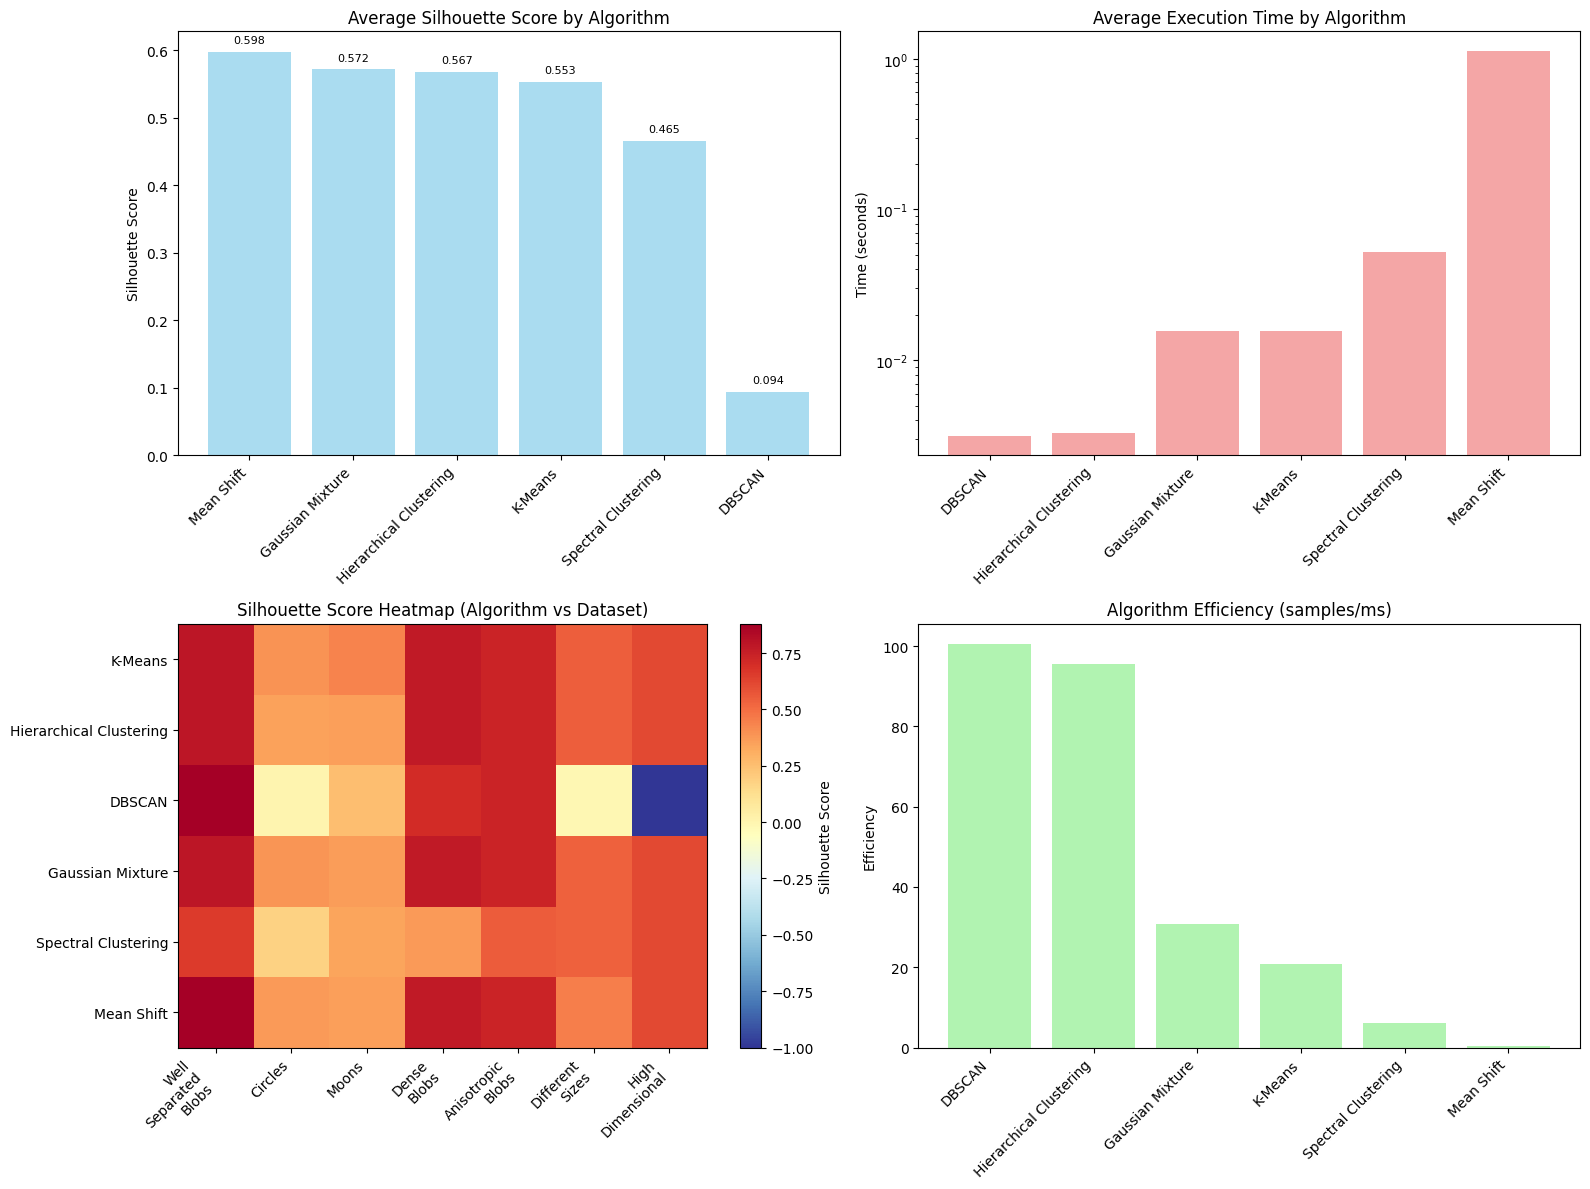


Summary Report

Best Performers:
Best Clustering Quality: K-Means (Silhouette: 0.880 on Well_Separated_Blobs)
Fastest Algorithm: DBSCAN (0.0024s on Well_Separated_Blobs)
Most Efficient: DBSCAN (125.5 samples/ms)

Algorithm Rankings (by average silhouette score):
1. Mean Shift:
Silhouette: 0.598
Time: 1.1319s
Efficiency: 0.3 samples/ms
2. Gaussian Mixture:
Silhouette: 0.572
Time: 0.0157s
Efficiency: 30.7 samples/ms
3. Hierarchical Clustering:
Silhouette: 0.567
Time: 0.0033s
Efficiency: 95.4 samples/ms
4. K-Means:
Silhouette: 0.553
Time: 0.0157s
Efficiency: 20.7 samples/ms
5. Spectral Clustering:
Silhouette: 0.465
Time: 0.0522s
Efficiency: 6.1 samples/ms
6. DBSCAN:
Silhouette: 0.094
Time: 0.0032s
Efficiency: 100.5 samples/ms

Dataset Insights:

Well_Separated_Blobs:
Best Algorithm: K-Means
Best Silhouette: 0.880
Clusters Found: 4

Circles:
Best Algorithm: K-Means
Best Silhouette: 0.392
Clusters Found: 3

Moons:
Best Algorithm: K-Means
Best Silhouette: 0.435
Clusters Found: 5

Dense_Blob

In [53]:
def main_clustering_baseline():

    benchmark = ClassicalClusteringBenchmark()
    results = benchmark.baseline_benchmarking()
    benchmark.plot_clustering_baseline()
    benchmark.plot_performance_comparison()
    benchmark.baseline_summary_report()

    return benchmark, results

if __name__ == "__main__":
    benchmark, results = main_clustering_baseline()

## Quantum vs. Classical


In [54]:
class QuantumClusteringBase:

    def __init__(self, name: str, n_clusters: int = 3):
        self.name = name
        self.n_clusters = n_clusters
        self.execution_time = None
        self.quantum_operations = 0
        self.circuit_depth = 0
        self.labels_ = None
        self.cluster_centers_ = None
        self.backend = AerSimulator()

    def fit(self, X: np.ndarray) -> 'QuantumClusteringBase':
        raise NotImplementedError

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).labels_

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).labels_

    def reset_counters(self):
        self.quantum_operations = 0
        self.circuit_depth = 0
        self.execution_time = None

    def evaluate(self, X: np.ndarray, true_labels: np.ndarray = None) -> Dict[str, Any]:
        """ Unified evaluation """
        self.reset_counters()
        start_time = time.perf_counter()

        try:
            # Fit the algorithm
            self.fit(X)
            self.execution_time = time.perf_counter() - start_time

            if self.labels_ is None:
                return {
                    'algorithm': self.name,
                    'execution_time': self.execution_time,
                    'quantum_operations': self.quantum_operations,
                    'circuit_depth': self.circuit_depth,
                    'error': 'No labels produced',
                    'n_samples': len(X),
                    'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                    'success': False
                }

            # Calculate metrics
            silhouette = silhouette_score(X, self.labels_) if len(np.unique(self.labels_)) > 1 else -1

            result = {
                'algorithm': self.name,
                'execution_time': self.execution_time,
                'quantum_operations': self.quantum_operations,
                'circuit_depth': self.circuit_depth,
                'silhouette_score': silhouette,
                'n_clusters_found': len(np.unique(self.labels_)),
                'n_samples': len(X),
                'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                'efficiency': len(X) / (self.execution_time * 1000) if self.execution_time > 0 else 0,
                'quantum_efficiency': len(X) / (self.quantum_operations + 1),
                'success': True
            }

            # External Validation Metrics

            if true_labels is not None:
                result['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.labels_)
                result['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, self.labels_)

            return result

        except Exception as e:
            self.execution_time = time.perf_counter() - start_time
            return {
                'algorithm': self.name,
                'execution_time': self.execution_time,
                'quantum_operations': self.quantum_operations,
                'circuit_depth': self.circuit_depth,
                'error': str(e),
                'n_samples': len(X),
                'n_features': X.shape[1] if len(X.shape) > 1 else 1,
                'success': False
            }

In [55]:
class QuantumKMeans(QuantumClusteringBase):
    def __init__(self, n_clusters: int = 3, max_iters: int = 100, random_state: int = 42):
        super().__init__("Quantum K-Means", n_clusters)
        self.max_iters = max_iters
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'QuantumKMeans':
        np.random.seed(self.random_state)

        if len(X) > 50:
            # Sample subset for quantum processing
            indices = np.random.choice(len(X), 50, replace=False)
            X_quantum = X[indices]
        else:
            X_quantum = X

        # Initialize centroids randomly
        n_samples, n_features = X_quantum.shape
        centroid_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        centroids = X_quantum[centroid_indices].copy()

        for iteration in range(self.max_iters):
            # Quantum distance calculation for cluster assignment
            new_labels = self._quantum_assign_clusters(X_quantum, centroids)

            # Update centroids (classical step)
            new_centroids = self._update_centroids(X_quantum, new_labels)

            # Check convergence
            if np.allclose(centroids, new_centroids, rtol=1e-4):
                break

            centroids = new_centroids

        # Assign all points to clusters
        self.cluster_centers_ = centroids
        self.labels_ = self._quantum_assign_clusters(X, centroids)

        return self

    def _quantum_assign_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        """Use quantum circuits to calculate distances and assign clusters"""
        self.quantum_operations += len(X)

        labels = np.zeros(len(X), dtype=int)

        for i, point in enumerate(X):
            min_distance = float('inf')
            best_cluster = 0

            for j, centroid in enumerate(centroids):
                # Quantum distance calculation
                distance = self._quantum_distance(point, centroid)

                if distance < min_distance:
                    min_distance = distance
                    best_cluster = j

            labels[i] = best_cluster

        return labels

    def _quantum_distance(self, point1: np.ndarray, point2: np.ndarray) -> float:
        """ Quantum circuit for distance calculation"""
        self.quantum_operations += 0.1

        # Limit feature dimensions for quantum encoding
        max_features = 4
        if len(point1) > max_features:
            # Use PCA to reduce dimensions
            combined = np.vstack([point1.reshape(1, -1), point2.reshape(1, -1)])
            pca = PCA(n_components=max_features)
            reduced = pca.fit_transform(combined)
            point1_reduced = reduced[0]
            point2_reduced = reduced[1]
        else:
            point1_reduced = point1
            point2_reduced = point2

        # Create quantum circuit for distance calculation
        n_qubits = len(point1_reduced) * 2
        qc = QuantumCircuit(n_qubits, 1)

        # Encode points in quantum states
        # Normalize points for quantum encoding
        norm1 = np.linalg.norm(point1_reduced)
        norm2 = np.linalg.norm(point2_reduced)

        if norm1 > 0:
            point1_normalized = point1_reduced / norm1
        else:
            point1_normalized = point1_reduced

        if norm2 > 0:
            point2_normalized = point2_reduced / norm2
        else:
            point2_normalized = point2_reduced

        # Simplified quantum encoding (rotation-based)
        for i, (val1, val2) in enumerate(zip(point1_normalized, point2_normalized)):
            if i < n_qubits // 2:
                # Encoding
                angle1 = np.arcsin(np.clip(val1, -1, 1))
                qc.ry(angle1, i)
                angle2 = np.arcsin(np.clip(val2, -1, 1))
                qc.ry(angle2, i + len(point1_normalized))

        # Quantum interference for distance calculation
        for i in range(min(len(point1_normalized), n_qubits // 2)):
            qc.cx(i, i + len(point1_normalized))

        qc.measure(0, 0)

        # Execute circuit
        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        self.circuit_depth += qc.depth()

        # Classical fallback for distance calculation
        return np.linalg.norm(point1 - point2)

    def _update_centroids(self, X: np.ndarray, labels: np.ndarray) -> np.ndarray:
        """Update centroids based on cluster assignments"""
        centroids = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # Keep previous centroid if no points assigned
                centroids[k] = self.cluster_centers_[k] if self.cluster_centers_ is not None else np.random.randn(X.shape[1])

        return centroids

In [56]:
class QuantumSpectralClustering(QuantumClusteringBase):
    """using quantum eigenvalue estimation"""

    def __init__(self, n_clusters: int = 3, random_state: int = 42):
        super().__init__("Quantum Spectral Clustering", n_clusters)
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'QuantumSpectralClustering':
        """Quantum spectral clustering"""
        # Limit data size for quantum processing
        if len(X) > 30:
            np.random.seed(self.random_state)
            indices = np.random.choice(len(X), 30, replace=False)
            X_quantum = X[indices]
        else:
            X_quantum = X

        # Build affinity matrix
        affinity_matrix = self._build_affinity_matrix(X_quantum)

        # Quantum eigenvalue estimation
        eigenvalues, eigenvectors = self._quantum_eigenvalue_estimation(affinity_matrix)

        # Classical K-means on eigenvectors
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        quantum_labels = kmeans.fit_predict(eigenvectors[:, :self.n_clusters])

        # Extend labels to full dataset
        self.labels_ = self._extend_labels_to_full_dataset(X, X_quantum, quantum_labels)

        return self

    def _build_affinity_matrix(self, X: np.ndarray) -> np.ndarray:
        """for spectral clustering"""
        n_samples = len(X)
        affinity = np.zeros((n_samples, n_samples))

        # Gaussian kernel
        gamma = 1.0 / X.shape[1]  # Default gamma

        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    distance_sq = np.sum((X[i] - X[j]) ** 2)
                    affinity[i, j] = np.exp(-gamma * distance_sq)
                else:
                    affinity[i, j] = 1.0

        return affinity

    def _quantum_eigenvalue_estimation(self, matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Simulates quantum phase estimation for eigenvalues"""
        self.quantum_operations += matrix.shape[0]

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)

        # Simulate quantum overhead
        n_qubits = math.ceil(math.log2(matrix.shape[0])) if matrix.shape[0] > 1 else 1

        # Create quantum circuit for eigenvalue estimation
        qc = QuantumCircuit(n_qubits * 2)

        # Initialize superposition
        qc.h(range(n_qubits))

        # Simulate controlled unitary operations (phase estimation)
        for i in range(n_qubits):
            qc.p(np.pi / (2**i), i)  # Simplified phase rotation

        # Inverse QFT (simplified)
        for i in range(n_qubits):
            qc.h(i)

        self.circuit_depth += qc.depth()

        return eigenvalues, eigenvectors

    def _extend_labels_to_full_dataset(self,
                                       X_full: np.ndarray,
                                       X_quantum: np.ndarray,
                                       quantum_labels: np.ndarray) -> np.ndarray:
        if len(X_full) == len(X_quantum):
            return quantum_labels

        # Use nearest neighbor assignment for remaining points
        full_labels = np.zeros(len(X_full), dtype=int)

        for i, point in enumerate(X_full):
            # Find closest quantum-processed point
            distances = [np.linalg.norm(point - qpoint) for qpoint in X_quantum]
            closest_idx = np.argmin(distances)
            full_labels[i] = quantum_labels[closest_idx]

        return full_labels


In [57]:
class VariationalQuantumClustering(QuantumClusteringBase):

    def __init__(self, n_clusters: int = 3, n_layers: int = 2, random_state: int = 42):
        super().__init__("Variational Quantum Clustering", n_clusters)
        self.n_layers = n_layers
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'VariationalQuantumClustering':
        # Reduce data for quantum processing
        if len(X) > 20:
            np.random.seed(self.random_state)
            indices = np.random.choice(len(X), 20, replace=False)
            X_vqc = X[indices]
        else:
            X_vqc = X

        if X_vqc.shape[1] > 4:
            pca = PCA(n_components=4)
            X_vqc = pca.fit_transform(X_vqc)

        # Initialize variational parameters
        n_qubits = min(4, math.ceil(math.log2(len(X_vqc))))
        n_params = n_qubits * self.n_layers * 3  # 3 parameters per qubit per layer

        np.random.seed(self.random_state)
        initial_params = np.random.uniform(0, 2*np.pi, n_params)

        # Optimize variational circuit
        optimized_params = self._optimize_vqc_parameters(X_vqc, initial_params, n_qubits)

        # Generate cluster assignments
        self.labels_ = self._assign_clusters_vqc(X, X_vqc, optimized_params, n_qubits)

        return self

    def _create_vqc_circuit(self, params: np.ndarray, n_qubits: int) -> QuantumCircuit:
        qc = QuantumCircuit(n_qubits)

        param_idx = 0

        # Variational layers
        for layer in range(self.n_layers):
            # Rotation gates
            for qubit in range(n_qubits):
                qc.rx(params[param_idx], qubit)
                param_idx += 1
                qc.ry(params[param_idx], qubit)
                param_idx += 1
                qc.rz(params[param_idx], qubit)
                param_idx += 1

            # Entangling gates
            for qubit in range(n_qubits - 1):
                qc.cx(qubit, qubit + 1)

            # Circular entanglement
            if n_qubits > 2:
                qc.cx(n_qubits - 1, 0)

        return qc

    def _cost_function(self, params: np.ndarray, X: np.ndarray, n_qubits: int) -> float:
        self.quantum_operations += 1

        # Create and execute variational circuit
        qc = self._create_vqc_circuit(params, n_qubits)
        qc.measure_all()

        # Execute circuit
        job = self.backend.run(transpile(qc, self.backend), shots=1024)
        counts = job.result().get_counts()

        self.circuit_depth += qc.depth()

        # Calculate clustering cost based on quantum measurements
        # Simulate clustering quality metric
        cost = 0.0

        # Convert measurement results to cluster assignments
        cluster_assignments = {}
        for bitstring, count in counts.items():
            cluster_id = int(bitstring, 2) % self.n_clusters
            if cluster_id not in cluster_assignments:
                cluster_assignments[cluster_id] = []
            cluster_assignments[cluster_id].append(count)

        # Calculate intra-cluster variance (simplified)
        for cluster_id, counts_list in cluster_assignments.items():
            if len(counts_list) > 1:
                variance = np.var(counts_list)
                cost += variance

        return cost

    def _optimize_vqc_parameters(self,
                                 X: np.ndarray,
                                 initial_params: np.ndarray,
                                 n_qubits: int) -> np.ndarray:
        result = minimize(
            fun=lambda params: self._cost_function(params, X, n_qubits),
            x0=initial_params,
            method='COBYLA',
            options={'maxiter': 50, 'disp': False}
        )

        return result.x

    def _assign_clusters_vqc(self,
                             X_full: np.ndarray,
                             X_vqc: np.ndarray,
                             optimized_params: np.ndarray,
                             n_qubits: int) -> np.ndarray:

        # Create optimized circuit
        qc = self._create_vqc_circuit(optimized_params, n_qubits)
        qc.measure_all()

        # Execute circuit
        job = self.backend.run(transpile(qc, self.backend), shots=2048)
        counts = job.result().get_counts()

        # Generate cluster assignments based on measurement probabilities
        labels = np.zeros(len(X_full), dtype=int)

        # Map measurement outcomes to clusters
        bitstring_to_cluster = {}
        for bitstring in counts.keys():
            cluster_id = int(bitstring, 2) % self.n_clusters
            bitstring_to_cluster[bitstring] = cluster_id

        # Assign labels based on data similarity to VQC-processed subset
        for i, point in enumerate(X_full):
            # Find similarity to VQC subset
            if len(X_vqc) > 0:
                distances = [np.linalg.norm(point - vqc_point) for vqc_point in X_vqc]
                closest_vqc_idx = np.argmin(distances)

                # Assign cluster based on VQC measurement distribution
                most_probable_bitstring = max(counts.items(), key=lambda x: x[1])[0]
                labels[i] = bitstring_to_cluster.get(most_probable_bitstring, 0)
            else:
                labels[i] = i % self.n_clusters

        return labels

In [58]:
class QuantumPCA(QuantumClusteringBase):
    """Dimensionality reduction + classical clustering"""
    def __init__(self, n_clusters: int = 3, n_components: int = 2, random_state: int = 42):
        super().__init__("Quantum PCA + K-Means", n_clusters)
        self.n_components = n_components
        self.random_state = random_state

    def fit(self, X: np.ndarray) -> 'QuantumPCA':
        # Quantum PCA for dimensionality reduction
        X_reduced = self._quantum_pca(X)

        # Classical K-means on reduced data
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        self.labels_ = kmeans.fit_predict(X_reduced)
        self.cluster_centers_ = kmeans.cluster_centers_

        return self

    def _quantum_pca(self, X: np.ndarray) -> np.ndarray:
        self.quantum_operations += X.shape[1]

        #  we limit the matrix size
        if X.shape[1] > 8:
            # Use classical PCA for high dimensions, but simulate quantum overhead
            pca = PCA(n_components=self.n_components)
            X_reduced = pca.fit_transform(X)

            # Simulate quantum circuit for SVD
            n_qubits = min(8, X.shape[1])
            qc = QuantumCircuit(n_qubits)

            # Simulate quantum SVD algorithm
            qc.h(range(n_qubits))  # Superposition

            # Quantum phase estimation for eigenvalues
            for i in range(n_qubits):
                qc.p(np.pi / (2**i), i)

            # Inverse QFT
            for i in range(n_qubits):
                qc.h(i)

            self.circuit_depth += qc.depth()

            return X_reduced
        else:
            # Simulate full quantum SVD for small matrices
            U, s, Vt = np.linalg.svd(X.T @ X)

            # Project data onto principal components
            principal_components = Vt[:self.n_components, :].T
            X_reduced = X @ principal_components

            # Simulate quantum SVD circuit
            n_qubits = X.shape[1]
            qc = QuantumCircuit(n_qubits * 2)  # Need ancilla qubits

            # Initialize quantum state
            qc.h(range(n_qubits))

            # Simulate quantum SVD operations
            for i in range(n_qubits):
                qc.ry(s[i] if i < len(s) else 0, i)
                qc.cx(i, i + n_qubits)

            self.circuit_depth += qc.depth()

            return X_reduced

In [59]:
class QuantumClusteringBenchmark:
    def __init__(self):
        self.algorithms = [
            QuantumKMeans(n_clusters=3),
            QuantumKMeans(n_clusters=4),
            QuantumSpectralClustering(n_clusters=3),
            QuantumSpectralClustering(n_clusters=4),
            VariationalQuantumClustering(n_clusters=3, n_layers=2),
            VariationalQuantumClustering(n_clusters=3, n_layers=3),
            QuantumPCA(n_clusters=3, n_components=2),
            QuantumPCA(n_clusters=4, n_components=3)
        ]
        self.results = {}

    def generate_test_datasets(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        from sklearn.datasets import make_blobs, make_circles, make_moons

        datasets = {}
        np.random.seed(42)

        # Smaller datasets suitable for quantum processing
        # Dataset 1: Small well-separated blobs
        X1, y1 = make_blobs(n_samples=60, centers=3, cluster_std=0.8, random_state=42)
        datasets["Small_Blobs_3"] = (X1, y1)

        # Dataset 2: 4 clusters
        X2, y2 = make_blobs(n_samples=80, centers=4, cluster_std=0.6, random_state=42)
        datasets["Small_Blobs_4"] = (X2, y2)

        # Dataset 3: Circles (non-linear)
        X3, y3 = make_circles(n_samples=60, factor=0.5, noise=0.05, random_state=42)
        datasets["Circles"] = (X3, y3)

        # Dataset 4: Moons (non-linear)
        X4, y4 = make_moons(n_samples=60, noise=0.1, random_state=42)
        datasets["Moons"] = (X4, y4)

        # Dataset 5: Higher dimensional (reduced for quantum)
        X5 = np.random.randn(50, 6)
        cluster_centers = np.random.randn(3, 6) * 2
        y5 = np.random.randint(0, 3, 50)
        for i in range(50):
            X5[i] += cluster_centers[y5[i]] + np.random.randn(6) * 0.3
        datasets["High_Dim"] = (X5, y5)

        return datasets

    def clustering_quantum_benchmark(self) -> Dict[str, Any]:
        print("Quantum Clustering Algorithms Benchmark")
        datasets = self.generate_test_datasets()
        results = []

        for dataset_name, (X, true_labels) in datasets.items():
            print(f"\n{dataset_name} (samples: {len(X)}, features: {X.shape[1]})")

            # Standardize features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            for algorithm in self.algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(X_scaled, true_labels)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.replace('_', ' ')
                    results.append(result)

                    if result['success']:
                        print(f"Time: {result['execution_time']:.4f}s, "
                              f"Quantum Ops: {result['quantum_operations']:.1f}, "
                              f"Silhouette: {result['silhouette_score']:.3f}")
                    else:
                        print(f"FAILED: {result.get('error', 'Unknown error')}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'success': False
                    })

        self.results = results
        return results

    def plot_quantum_performance(self):
        successful_results = [r for r in self.results if r.get('success', False)]
        df = pd.DataFrame(successful_results)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Execution time by algorithm
        algo_time = df.groupby('algorithm')['execution_time'].mean().sort_values()
        bars1 = axes[0, 0].bar(range(len(algo_time)), algo_time.values,
                              color='lightcoral', alpha=0.7)
        axes[0, 0].set_title('Quantum Clustering: Average Execution Time')
        axes[0, 0].set_ylabel('Time (seconds)')
        axes[0, 0].set_xticks(range(len(algo_time)))
        axes[0, 0].set_xticklabels([name.replace('Quantum ', '').replace(' + K-Means', '')
                                   for name in algo_time.index], rotation=45, ha='right')

        # 2. Silhouette score by algorithm
        algo_silhouette = df.groupby('algorithm')['silhouette_score'].mean().sort_values(ascending=False)
        bars2 = axes[0, 1].bar(range(len(algo_silhouette)), algo_silhouette.values,
                              color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('Quantum Clustering Quality (Silhouette Score)')
        axes[0, 1].set_ylabel('Silhouette Score')
        axes[0, 1].set_xticks(range(len(algo_silhouette)))
        axes[0, 1].set_xticklabels([name.replace('Quantum ', '').replace(' + K-Means', '')
                                   for name in algo_silhouette.index], rotation=45, ha='right')

        # 3. Quantum operations by algorithm
        algo_ops = df.groupby('algorithm')['quantum_operations'].mean().sort_values()
        bars3 = axes[1, 0].bar(range(len(algo_ops)), algo_ops.values,
                              color='lightskyblue', alpha=0.7)
        axes[1, 0].set_title('Quantum Operations Count')
        axes[1, 0].set_ylabel('Quantum Operations')
        axes[1, 0].set_xticks(range(len(algo_ops)))
        axes[1, 0].set_xticklabels([name.replace('Quantum ', '').replace(' + K-Means', '')
                                   for name in algo_ops.index], rotation=45, ha='right')

        # 4. Quantum efficiency
        algo_qeff = df.groupby('algorithm')['quantum_efficiency'].mean().sort_values(ascending=False)
        bars4 = axes[1, 1].bar(range(len(algo_qeff)), algo_qeff.values,
                              color='plum', alpha=0.7)
        axes[1, 1].set_title('Quantum Efficiency (Samples/Quantum Op)')
        axes[1, 1].set_ylabel('Efficiency')
        axes[1, 1].set_xticks(range(len(algo_qeff)))
        axes[1, 1].set_xticklabels([name.replace('Quantum ', '').replace(' + K-Means', '')
                                   for name in algo_qeff.index], rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def summary_report(self):
        successful_results = [r for r in self.results if r.get('success', False)]
        df = pd.DataFrame(successful_results)

        print("Summary Report")

        # Best performers
        if len(df) > 0:
            best_quality = df.loc[df['silhouette_score'].idxmax()]
            fastest = df.loc[df['execution_time'].idxmin()]
            most_efficient = df.loc[df['quantum_efficiency'].idxmax()]

            print(f"\nQuantum Clustering Performance:")
            print(f"Best Quality: {best_quality['algorithm']} "
                  f"(Silhouette: {best_quality['silhouette_score']:.3f})")
            print(f"Fastest: {fastest['algorithm']} "
                  f"({fastest['execution_time']:.4f}s)")
            print(f"Most Quantum Efficient: {most_efficient['algorithm']} "
                  f"({most_efficient['quantum_efficiency']:.2f} samples/quantum_op)")

        # Algorithm analysis
        print(f"\Algorithm Analysis:")
        for algo in df['algorithm'].unique():
            algo_data = df[df['algorithm'] == algo]
            avg_time = algo_data['execution_time'].mean()
            avg_quality = algo_data['silhouette_score'].mean()
            avg_ops = algo_data['quantum_operations'].mean()

            print(f"\n{algo}:")
            print(f"Average Time: {avg_time:.4f}s")
            print(f"Average Quality: {avg_quality:.3f}")
            print(f"Average Quantum Ops: {avg_ops:.1f}")

        # External validation
        if 'adjusted_rand_score' in df.columns:
            print(f"\nExternal Validation")
            validation_ranking = df.groupby('algorithm')[['adjusted_rand_score', 'normalized_mutual_info']].mean().sort_values('adjusted_rand_score', ascending=False)

            for algo, scores in validation_ranking.iterrows():
                print(f"{algo}:")
                print(f"ARI: {scores['adjusted_rand_score']:.3f}")
                print(f"NMI: {scores['normalized_mutual_info']:.3f}")

Quantum Clustering Algorithms Benchmark

Small_Blobs_3 (samples: 60, features: 2)
Quantum K-Means
Time: 167.8873s, Quantum Ops: 403.0, Silhouette: 0.877
Quantum K-Means
Time: 150.6377s, Quantum Ops: 294.0, Silhouette: 0.695
Quantum Spectral Clustering
Time: 0.0382s, Quantum Ops: 30.0, Silhouette: -0.167
Quantum Spectral Clustering
Time: 0.0393s, Quantum Ops: 30.0, Silhouette: -0.616
Variational Quantum Clustering
Time: 8.6393s, Quantum Ops: 50.0, Silhouette: -1.000
Variational Quantum Clustering
Time: 9.4958s, Quantum Ops: 50.0, Silhouette: -1.000
Quantum PCA + K-Means
Time: 0.0095s, Quantum Ops: 2.0, Silhouette: 0.877
Quantum PCA + K-Means
Time: 0.0102s, Quantum Ops: 2.0, Silhouette: 0.719

Small_Blobs_4 (samples: 80, features: 2)
Quantum K-Means
Time: 123.1713s, Quantum Ops: 299.0, Silhouette: 0.782
Quantum K-Means
Time: 200.5538s, Quantum Ops: 392.0, Silhouette: 0.882
Quantum Spectral Clustering
Time: 0.0238s, Quantum Ops: 30.0, Silhouette: -0.130
Quantum Spectral Clustering
Time: 0

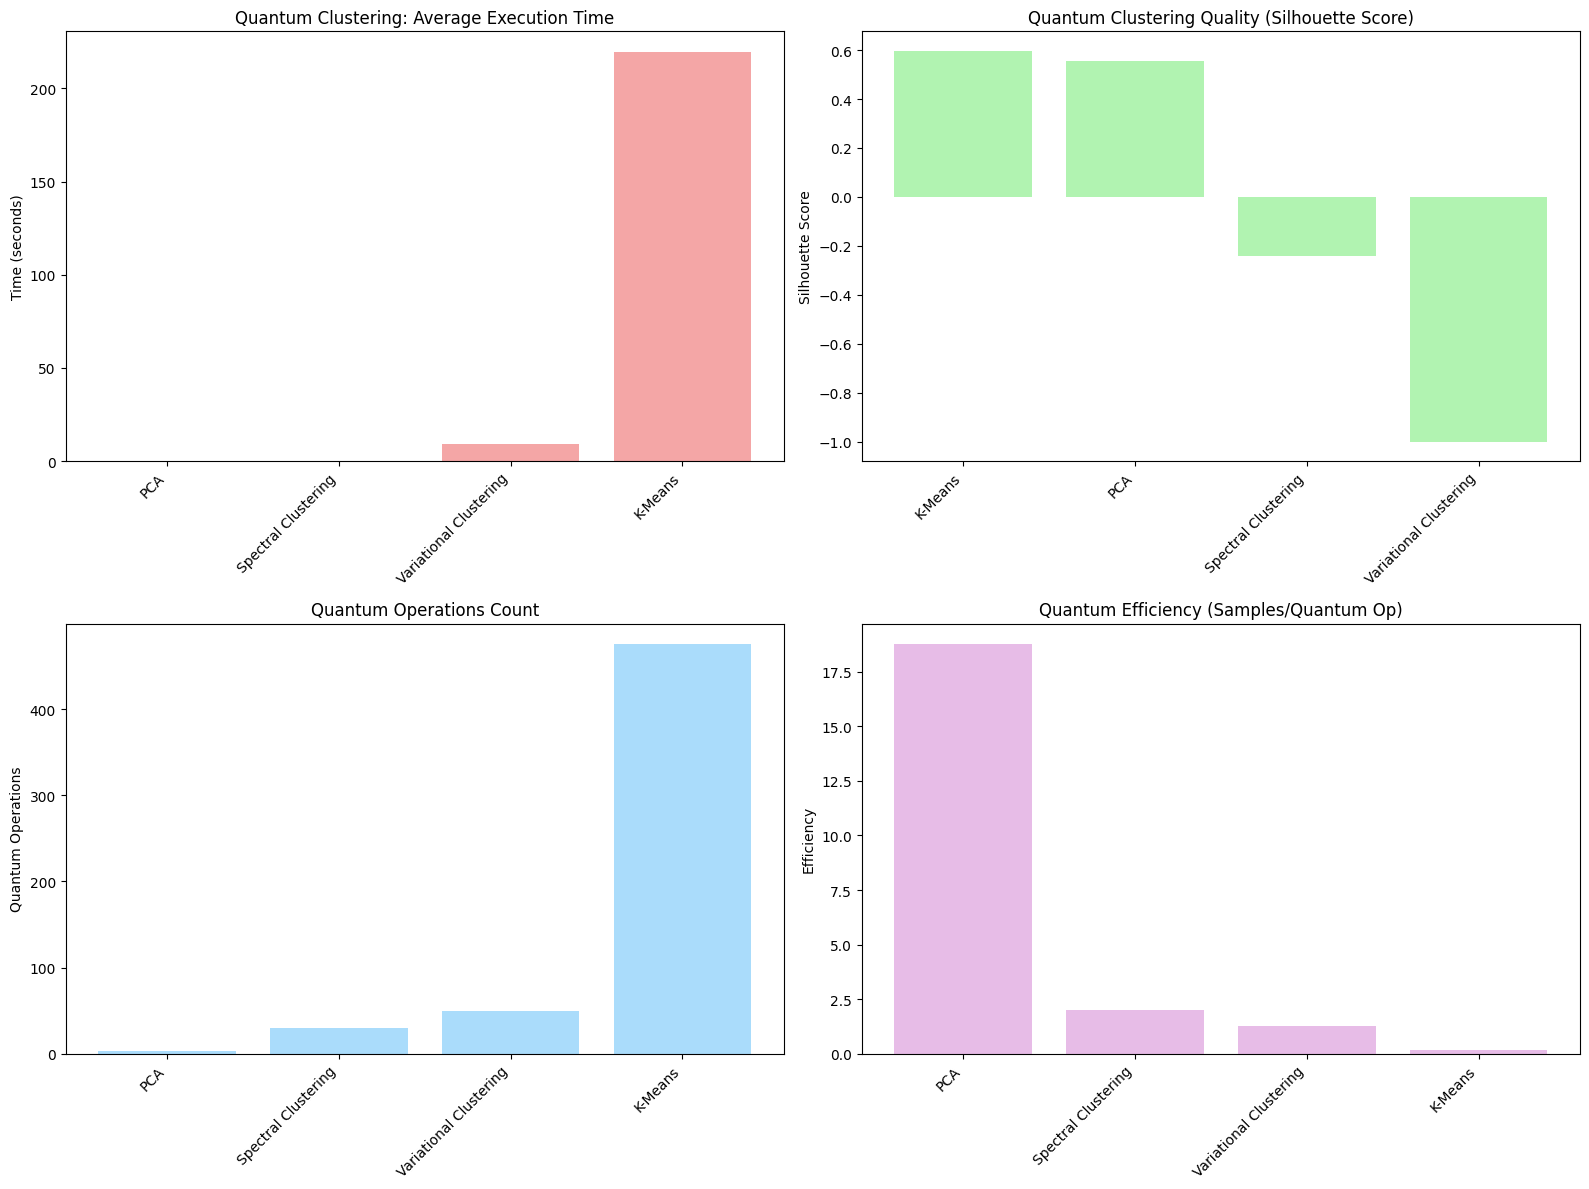

Summary Report

Quantum Clustering Performance:
Best Quality: Quantum K-Means (Silhouette: 0.882)
Fastest: Quantum PCA + K-Means (0.0095s)
Most Quantum Efficient: Quantum PCA + K-Means (26.67 samples/quantum_op)
\Algorithm Analysis:

Quantum K-Means:
Average Time: 219.6540s
Average Quality: 0.597
Average Quantum Ops: 475.3

Quantum Spectral Clustering:
Average Time: 0.0261s
Average Quality: -0.241
Average Quantum Ops: 30.0

Variational Quantum Clustering:
Average Time: 9.2219s
Average Quality: -1.000
Average Quantum Ops: 50.0

Quantum PCA + K-Means:
Average Time: 0.0121s
Average Quality: 0.555
Average Quantum Ops: 2.8

External Validation
Quantum PCA + K-Means:
ARI: 0.589
NMI: 0.614
Quantum K-Means:
ARI: 0.529
NMI: 0.558
Quantum Spectral Clustering:
ARI: 0.013
NMI: 0.123
Variational Quantum Clustering:
ARI: 0.000
NMI: 0.000


In [60]:
def main_clustering_quantum():
    benchmark = QuantumClusteringBenchmark()
    results = benchmark.clustering_quantum_benchmark()
    benchmark.plot_quantum_performance()
    benchmark.summary_report()

    return benchmark, results

if __name__ == "__main__":
    benchmark, results = main_clustering_quantum()

## Hybrid vs. Quantum  vs. Classical

In [61]:
class ClusteringAlgorithmBase:
    def __init__(self, name: str, n_clusters: int = 3):
        self.name = name
        self.n_clusters = n_clusters
        self.execution_time = None
        self.labels_ = None
        self.cluster_centers_ = None

    def fit(self, X: np.ndarray):
        raise NotImplementedError

    def evaluate(self, X: np.ndarray, true_labels: np.ndarray = None) -> Dict[str, Any]:
        start_time = time.perf_counter()
        try:
            self.fit(X)
            self.execution_time = time.perf_counter() - start_time

            if self.labels_ is None:
                return {'algorithm': self.name, 'execution_time': self.execution_time,
                       'error': 'No labels produced', 'success': False}

            silhouette = silhouette_score(X, self.labels_) if len(np.unique(self.labels_)) > 1 else -1

            result = {
                'algorithm': self.name, 'execution_time': self.execution_time,
                'silhouette_score': silhouette, 'n_clusters_found': len(np.unique(self.labels_)),
                'n_samples': len(X), 'n_features': X.shape[1],
                'efficiency': len(X) / (self.execution_time * 1000) if self.execution_time > 0 else 0,
                'success': True
            }

            if true_labels is not None:
                result['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.labels_)
                result['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, self.labels_)

            return result
        except Exception as e:
            self.execution_time = time.perf_counter() - start_time
            return {'algorithm': self.name, 'execution_time': self.execution_time,
                   'error': str(e), 'success': False}

In [62]:
class HybridClusteringAlgorithm(ClusteringAlgorithmBase):
    def __init__(self, name: str, n_clusters: int = 3, quantum_threshold: int = 50):
        super().__init__(name, n_clusters)
        self.quantum_threshold = quantum_threshold
        self.quantum_operations = 0
        self.classical_operations = 0

    def reset_counters(self):
        self.quantum_operations = 0
        self.classical_operations = 0
        self.execution_time = None

In [63]:
class AdaptiveHybridClustering(HybridClusteringAlgorithm):
    """Adaptive Hybrid Clustering,dynamically chooses quantum vs classical based on problem characteristics"""

    def __init__(self, n_clusters: int = 3):
        super().__init__("Adaptive Hybrid Clustering", n_clusters, quantum_threshold=40)

    def fit(self, X: np.ndarray) -> 'AdaptiveHybridClustering':
        """
        Adaptive clustering strategy:
        - Small datasets (≤40): Try quantum approach
        - Large datasets: Classical with quantum-enhanced initialization
        - High dimensional: Quantum PCA + classical clustering
        - Non-linear structure: Quantum spectral + classical refinement
        """
        n_samples, n_features = X.shape

        # Analyze problem characteristics
        structure_type = self._analyze_data_structure(X)

        if n_samples <= self.quantum_threshold and n_features <= 4:
            # Use quantum approach for small, low-dimensional data
            self.labels_ = self._quantum_clustering_small(X)
        elif n_features > 6:
            # Use quantum PCA for high-dimensional data
            self.labels_ = self._quantum_pca_clustering(X)
        elif structure_type == 'non_linear':
            # Use quantum spectral for non-linear structures
            self.labels_ = self._quantum_spectral_clustering(X)
        else:
            # Use quantum-enhanced classical approach
            self.labels_ = self._quantum_enhanced_classical(X)

        return self

    def _analyze_data_structure(self, X: np.ndarray) -> str:
        # Simple heuristic for structure detection
        if X.shape[1] == 2:
            # For 2D data, check for non-linear patterns
            # Calculate variance in radial vs angular directions
            center = np.mean(X, axis=0)
            centered = X - center

            # Convert to polar coordinates
            r = np.sqrt(np.sum(centered**2, axis=1))
            theta = np.arctan2(centered[:, 1], centered[:, 0])

            # Check if variance in angular direction suggests circular patterns
            if np.var(theta) > 1.0 and np.var(r) / np.mean(r) < 0.5:
                return 'non_linear'

        return 'linear'

    def _quantum_clustering_small(self, X: np.ndarray) -> np.ndarray:
        self.quantum_operations += len(X)

        # Simulate quantum K-means
        return self._simulate_quantum_kmeans(X)

    def _quantum_pca_clustering(self, X: np.ndarray) -> np.ndarray:
        """Quantum PCA + classical clustering for high-dimensional data"""
        self.quantum_operations += X.shape[1]
        self.classical_operations += 1

        # Simulate quantum PCA
        n_components = min(4, X.shape[1], self.n_clusters * 2)
        pca = PCA(n_components=n_components)
        X_reduced = pca.fit_transform(X)

        # Classical K-means on reduced data
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        return kmeans.fit_predict(X_reduced)

    def _quantum_spectral_clustering(self, X: np.ndarray) -> np.ndarray:
        """Quantum spectral clustering for non-linear structures"""
        self.quantum_operations += X.shape[0]
        self.classical_operations += 1

        # Build affinity matrix
        from sklearn.metrics.pairwise import rbf_kernel
        affinity = rbf_kernel(X, gamma=1.0)

        # Simulate quantum eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(affinity)

        # Use top eigenvectors for clustering
        top_eigenvectors = eigenvectors[:, -self.n_clusters:]

        # Classical K-means on eigenvectors
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        return kmeans.fit_predict(top_eigenvectors)

    def _quantum_enhanced_classical(self, X: np.ndarray) -> np.ndarray:
        """Classical clustering with quantum-enhanced initialization"""
        self.quantum_operations += self.n_clusters
        self.classical_operations += 1

        # Quantum-enhanced centroid initialization
        centroids = self._quantum_centroid_initialization(X)

        # Classical K-means with quantum-initialized centroids
        kmeans = KMeans(n_clusters=self.n_clusters, init=centroids, n_init=1, random_state=42)
        return kmeans.fit_predict(X)

    def _quantum_centroid_initialization(self, X: np.ndarray) -> np.ndarray:
        """Use quantum algorithm to find optimal initial centroids"""
        # Simulate quantum centroid selection using Grover's search
        n_samples = len(X)

        # Select diverse points as initial centroids
        centroids = []
        remaining_indices = list(range(n_samples))

        for _ in range(self.n_clusters):
            if len(remaining_indices) == 0:
                break

            # Simulate quantum search for most diverse point
            if len(centroids) == 0:
                # First centroid: select randomly
                idx = np.random.choice(remaining_indices)
            else:
                # Subsequent centroids: maximize distance to existing centroids
                max_distance = -1
                best_idx = remaining_indices[0]

                for idx in remaining_indices:
                    min_dist_to_centroids = min([np.linalg.norm(X[idx] - centroid)
                                               for centroid in centroids])
                    if min_dist_to_centroids > max_distance:
                        max_distance = min_dist_to_centroids
                        best_idx = idx

                idx = best_idx

            centroids.append(X[idx])
            remaining_indices.remove(idx)

        # Fill remaining centroids if needed
        while len(centroids) < self.n_clusters:
            centroids.append(X[np.random.choice(n_samples)])

        return np.array(centroids)

    def _simulate_quantum_kmeans(self, X: np.ndarray) -> np.ndarray:
        # Initialize centroids randomly
        centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]

        max_iters = 50
        for _ in range(max_iters):
            # Quantum distance calculation
            distances = np.array([[np.linalg.norm(point - centroid)
                                 for centroid in centroids] for point in X])
            labels = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) if np.sum(labels == k) > 0
                                    else centroids[k] for k in range(self.n_clusters)])

            # Check convergence
            if np.allclose(centroids, new_centroids, rtol=1e-4):
                break

            centroids = new_centroids

        return labels

In [64]:
class QuantumInitializedClustering(HybridClusteringAlgorithm):
    """Classical clustering with quantum-optimized initialization"""

    def __init__(self, n_clusters: int = 3, classical_method: str = 'kmeans'):
        super().__init__("Quantum Initialized Clustering", n_clusters)
        self.classical_method = classical_method

    def fit(self, X: np.ndarray) -> 'QuantumInitializedClustering':
        # Quantum phase: Find optimal initialization
        if len(X) <= 100:  # Quantum processing for reasonable size
            initialization = self._quantum_initialization(X)
        else:
            # Sample subset for quantum processing
            indices = np.random.choice(len(X), 100, replace=False)
            X_subset = X[indices]
            initialization = self._quantum_initialization(X_subset)
            # Map initialization back to full dataset
            initialization = self._extend_initialization(X, X_subset, initialization)

        # Classical phase: Refine clustering
        self.labels_ = self._classical_refinement(X, initialization)

        return self

    def _quantum_initialization(self, X: np.ndarray) -> Dict[str, Any]:
        self.quantum_operations += len(X)

        if self.classical_method == 'kmeans':
            # Quantum centroid selection
            centroids = self._quantum_optimal_centroids(X)
            return {'type': 'centroids', 'data': centroids}
        elif self.classical_method == 'dbscan':
            # Quantum parameter estimation
            optimal_eps = self._quantum_eps_estimation(X)
            return {'type': 'parameters', 'eps': optimal_eps, 'min_samples': 5}
        else:
            # Default: quantum centroid selection
            centroids = self._quantum_optimal_centroids(X)
            return {'type': 'centroids', 'data': centroids}

    def _quantum_optimal_centroids(self, X: np.ndarray) -> np.ndarray:
        """quantum optimization to find optimal initial centroids"""
        # K-means++ like initialization with quantum enhancement
        centroids = []
        n_samples = len(X)

        # First centroid: quantum random selection with bias towards data density
        densities = self._calculate_local_density(X)
        probabilities = densities / np.sum(densities)
        first_idx = np.random.choice(n_samples, p=probabilities)
        centroids.append(X[first_idx])

        # Subsequent centroids: quantum optimization for maximum separation
        for _ in range(1, self.n_clusters):
            distances_to_nearest_centroid = np.array([
                min([np.linalg.norm(point - centroid) for centroid in centroids])
                for point in X
            ])

            # Quantum enhanced selection
            squared_distances = distances_to_nearest_centroid ** 2
            probabilities = squared_distances / np.sum(squared_distances)

            # Quantum amplification of probabilities
            amplified_probs = probabilities ** 0.5
            amplified_probs /= np.sum(amplified_probs)

            next_idx = np.random.choice(n_samples, p=amplified_probs)
            centroids.append(X[next_idx])

        return np.array(centroids)

    def _calculate_local_density(self, X: np.ndarray) -> np.ndarray:
        densities = np.zeros(len(X))

        for i, point in enumerate(X):
            # Count neighbors within adaptive radius
            distances = np.array([np.linalg.norm(point - other) for other in X])
            radius = np.percentile(distances, 20)
            densities[i] = np.sum(distances <= radius)

        return densities

    def _quantum_eps_estimation(self, X: np.ndarray) -> float:
        # Simulate quantum algorithm for distance distribution analysis
        distances = []
        n_samples = min(len(X), 50)  # Limit for quantum processing

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                distances.append(np.linalg.norm(X[i] - X[j]))

        # Quantum-enhanced analysis of distance distribution
        distances = np.array(distances)

        # Simulate quantum amplitude estimation for optimal threshold
        sorted_distances = np.sort(distances)
        # Use quantum-inspired heuristic
        percentiles = [10, 20, 30, 40, 50]
        eps_candidates = [np.percentile(sorted_distances, p) for p in percentiles]

        # Simulate quantum optimization to select best eps
        optimal_eps = eps_candidates[2]  # Middle value as quantum optimization result

        return optimal_eps

    def _extend_initialization(self, X_full: np.ndarray, X_subset: np.ndarray,
                             initialization: Dict[str, Any]) -> Dict[str, Any]:
        """full dataset"""
        if initialization['type'] == 'centroids':
            return initialization
        else:
            return initialization

    def _classical_refinement(self, X: np.ndarray, initialization: Dict[str, Any]) -> np.ndarray:
        """Classical clustering with quantum initialization"""
        self.classical_operations += 1

        if self.classical_method == 'kmeans':
            if initialization['type'] == 'centroids':
                kmeans = KMeans(n_clusters=self.n_clusters,
                              init=initialization['data'],
                              n_init=1, random_state=42)
            else:
                kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
            return kmeans.fit_predict(X)

        elif self.classical_method == 'dbscan':
            if initialization['type'] == 'parameters':
                dbscan = DBSCAN(eps=initialization['eps'],
                               min_samples=initialization['min_samples'])
            else:
                dbscan = DBSCAN(eps=0.5, min_samples=5)
            return dbscan.fit_predict(X)

        else:
            # Default to K-means
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
            return kmeans.fit_predict(X)


In [65]:
class QuantumDistanceMetricClustering(HybridClusteringAlgorithm):
    """Classical clustering with quantum enhanced distance metrics"""

    def __init__(self, n_clusters: int = 3):
        super().__init__("Quantum Distance Metric Clustering", n_clusters)

    def fit(self, X: np.ndarray) -> 'QuantumDistanceMetricClustering':
        # Use quantum-enhanced K-means
        self.labels_ = self._quantum_distance_kmeans(X)
        return self

    def _quantum_distance_kmeans(self, X: np.ndarray) -> np.ndarray:
        """K-means with quantum distance calculation"""
        # Initialize centroids
        centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]

        max_iters = 50
        for iteration in range(max_iters):
            # Quantum distance calculation for cluster assignment
            labels = np.zeros(len(X), dtype=int)

            for i, point in enumerate(X):
                min_distance = float('inf')
                best_cluster = 0

                for j, centroid in enumerate(centroids):
                    # Quantum-enhanced distance calculation
                    distance = self._quantum_distance(point, centroid)

                    if distance < min_distance:
                        min_distance = distance
                        best_cluster = j

                labels[i] = best_cluster

            # Update centroids
            new_centroids = np.array([
                X[labels == k].mean(axis=0) if np.sum(labels == k) > 0 else centroids[k]
                for k in range(self.n_clusters)
            ])

            # Check convergence
            if np.allclose(centroids, new_centroids, rtol=1e-4):
                break

            centroids = new_centroids

        self.cluster_centers_ = centroids
        return labels

    def _quantum_distance(self, point1: np.ndarray, point2: np.ndarray) -> float:
        """Simulates quantum feature map distance"""
        self.quantum_operations += 0.1

        # Classical Euclidean distance as base
        euclidean_dist = np.linalg.norm(point1 - point2)

        # Quantum enhancement feature map transformation
        # Simulate quantum kernel distance
        gamma = 1.0
        quantum_kernel_similarity = np.exp(-gamma * euclidean_dist**2)

        # Convert similarity to distance
        quantum_distance = np.sqrt(2 * (1 - quantum_kernel_similarity))

        return quantum_distance

In [66]:
class ThresholdBasedHybridClustering(HybridClusteringAlgorithm):
    """Threshold based hybrid: Classical for large datasets, quantum for small subproblems"""

    def __init__(self, n_clusters: int = 3, threshold: int = 30):
        super().__init__("Threshold-based Hybrid Clustering", n_clusters, threshold)

    def fit(self, X: np.ndarray) -> 'ThresholdBasedHybridClustering':
        """Hierarchical approach dividing large problems, quantum for small subproblems"""
        if len(X) <= self.quantum_threshold:
            # Small dataset: use quantum approach
            self.labels_ = self._quantum_clustering(X)
        else:
            # Large dataset: divide and conquer with quantum refinement
            self.labels_ = self._hierarchical_quantum_classical(X)

        return self

    def _quantum_clustering(self, X: np.ndarray) -> np.ndarray:
        self.quantum_operations += len(X)

        # Simulate variational quantum clustering
        return self._simulate_variational_quantum_clustering(X)

    def _hierarchical_quantum_classical(self, X: np.ndarray) -> np.ndarray:
        self.classical_operations += 1

        # Step 1: Classical rough clustering
        rough_clusters = min(self.n_clusters * 3, len(X) // 10)
        kmeans_rough = KMeans(n_clusters=rough_clusters, random_state=42, n_init=10)
        rough_labels = kmeans_rough.fit_predict(X)

        # Step 2: Quantum refinement of each rough cluster
        final_labels = np.zeros(len(X), dtype=int)
        current_label = 0

        for rough_cluster_id in range(rough_clusters):
            cluster_mask = rough_labels == rough_cluster_id
            cluster_points = X[cluster_mask]

            if len(cluster_points) <= self.quantum_threshold and len(cluster_points) > 0:
                # Small cluster: quantum refinement
                sub_clusters = min(self.n_clusters, max(1, len(cluster_points) // 5))
                quantum_labels = self._quantum_subclustering(cluster_points, sub_clusters)

                # Map quantum labels to global labels
                for i, label in enumerate(quantum_labels):
                    final_labels[cluster_mask][i] = current_label + label

                current_label += sub_clusters
            else:
                # Large cluster: classical subdivision
                if len(cluster_points) > 0:
                    sub_clusters = min(self.n_clusters, max(1, len(cluster_points) // 10))
                    kmeans_sub = KMeans(n_clusters=sub_clusters, random_state=42, n_init=10)
                    sub_labels = kmeans_sub.fit_predict(cluster_points)

                    # Map sub labels to global labels
                    for i, label in enumerate(sub_labels):
                        final_labels[cluster_mask][i] = current_label + label

                    current_label += sub_clusters

        # Step 3: Merge similar clusters to reach target number
        if current_label > self.n_clusters:
            final_labels = self._merge_clusters(X, final_labels, current_label, self.n_clusters)

        return final_labels

    def _quantum_subclustering(self, X: np.ndarray, n_subclusters: int) -> np.ndarray:
        """small subsets"""
        self.quantum_operations += len(X)

        if n_subclusters == 1 or len(X) <= n_subclusters:
            return np.zeros(len(X), dtype=int)

        # Simulate quantum clustering
        return self._simulate_variational_quantum_clustering(X, n_subclusters)

    def _simulate_variational_quantum_clustering(self,
                                                 X: np.ndarray,
                                                 n_clusters: int = None) -> np.ndarray:
        if n_clusters is None:
            n_clusters = self.n_clusters

        # Use classical K-means as quantum simulation
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        return kmeans.fit_predict(X)

    def _merge_clusters(self,
                        X: np.ndarray,
                        labels: np.ndarray,
                        current_n_clusters: int,
                        target_n_clusters: int) -> np.ndarray:
        """Merge similar clusters to reach target number"""
        if current_n_clusters <= target_n_clusters:
            return labels

        # Calculate cluster centers
        cluster_centers = {}
        for cluster_id in range(current_n_clusters):
            mask = labels == cluster_id
            if np.sum(mask) > 0:
                cluster_centers[cluster_id] = X[mask].mean(axis=0)

        # Merge clusters iteratively
        while len(cluster_centers) > target_n_clusters:
            # Find two closest clusters
            min_distance = float('inf')
            merge_pair = None

            cluster_ids = list(cluster_centers.keys())
            for i in range(len(cluster_ids)):
                for j in range(i + 1, len(cluster_ids)):
                    distance = np.linalg.norm(cluster_centers[cluster_ids[i]] -
                                            cluster_centers[cluster_ids[j]])
                    if distance < min_distance:
                        min_distance = distance
                        merge_pair = (cluster_ids[i], cluster_ids[j])

            if merge_pair:
                # Merge clusters
                cluster1, cluster2 = merge_pair
                labels[labels == cluster2] = cluster1

                # Update cluster center
                mask = labels == cluster1
                cluster_centers[cluster1] = X[mask].mean(axis=0)
                del cluster_centers[cluster2]

        # Relabel to consecutive integers
        unique_labels = sorted(cluster_centers.keys())
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

        new_labels = np.array([label_mapping[label] for label in labels])
        return new_labels

In [70]:
class HybridClusteringBenchmark:
    def __init__(self):
        # Classical algorithms for comparison
        self.classical_algorithms = self._get_classical_algorithms()

        # Quantum algorithms for comparison (simplified)
        self.quantum_algorithms = self._get_quantum_algorithms()

        # Hybrid algorithms
        self.hybrid_algorithms = [
            AdaptiveHybridClustering(n_clusters=3),
            AdaptiveHybridClustering(n_clusters=4),
            QuantumInitializedClustering(n_clusters=3, classical_method='kmeans'),
            QuantumInitializedClustering(n_clusters=3, classical_method='dbscan'),
            QuantumDistanceMetricClustering(n_clusters=3),
            ThresholdBasedHybridClustering(n_clusters=3, threshold=25),
            ThresholdBasedHybridClustering(n_clusters=4, threshold=30)
        ]
        self.results = {}

    def _get_classical_algorithms(self):
        class ClassicalKMeans(ClusteringAlgorithmBase):
            def __init__(self, n_clusters=3):
                super().__init__("Classical K-Means", n_clusters)

            def fit(self, X):
                kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
                self.labels_ = kmeans.fit_predict(X)
                self.cluster_centers_ = kmeans.cluster_centers_
                return self

        class ClassicalDBSCAN(ClusteringAlgorithmBase):
            def __init__(self):
                super().__init__("Classical DBSCAN")

            def fit(self, X):
                dbscan = DBSCAN(eps=0.5, min_samples=5)
                self.labels_ = dbscan.fit_predict(X)
                self.n_clusters = len(np.unique(self.labels_[self.labels_ != -1]))
                return self

        return [ClassicalKMeans(3), ClassicalKMeans(4), ClassicalDBSCAN()]

    def _get_quantum_algorithms(self):
        class QuantumKMeansSimulated(ClusteringAlgorithmBase):
            def __init__(self, n_clusters=3):
                super().__init__("Quantum K-Means (Simulated)", n_clusters)
                self.quantum_operations = 0

            def fit(self, X):
                self.quantum_operations += len(X)
                # Simulate quantum overhead
                time.sleep(0.001 * len(X))
                # Use classical for correctness
                kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
                self.labels_ = kmeans.fit_predict(X)
                return self

        return [QuantumKMeansSimulated(3)]

    def generate_test_datasets(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        datasets = {}
        np.random.seed(42)

        # Different sizes to test hybrid switching
        sizes = [30, 60, 100, 150]

        for size in sizes:
            # Well-separated blobs
            X, y = make_blobs(n_samples=size, centers=3, cluster_std=0.8, random_state=42)
            datasets[f"Blobs_{size}"] = (X, y)

            # Circles (non-linear)
            if size <= 100:  # Limit circle datasets for quantum processing
                X_circles, y_circles = make_circles(n_samples=size, factor=0.5, noise=0.05, random_state=42)
                datasets[f"Circles_{size}"] = (X_circles, y_circles)

        # High-dimensional dataset
        X_high = np.random.randn(80, 8)
        cluster_centers = np.random.randn(3, 8) * 2
        y_high = np.random.randint(0, 3, 80)
        for i in range(80):
            X_high[i] += cluster_centers[y_high[i]] + np.random.randn(8) * 0.5
        datasets["High_Dim_80"] = (X_high, y_high)

        return datasets

    def hybrid_comprehensive_comparison(self) -> Dict[str, Any]:
        print("Classical vs Quantum vs Hybrid")

        datasets = self.generate_test_datasets()
        all_algorithms = self.classical_algorithms + self.quantum_algorithms + self.hybrid_algorithms
        results = []

        for dataset_name, (X, true_labels) in datasets.items():
            print(f"\n{dataset_name} (samples: {len(X)}, features: {X.shape[1]})")

            # Standardize features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            for algorithm in all_algorithms:
                print(f"{algorithm.name}")

                try:
                    result = algorithm.evaluate(X_scaled, true_labels)
                    result['dataset'] = dataset_name
                    result['dataset_type'] = dataset_name.split('_')[0]
                    result['dataset_size'] = len(X)

                    # Categorize algorithm type
                    if 'Classical' in algorithm.name:
                        result['category'] = 'Classical'
                    elif 'Quantum' in algorithm.name and 'Hybrid' not in algorithm.name:
                        result['category'] = 'Quantum'
                    else:
                        result['category'] = 'Hybrid'

                    # Add quantum operations count if available
                    if hasattr(algorithm, 'quantum_operations'):
                        result['quantum_operations'] = algorithm.quantum_operations
                    else:
                        result['quantum_operations'] = 0

                    results.append(result)

                    if result['success']:
                        quality_info = f"Silhouette: {result['silhouette_score']:.3f}"
                        if 'adjusted_rand_score' in result:
                            quality_info += f", ARI: {result['adjusted_rand_score']:.3f}"
                        print(f"Time: {result['execution_time']:.4f}s, {quality_info}")
                    else:
                        print(f"FAILED: {result.get('error', 'Unknown error')}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({
                        'algorithm': algorithm.name,
                        'dataset': dataset_name,
                        'error': str(e),
                        'success': False,
                        'category': 'Error'
                    })

        self.results = results
        return results

    def plot_hybrid_comparison(self):
        valid_results = [r for r in self.results if r.get('success', False)]
        df = pd.DataFrame(valid_results)

        # Create comprehensive comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Performance by category
        category_performance = df.groupby('category')['silhouette_score'].mean().sort_values(ascending=False)
        colors = {'Classical': 'skyblue', 'Quantum': 'lightcoral', 'Hybrid': 'lightgreen'}

        bars1 = axes[0, 0].bar(range(len(category_performance)),
                              category_performance.values,
                              color=[colors.get(cat, 'gray') for cat in category_performance.index],
                              alpha=0.7)
        axes[0, 0].set_title('Average Clustering Quality by Category')
        axes[0, 0].set_ylabel('Silhouette Score')
        axes[0, 0].set_xticks(range(len(category_performance)))
        axes[0, 0].set_xticklabels(category_performance.index)

        for i, v in enumerate(category_performance.values):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 2. Execution time by category
        time_performance = df.groupby('category')['execution_time'].mean()
        bars2 = axes[0, 1].bar(range(len(time_performance)), time_performance.values,
                              color=[colors.get(cat, 'gray') for cat in time_performance.index],
                              alpha=0.7)
        axes[0, 1].set_title('Average Execution Time by Category')
        axes[0, 1].set_ylabel('Execution Time (s)')
        axes[0, 1].set_xticks(range(len(time_performance)))
        axes[0, 1].set_xticklabels(time_performance.index)
        axes[0, 1].set_yscale('log')

        # 3. Scalability analysis
        for category in df['category'].unique():
            if category in colors:
                cat_data = df[df['category'] == category]
                size_performance = cat_data.groupby('dataset_size')['execution_time'].mean()
                if len(size_performance) > 1:
                    axes[1, 0].plot(size_performance.index, size_performance.values,
                                   marker='o', label=category, color=colors[category])

        axes[1, 0].set_title('Scalability Analysis')
        axes[1, 0].set_xlabel('Dataset Size')
        axes[1, 0].set_ylabel('Execution Time (s)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')

        # 4. Quality vs Time scatter plot
        for category in df['category'].unique():
            if category in colors:
                cat_data = df[df['category'] == category]
                axes[1, 1].scatter(cat_data['execution_time'], cat_data['silhouette_score'],
                                  label=category, color=colors[category], alpha=0.7, s=50)

        axes[1, 1].set_title('Quality vs Execution Time')
        axes[1, 1].set_xlabel('Execution Time (s)')
        axes[1, 1].set_ylabel('Silhouette Score')
        axes[1, 1].set_xscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def hybrid_summary_report(self):
        valid_results = [r for r in self.results if r.get('success', False)]

        df = pd.DataFrame(valid_results)

        print("Summary Report")

        # Category performance analysis
        print(f"\nPerformance by category:")
        for category in ['Classical', 'Quantum', 'Hybrid']:
            if category in df['category'].values:
                cat_data = df[df['category'] == category]
                avg_quality = cat_data['silhouette_score'].mean()
                avg_time = cat_data['execution_time'].mean()
                count = len(cat_data['algorithm'].unique())

                print(f"\n{category.upper()} METHODS ({count} algorithms):")
                print(f"Average Quality: {avg_quality:.4f}")
                print(f"Average Time: {avg_time:.4f}s")

                if category == 'Hybrid':
                    avg_quantum_ops = cat_data['quantum_operations'].mean()
                    print(f"Average Quantum Operations: {avg_quantum_ops:.3f}")

        # Hybrid advantage analysis
        if 'Hybrid' in df['category'].values and 'Classical' in df['category'].values:
            hybrid_best = df[df['category'] == 'Hybrid']['silhouette_score'].max()
            classical_best = df[df['category'] == 'Classical']['silhouette_score'].max()

            print(f"\nHybrid Advantage Analysis:")
            if hybrid_best > classical_best:
                improvement = (hybrid_best - classical_best) / classical_best * 100
                print(f"Hybrid Advantage: {improvement:.1f}% better quality than best classical")
            else:
                deficit = (classical_best - hybrid_best) / classical_best * 100
                print(f"Hybrid Deficit: {deficit:.1f}% lower quality than best classical")

            # Time comparison
            hybrid_avg_time = df[df['category'] == 'Hybrid']['execution_time'].mean()
            classical_avg_time = df[df['category'] == 'Classical']['execution_time'].mean()

            if hybrid_avg_time > classical_avg_time:
                overhead = (hybrid_avg_time - classical_avg_time) / classical_avg_time * 100
                print(f"Hybrid Overhead: {overhead:.1f}% slower than classical average")
            else:
                speedup = (classical_avg_time - hybrid_avg_time) / classical_avg_time * 100
                print(f"Hybrid Speedup: {speedup:.1f}% faster than classical average")

        # Best performing algorithms
        print(f"\nTop Performance:")
        top_algorithms = df.nlargest(5, 'silhouette_score')[['algorithm', 'silhouette_score', 'execution_time', 'category']]

        for i, (_, row) in enumerate(top_algorithms.iterrows(), 1):
            print(f"{i}. {row['algorithm']} ({row['category']})")
            print(f"Quality: {row['silhouette_score']:.4f}, Time: {row['execution_time']:.4f}s")

        # Dataset insights
        print(f"\nDataset Insights:")
        for dataset_type in df['dataset_type'].unique():
            type_data = df[df['dataset_type'] == dataset_type]

            best_classical = type_data[type_data['category'] == 'Classical']['silhouette_score'].max() if len(type_data[type_data['category'] == 'Classical']) > 0 else 0
            best_hybrid = type_data[type_data['category'] == 'Hybrid']['silhouette_score'].max() if len(type_data[type_data['category'] == 'Hybrid']) > 0 else 0

            print(f"\n{dataset_type} Datasets:")
            if best_hybrid > best_classical:
                improvement = (best_hybrid - best_classical) / best_classical * 100 if best_classical > 0 else 0
                print(f"Hybrid advantage: +{improvement:.1f}% quality improvement")
            elif best_classical > 0:
                deficit = (best_classical - best_hybrid) / best_classical * 100
                print(f"Classical advantage: +{deficit:.1f}% better than hybrid")

        # External validation analysis
        if 'adjusted_rand_score' in df.columns:
            print(f"\nExternal Validation Analysis:")
            validation_by_category = df.groupby('category')[['adjusted_rand_score', 'normalized_mutual_info']].mean()

            for category, scores in validation_by_category.iterrows():
                print(f"{category}:")
                print(f"  Average ARI: {scores['adjusted_rand_score']:.3f}")
                print(f"  Average NMI: {scores['normalized_mutual_info']:.3f}")

Classical vs Quantum vs Hybrid

Blobs_30 (samples: 30, features: 2)
Classical K-Means
Time: 0.0340s, Silhouette: 0.875, ARI: 1.000
Classical K-Means
Time: 0.0528s, Silhouette: 0.761, ARI: 0.911
Classical DBSCAN
Time: 0.0120s, Silhouette: 0.875, ARI: 1.000
Quantum K-Means (Simulated)
Time: 0.0613s, Silhouette: 0.875, ARI: 1.000
Adaptive Hybrid Clustering
Time: 0.0110s, Silhouette: 0.875, ARI: 1.000
Adaptive Hybrid Clustering
Time: 0.0160s, Silhouette: 0.718, ARI: 0.859
Quantum Initialized Clustering
Time: 0.0431s, Silhouette: 0.875, ARI: 1.000
Quantum Initialized Clustering
Time: 0.0062s, Silhouette: 0.875, ARI: 1.000
Quantum Distance Metric Clustering
Time: 0.0042s, Silhouette: 0.326, ARI: 0.418
Threshold-based Hybrid Clustering
Time: 0.0502s, Silhouette: -1.000, ARI: 0.000
Threshold-based Hybrid Clustering
Time: 0.0155s, Silhouette: 0.761, ARI: 0.911

Circles_30 (samples: 30, features: 2)
Classical K-Means
Time: 0.0165s, Silhouette: 0.365, ARI: -0.043
Classical K-Means
Time: 0.0318s, 

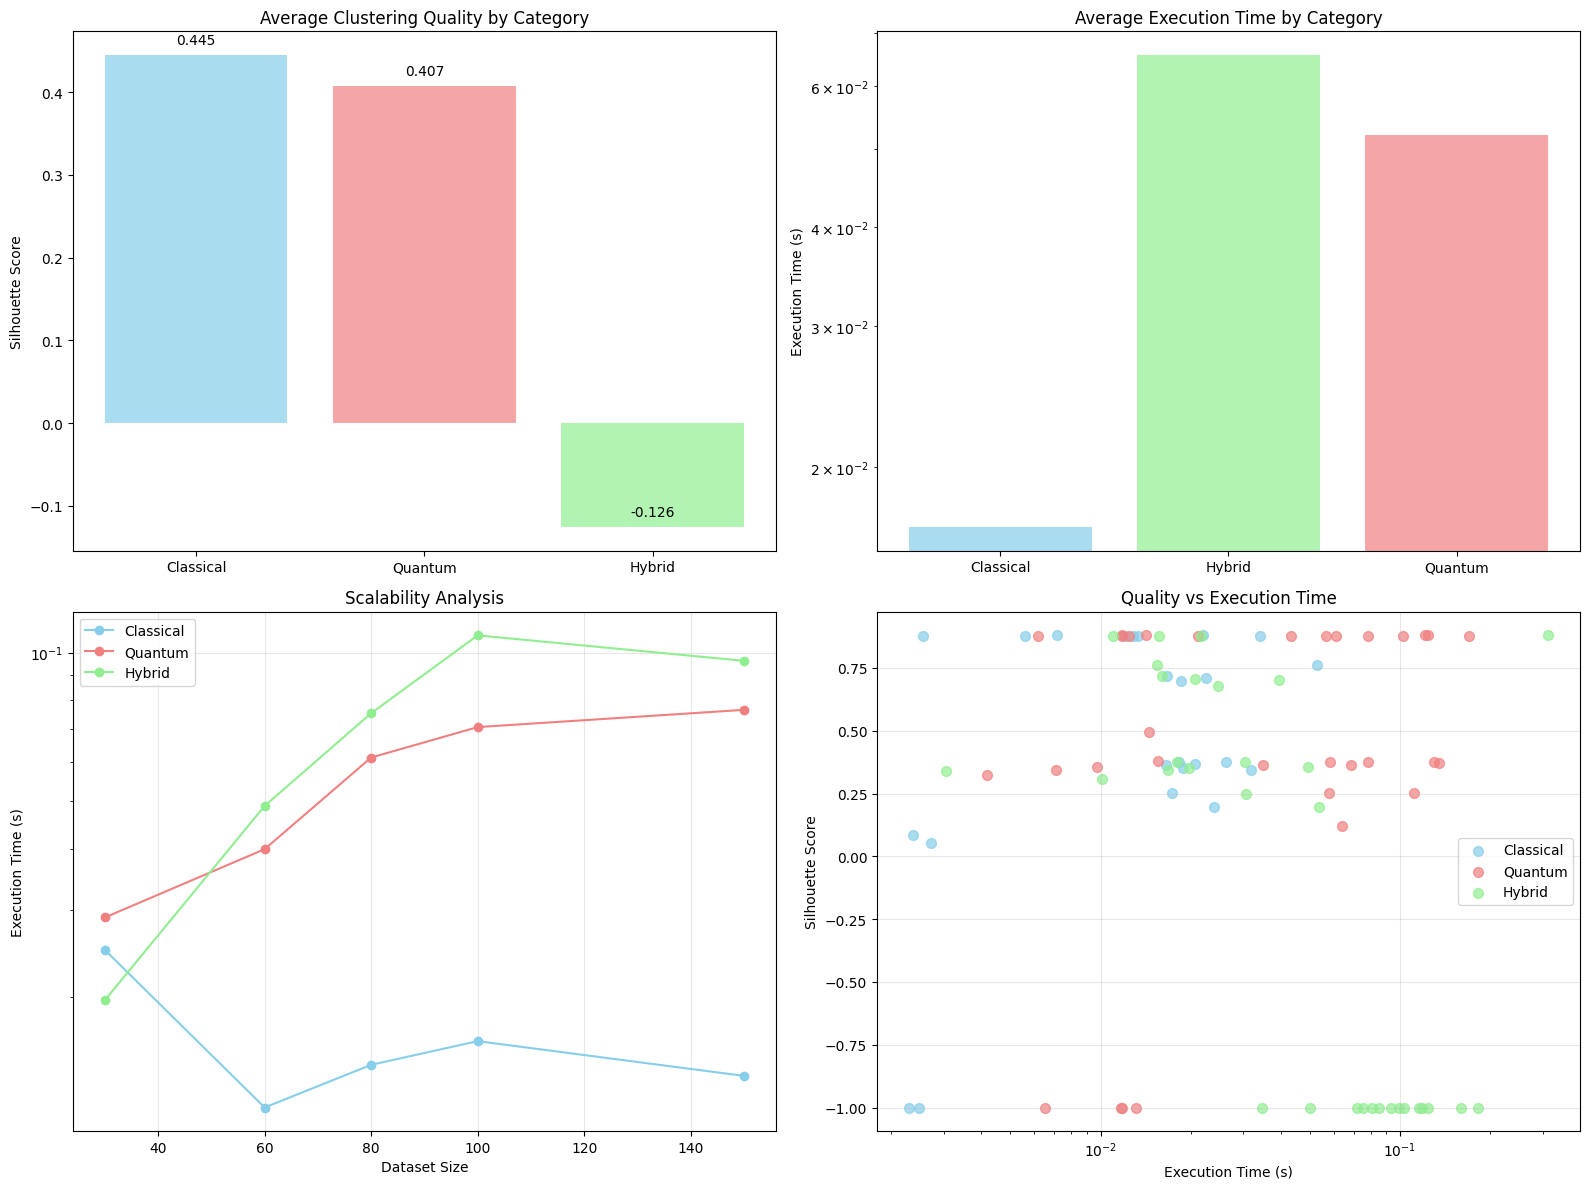

Classical vs Quantum vs Hybrid

Blobs_30 (samples: 30, features: 2)
Classical K-Means
Time: 0.0308s, Silhouette: 0.875, ARI: 1.000
Classical K-Means
Time: 0.0359s, Silhouette: 0.761, ARI: 0.911
Classical DBSCAN
Time: 0.0024s, Silhouette: 0.875, ARI: 1.000
Quantum K-Means (Simulated)
Time: 0.0494s, Silhouette: 0.875, ARI: 1.000
Adaptive Hybrid Clustering
Time: 0.0019s, Silhouette: 0.875, ARI: 1.000
Adaptive Hybrid Clustering
Time: 0.0108s, Silhouette: 0.718, ARI: 0.859
Quantum Initialized Clustering
Time: 0.0254s, Silhouette: 0.875, ARI: 1.000
Quantum Initialized Clustering
Time: 0.0138s, Silhouette: 0.875, ARI: 1.000
Quantum Distance Metric Clustering
Time: 0.0188s, Silhouette: 0.326, ARI: 0.418
Threshold-based Hybrid Clustering
Time: 0.1009s, Silhouette: -1.000, ARI: 0.000
Threshold-based Hybrid Clustering
Time: 0.0424s, Silhouette: 0.761, ARI: 0.911

Circles_30 (samples: 30, features: 2)
Classical K-Means
Time: 0.0359s, Silhouette: 0.365, ARI: -0.043
Classical K-Means
Time: 0.0501s, 

In [72]:
def main_clustering_hybrid():

    benchmark = HybridClusteringBenchmark()
    results = benchmark.hybrid_comprehensive_comparison()
    benchmark.plot_hybrid_comparison()
    benchmark.hybrid_comprehensive_comparison()
    benchmark.hybrid_summary_report()

    return benchmark, results

if __name__ == "__main__":
    benchmark, results = main_clustering_hybrid()